# Project-3. АНАЛИЗ ВОРОНКИ.

**Постановка задачи**<br>
Провести анализ поведения пользователей мобильной игры Quiz Freeze.

***Описание игры***  
*Игра состоит из следующих этапов:*
- *Регистрация (registration) — это обязательный этап. Без регистрации пользователь не может пройти на следующие этапы работы с приложением.*
- *Старт обучения (tutorial start) — опциональный этап. Пользователь после регистрации может перейти к обучению работе с приложением, а может и не перейти. При этом вернуться к обучению можно в любой момент. А ещё можно пройти обучение несколько раз.*
- *Завершение обучения (tutorial finish) может произойти только в случае, если ранее произошло событие «Старт обучения», но при этом пользователь может не завершить обучение.*
- *Выбор уровня сложности вопросов (level choice) — это обязательное событие, которое нужно для того, чтобы перейти к выбору пакетов вопросов. Таким образом, пользователь может не пройти обучение или даже не начинать его, но прежде чем начать отвечать, он обязан выбрать уровень сложности.*
- *Выбор пакетов вопросов (pack choice, другое название training choice) — это этап, на котором пользователь выбирает себе бесплатный набор пакетов вопросов, на которые он будет отвечать.*
- *Покупка платных пакетов вопросов (purchase) — это факт совершения оплаты за вопросы, которые не доступны в списке бесплатных вопросов.*

**Необходимо**:
1.	Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. 
2.	Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3.	Выяснить, как часто пользователи начинают обучение после выбора уровня сложности.
- Выполнять задание необходимо на основе данных пользователей, которые зарегистрировались в 2018 году (с 1 января по 31 декабря 2018 года включительно).


**Исходные данные**<br>
Два файла - таблицы в формате csv:<br>
- Таблица Event (https://drive.google.com/file/d/1PnyH1gDYApHNARmB18byxcNY8qOv0Hl1/view?usp=share_link). Хранит данные об основных действиях в мобильном приложении, которые совершают пользователи. 
- Таблица purchase (https://drive.google.com/file/d/1bR83gzQO3bK4pSPvfVBTeZUAnKI21Wwg/view?usp=share_link). Хранит данные об оплатах, которые совершают пользователи.

**Обнаруженные несоответствия**<br>
В одной из таблиц были события с некорректной датой. Такие события были удалены в ходе предобработки данных.

## Импортируем PANDAS, библиотеки визуализации, и исходные данные.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#events_orig = pd.read_csv('C:/New_life/DataAnalytics/PROJECT-3._Analysis_of_funnel/7_4_Events.csv', sep=',')
events_orig = pd.read_csv('https://drive.google.com/uc?export=download&id=' \
    + 'https://drive.google.com/file/d/1PnyH1gDYApHNARmB18byxcNY8qOv0Hl1/view?usp=share_link'.split('/')[-2], sep=',')
events = events_orig.copy()
#purchase_orig = pd.read_csv('C:/New_life/DataAnalytics/PROJECT-3._Analysis_of_funnel/purchase.csv', sep=',')
purchase_orig = pd.read_csv('https://drive.google.com/uc?export=download&id=' \
    + 'https://drive.google.com/file/d/1bR83gzQO3bK4pSPvfVBTeZUAnKI21Wwg/view?usp=share_link'.split('/')[-2], sep=',')
purchase = purchase_orig.copy()

## ПРЕДОБРАБОТКА ДАННЫХ
**Цели**
1) Очистить таблицы от строк с некорректными и неисправимыми значениями, определить состоятельность данных в целом.
2) Оставить в таблицах только события пользователей с регистрацией в 2018 году.

### Предобработка таблицы events

##### Проверяем отсутсвие пустых ячеек в столбцах с обязательными данными (id, event_type, start_time, user_id).

In [2]:
print(events.info())  # Результат - в столбцах с обязательными данными пустых ячеек нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252334 entries, 0 to 252333
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              252334 non-null  int64  
 1   event_type      252334 non-null  object 
 2   selected_level  31086 non-null   object 
 3   start_time      252334 non-null  object 
 4   tutorial_id     125103 non-null  float64
 5   user_id         252334 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 11.6+ MB
None


##### Убираем в таблице events строки с некорректными датами.

In [3]:
pd.set_option('display.max_rows', 4)
display('Посмотрим на исходную таблицу events:', events)    # Формат колонки с временем событий - 2016-05-11T23:40:55

def remove_t(start_time):   # функция удаления буквы "Т", разделяющей дату и время в исходных данных
    good_time=start_time.replace('T',' ')
    return good_time
events['start_time']=events['start_time'].apply(remove_t)

# При попытке перевести колонку в формат datetime выдавались ошибки, связанные с некорректным значением даты/времени
def find_wrong(start_time):     # функция определения неверных даты-времени (по формату и по сути)
    if len(start_time) != 19:       # Проверка общего формата
        return 'wrong date time' 
    elif start_time[5:7] == '02' and int(start_time[8:10]) > 28:    # Проверка превышения дня для февраля (с учетом високосных годов)
        if int(start_time[:4])%4 != 0:
            return 'wrong date time'
        elif int(start_time[:3])%100 == 0 and int(start_time[:3])%400 != 0:
            return 'wrong date time'
    elif int(start_time[5:7]) in ['01','03','05','07','08','10','12'] and int(start_time[8:10]) > 31:   # Проверка превышения дня для месяцев по 31 день
            return 'wrong date time'
    elif int(start_time[5:7]) in ['04','06','09','11'] and int(start_time[8:10]) > 30:  # Проверка превышения дня для месяцев по 30 дней
            return 'wrong date time'
    elif int(start_time[11:13]) > 23 or int(start_time[14:16]) > 60 or int(start_time[18:]) > 60:   # Проверка превышения часов, минут, секунд
            return 'wrong date time'

events['wrong_start_time']=events['start_time'].apply(find_wrong)   # добавляем колонку wrong_start_time - флаг некорректности даты-времени
display("Cобытия с некорректной датой/временем:", events[events['wrong_start_time'] == 'wrong date time'])
print("Cколько событий с некорректной датой/временем? -",  
    events[events['wrong_start_time'] == 'wrong date time'].shape[0])
print("Cколько событий всего? -", events.shape[0])
# Можно удалить события без нарушения релевантности данных.
events=events[events['wrong_start_time'] != 'wrong date time'] 
events.drop(labels='wrong_start_time',axis=1, inplace=True)

'Посмотрим на исходную таблицу events:'

,id,event_type,selected_level,start_time,tutorial_id,user_id
0,28903,registration,NaN,2016-05-11T23:40:55,NaN,12583
1,28904,registration,NaN,2016-05-11T23:49:58,NaN,12584
...,...,...,...,...,...,...
252332,281235,tutorial_start,NaN,2020-07-02T13:32:58,86127.0,87464
252333,281236,tutorial_finish,NaN,2020-07-02T13:36:36,86127.0,87464


'Cобытия с некорректной датой/временем:'

,id,event_type,selected_level,start_time,tutorial_id,user_id,wrong_start_time
10981,39884,registration,NaN,20162015-09-18,NaN,15879,wrong date time
19423,48326,tutorial_start,NaN,2017-02-29 00:49:14,22840.0,18407,wrong date time
...,...,...,...,...,...,...,...
19553,48456,registration,NaN,2017-02-29 23:40:09,NaN,18441,wrong date time
229121,258024,tutorial_finish,NaN,20202019-04-16,79776.0,80522,wrong date time


Cколько событий с некорректной датой/временем? - 133
Cколько событий всего? - 252334


##### Переводим колонку start_time в events в datetime формат 

In [4]:
events['start_time']=pd.to_datetime(events['start_time'])
display('Обработанная таблица  events:', events.head())

'Обработанная таблица  events:'

,id,event_type,selected_level,start_time,tutorial_id,user_id
0,28903,registration,NaN,2016-05-11 23:40:55,NaN,12583
1,28904,registration,NaN,2016-05-11 23:49:58,NaN,12584
...,...,...,...,...,...,...
3,28906,tutorial_start,NaN,2016-05-12 01:32:20,17562.0,12585
4,28907,tutorial_finish,NaN,2016-05-12 01:34:53,17562.0,12585


##### Проверяем колонку event_type на наличие только корректных значений, соответствующих принципам работы игры.

In [5]:
print(events['event_type'].value_counts())  # Результат - данные корректны.

registration      74873
tutorial_start    68527
                  ...  
level_choice      31069
pack_choice       21224
Name: event_type, Length: 5, dtype: int64


##### Проверяем колонку selected_level на наличие только корректных значений, соответствующих принципам работы игры.

In [6]:
print(events['selected_level'].value_counts())  # Результат - данные корректны.

medium    17395
easy       9009
hard       4665
Name: selected_level, dtype: int64


##### Оставляем в таблице events только события пользователей с регистрацией в 2018 году -> новая таблица events_users_reg2018

In [7]:
users_reg2018=events[(events['start_time'].dt.year == 2018) & (events['event_type'] == 
    'registration')]['user_id'].drop_duplicates()   # перечень пользователей с регстрацией в 2018 году
users_reg2018=pd.DataFrame(data=users_reg2018)   
events_user_reg2018=users_reg2018.merge(events,how='left',on='user_id')
display('Новая таблица events_users_reg2018:', events_user_reg2018.head())

'Новая таблица events_users_reg2018:'

,user_id,id,event_type,selected_level,start_time,tutorial_id
0,27832,80308,registration,NaN,2018-01-01 03:48:40,NaN
1,27833,80309,registration,NaN,2018-01-01 04:07:25,NaN
...,...,...,...,...,...,...
3,27833,80321,tutorial_finish,NaN,2018-01-01 17:50:08,31508.0
4,27834,80310,registration,NaN,2018-01-01 08:35:10,NaN


### Предобработка таблицы purchase

##### Проверяем отсутсвие пустых ячеек в столбцах с обязательными данными, т.е. во всех столбцах.

In [8]:
print(purchase.info())  # Результат - в столбцах с обязательными данными пустых ячеек нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5956 non-null   int64 
 1   user_id         5956 non-null   int64 
 2   event_datetime  5956 non-null   object
 3   amount          5956 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 186.2+ KB
None


##### Переводим колонку event_datetime в purchase в datetime формат 

In [9]:
display("Посмотрим на исходную таблицу purchase:", purchase.head())     # Формат колонки с временем событий - такой же, как в таблице events

# Применим к таблице purchases те же функции для исправления формата и поиска некорректных дат/времени, что были применены к таблице events
purchase['event_datetime']=purchase['event_datetime'].apply(remove_t)
purchase['wrong_event_time']=purchase['event_datetime'].apply(find_wrong)   # добавляем колонку wrong_event_time - флаг некорректности даты-времени
display("Cобытия с некорректной датой/временем:", 
    purchase[purchase['wrong_event_time'] == 'wrong date time'].head())
print("Cколько событий с некорректной датой/временем? -", 
    purchase[purchase['wrong_event_time'] == 'wrong date time'].shape[0])
print("Cколько событий всего? -", purchase.shape[0])
# Событий с некоррекными датой/временем нет.
#purchase=purchase[purchase['wrong_event_time'] != 'wrong date time']
purchase['event_datetime']=pd.to_datetime(purchase['event_datetime'])
purchase.drop(labels='wrong_event_time',axis=1, inplace=True)
display("Обработанная таблица  purchase:", purchase.head())

'Посмотрим на исходную таблицу purchase:'

,id,user_id,event_datetime,amount
0,15674,12584,2016-05-12T10:34:16,100
1,15675,12985,2016-05-13T08:25:56,50
...,...,...,...,...
3,15677,12598,2016-05-14T01:09:37,150
4,15678,13037,2016-05-14T01:24:46,100


'Cобытия с некорректной датой/временем:'

,id,user_id,event_datetime,amount,wrong_event_time


Cколько событий с некорректной датой/временем? - 0
Cколько событий всего? - 5956


'Обработанная таблица  purchase:'

,id,user_id,event_datetime,amount
0,15674,12584,2016-05-12 10:34:16,100
1,15675,12985,2016-05-13 08:25:56,50
...,...,...,...,...
3,15677,12598,2016-05-14 01:09:37,150
4,15678,13037,2016-05-14 01:24:46,100


##### Оставляем в таблице purchase только события пользователей с регистрацией в 2018 году -> новая таблица purchase_user_reg2018

In [10]:
purchase_user_reg2018=users_reg2018.merge(purchase,how='inner',on='user_id')    # Используем ранее полученный перечень пользователей с регстрацией в 2018 году
display(purchase_user_reg2018.head())

,user_id,id,event_datetime,amount
0,27845,16845,2018-01-03 18:53:43,100
1,27865,16846,2018-01-04 14:46:10,250
...,...,...,...,...
3,27910,16849,2018-01-07 12:11:34,100
4,27911,16848,2018-01-07 08:19:12,50


#### **КОММЕНТАРИЙ** по итогам предобработки данных
При попытке перевести данные колонки start_time в таблице events в формат datetime были обнаружены несколько некорректных значений даты-времени. С учетом того, что таких значений крайне мало, а также что они явно не относятся к 2018 году, строки, содержащие такие значения были удалены.

## ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ

In [11]:
print("Варианты событий:", events['event_type'].unique())

Варианты событий: ['registration' 'tutorial_start' 'tutorial_finish' 'level_choice'
 'pack_choice']


##### Убедимся, что регистрация является обязательным и первым действием для участия в игре

Убедимся, что все отстальные действия совершали только зарегестрированные пользователи:

In [12]:
events_registration=events_user_reg2018[events_user_reg2018['event_type'] == 'registration']   #events с событием registration
display("events с событием registration:", events_registration.head())
events_not_registration=events_user_reg2018[events_user_reg2018['event_type'] != 'registration']   #events с событием отличным от registration
display("events с событием, отличным от registration:", events_not_registration.head())
print("Все пользователи, совершившие действия, отличные от регистрации и оплаты, зарегистрировались?   ", 
    set(events_not_registration['user_id']).issubset(events_registration['user_id']))
print("Все пользователи, совершившие оплату, зарегистрировались?                                       ", 
    set(purchase_user_reg2018['user_id']).issubset(events_registration['user_id']))

'events с событием registration:'

,user_id,id,event_type,selected_level,start_time,tutorial_id
0,27832,80308,registration,NaN,2018-01-01 03:48:40,NaN
1,27833,80309,registration,NaN,2018-01-01 04:07:25,NaN
...,...,...,...,...,...,...
7,27835,80311,registration,NaN,2018-01-01 11:54:47,NaN
12,27836,80312,registration,NaN,2018-01-01 13:28:07,NaN


'events с событием, отличным от registration:'

,user_id,id,event_type,selected_level,start_time,tutorial_id
2,27833,80320,tutorial_start,NaN,2018-01-01 17:47:40,31508.0
3,27833,80321,tutorial_finish,NaN,2018-01-01 17:50:08,31508.0
...,...,...,...,...,...,...
6,27834,80326,tutorial_finish,NaN,2018-01-01 19:48:01,31510.0
8,27835,80316,tutorial_start,NaN,2018-01-01 15:00:51,31506.0


Все пользователи, совершившие действия, отличные от регистрации и оплаты, зарегистрировались?    True
Все пользователи, совершившие оплату, зарегистрировались?                                        True


Убедимся, что все остальные действия совершались после регистрации:

In [13]:
# подготовим таблицы events_registration, events_not_registration и purchase_user_reg2018 к объединению по user_id - дадим разные названия нужным колонкам и уберем лишние колонки
events_registration_new=events_registration.rename(columns={'start_time':'registration_time'}).drop(
    labels=['id','event_type','tutorial_id','selected_level'],axis=1)
events_not_registration_new=events_not_registration.rename(columns={'start_time':'other_event_time'}).drop(
    labels=['id','tutorial_id','event_type','selected_level'],axis=1)
purchase_user_reg2018_new=purchase_user_reg2018.rename(columns={'event_datetime':'other_event_time'}).drop(
    labels=['id','amount'],axis=1)
#display(events_not_registration_new)
#display(purchase_user_reg2018_new)
# cоеденим таблицы events_not_registration и purchase_user_reg2018
events_not_registration_all=pd.concat([events_not_registration_new, purchase_user_reg2018_new], 
    ignore_index=True, axis=0)
display("Соединенная таблица со всеми событиями, отличными от регистрации:", events_not_registration_all)
# объеденим таблицы events_registration и events_not_registration_all
events_all=events_registration_new.merge(events_not_registration_all, how='left', on='user_id')
display("Объединенная таблица со всеми событиями:", events_all)
# Создадим столбец - флаг нарушения последовательности действий
events_all['other_before_reg']=events_all['registration_time'] > events_all['other_event_time']
display("Та же таблица с добавлением флага нарушения последовательности действий:", events_all.head())
print('Сколько раз было совершено какое-либо действие без предварительной регистрации? -', 
    events_all[events_all['other_before_reg']].shape[0])


'Соединенная таблица со всеми событиями, отличными от регистрации:'

,user_id,other_event_time
0,27833,2018-01-01 17:47:40
1,27833,2018-01-01 17:50:08
...,...,...
48631,47732,2019-01-06 07:14:25
48632,47742,2019-01-04 12:51:41


'Объединенная таблица со всеми событиями:'

,user_id,registration_time,other_event_time
0,27832,2018-01-01 03:48:40,NaT
1,27833,2018-01-01 04:07:25,2018-01-01 17:47:40
...,...,...,...
56601,47756,2018-12-31 23:17:30,2019-01-01 05:50:36
56602,47757,2018-12-31 23:18:06,NaT


'Та же таблица с добавлением флага нарушения последовательности действий:'

,user_id,registration_time,other_event_time,other_before_reg
0,27832,2018-01-01 03:48:40,NaT,False
1,27833,2018-01-01 04:07:25,2018-01-01 17:47:40,False
...,...,...,...,...
3,27834,2018-01-01 08:35:10,2018-01-01 19:46:11,False
4,27834,2018-01-01 08:35:10,2018-01-01 19:48:01,False


Сколько раз было совершено какое-либо действие без предварительной регистрации? - 0


#### Убедимся, что все пользователи выполняли действия level_choice, pack_choice и purchase не более одного раза, и что действия совершались в правильной последовательности

##### Убедимся, что все пользователи выполняли действие level_choice не более одного раза

In [14]:
events_level_choice=events_user_reg2018[events_user_reg2018['event_type'] == 'level_choice']   #events с событием level_choice
display("events с событием level_choice:", events_level_choice.head())
# убедимся что все пользователи выполняли действие level_choice не более одного раза
print("Все пользователи выполняли действие level_choice не более одного раза?   -", 
    events_level_choice.shape[0] == events_level_choice['user_id'].nunique())

'events с событием level_choice:'

,user_id,id,event_type,selected_level,start_time,tutorial_id
10,27835,80327,level_choice,medium,2018-01-01 20:37:22,NaN
21,27839,80331,level_choice,hard,2018-01-01 22:37:50,NaN
...,...,...,...,...,...,...
32,27842,80353,level_choice,easy,2018-01-02 08:46:03,NaN
39,27843,80365,level_choice,medium,2018-01-02 14:09:58,NaN


Все пользователи выполняли действие level_choice не более одного раза?   - True


##### Убедимся, что все пользователи выполняли действие pack_choice не более одного раза

In [15]:
events_pack_choice=events_user_reg2018[events_user_reg2018['event_type'] == 'pack_choice']   #events с событием pack_choice
display("events с событием pack_choice:", events_pack_choice.head())
# убедимся что все пользователи выполняли действие pack_choice не более одного раза
print("Все пользователи выполняли действие pack_choice не более одного раза?   -", 
    events_pack_choice.shape[0] == events_pack_choice['user_id'].nunique())

'events с событием pack_choice:'

,user_id,id,event_type,selected_level,start_time,tutorial_id
11,27835,80328,pack_choice,NaN,2018-01-01 20:38:43,NaN
22,27839,80332,pack_choice,NaN,2018-01-01 22:42:54,NaN
...,...,...,...,...,...,...
46,27845,80347,pack_choice,NaN,2018-01-02 06:25:12,NaN
53,27846,80369,pack_choice,NaN,2018-01-02 15:14:18,NaN


Все пользователи выполняли действие pack_choice не более одного раза?   - True


##### Посмотрим, сколько пользователей совершившили level_choice, pack_choice, и убедимся, что все пользователи, совершившие pack_choice, совершили level_choice.

In [16]:
print("Сколько пользователей совершили level_choice? -", events_level_choice.shape[0])
print("Сколько пользователей совершили pack_choice? -", events_pack_choice.shape[0])
print("Все пользователи, совершившие pack_choice, совершили level_choice:   ", 
    #events_pack_choice['user_id'].isin(events_level_choice['user_id']))
    set(events_pack_choice['user_id']).issubset(events_level_choice['user_id']))

Сколько пользователей совершили level_choice? - 8342
Сколько пользователей совершили pack_choice? - 5737
Все пользователи, совершившие pack_choice, совершили level_choice:    True


##### Убедимся что все пользователи совершали оплату не более одного раза

In [17]:
print("Все пользователи совершали оплату не более одного раза:   ", 
    purchase_user_reg2018.shape[0] == purchase_user_reg2018['user_id'].nunique())

Все пользователи совершали оплату не более одного раза:    True


##### Посмотрим сколько пользователей совершили level_choice, сколько пользователей сделали оплату и убедимся что все пользователи, сделавшие оплату, совершили level_choice 

In [18]:
print("Сколько пользователей совершили level_choice?                -", events_level_choice.shape[0])
print("Сколько пользователей сделали оплату?                        -", purchase_user_reg2018.shape[0])
print("Все пользователи, сделавшие оплату, совершили level_choice:   ", 
    purchase_user_reg2018[purchase_user_reg2018['user_id'].isin(events_level_choice['user_id'])]
    ['user_id'].shape[0] == purchase_user_reg2018.shape[0])

Сколько пользователей совершили level_choice?                - 8342
Сколько пользователей сделали оплату?                        - 1600
Все пользователи, сделавшие оплату, совершили level_choice:    True


##### Посмотрим сколько пользователей совершили pack_choice, сколько пользователей сделали оплату и убедимся что все пользователи, сделавшие оплату, совершили pack_choice 

In [19]:
print("Сколько пользователей совершили pack_choice?                 -", events_pack_choice.shape[0])
print("Сколько пользователей сделали оплату?                        -", purchase_user_reg2018.shape[0])
print("Все пользователи, сделавшие оплату, совершили pack_choice:    ", 
    purchase_user_reg2018[purchase_user_reg2018['user_id'].isin(events_pack_choice['user_id'])]
    ['user_id'].shape[0] == purchase_user_reg2018.shape[0])

Сколько пользователей совершили pack_choice?                 - 5737
Сколько пользователей сделали оплату?                        - 1600
Все пользователи, сделавшие оплату, совершили pack_choice:     True


##### Определим нет ли нарушения порядка следования событий - pack_choice раньше level_choice, purchase раньше level_choice или pack_choice

In [20]:
# подготовим таблицы events_level_choice, events_pack_choice и purchase_user_reg2018 к объединению по user_id - дадим разные названия нужным колонкам и уберем лишние колонки
events_level_choice_new=events_level_choice.rename(columns={'start_time':'level_choice_time'}).drop(
    labels=['id','tutorial_id','event_type','selected_level'],axis=1)
events_pack_choice_new=events_pack_choice.rename(columns={'start_time':'pack_choice_time'}).drop(
    labels=['id','tutorial_id','event_type','selected_level'],axis=1)
purchase_user_reg2018_new=purchase_user_reg2018.rename(columns={'event_datetime':'purchase_time'}).drop(
    labels=['id','amount'],axis=1)
# объеденим таблицы
events_level_pack_choice=events_level_choice_new.merge(events_pack_choice_new, how='left', on='user_id')
events_level_pack_purchase=events_level_pack_choice.merge(purchase_user_reg2018_new, how='left', on='user_id')
display("Таблица с различными событиями пользователя в разрезе user_id:", events_level_pack_purchase.head())
# Создадим столбцы - флаги нарушения последовательности действий
events_level_pack_purchase['pack_before_level'] \
    =events_level_pack_purchase['level_choice_time'] > events_level_pack_purchase['pack_choice_time']
events_level_pack_purchase['purchase_before_pack'] \
    =events_level_pack_purchase['pack_choice_time'] > events_level_pack_purchase['purchase_time']
events_level_pack_purchase['purchase_before_level'] \
    =events_level_pack_purchase['level_choice_time'] > events_level_pack_purchase['purchase_time']
display("Та же таблица с добавлением флагов нарушения последовательности действий:", 
    events_level_pack_purchase.head())
print('Сколько пользователей совершили pack_choice раньше level_choice? -', 
    events_level_pack_purchase[events_level_pack_purchase['pack_before_level']].shape[0])
print('Сколько пользователей совершили purschase раньше level_choice?   -', 
    events_level_pack_purchase[events_level_pack_purchase['purchase_before_level']].shape[0])
print('Сколько пользователей совершили purschase раньше pack_choice?    -', 
    events_level_pack_purchase[events_level_pack_purchase['purchase_before_pack']].shape[0])

'Таблица с различными событиями пользователя в разрезе user_id:'

,user_id,level_choice_time,pack_choice_time,purchase_time
0,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT
1,27839,2018-01-01 22:37:50,2018-01-01 22:42:54,NaT
...,...,...,...,...
3,27842,2018-01-02 08:46:03,NaT,NaT
4,27843,2018-01-02 14:09:58,2018-01-02 14:14:51,NaT


'Та же таблица с добавлением флагов нарушения последовательности действий:'

,user_id,level_choice_time,pack_choice_time,purchase_time,pack_before_level,purchase_before_pack,purchase_before_level
0,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,False,False,False
1,27839,2018-01-01 22:37:50,2018-01-01 22:42:54,NaT,False,False,False
...,...,...,...,...,...,...,...
3,27842,2018-01-02 08:46:03,NaT,NaT,False,False,False
4,27843,2018-01-02 14:09:58,2018-01-02 14:14:51,NaT,False,False,False


Сколько пользователей совершили pack_choice раньше level_choice? - 0
Сколько пользователей совершили purschase раньше level_choice?   - 0
Сколько пользователей совершили purschase раньше pack_choice?    - 0


#### Посмотрим нет ли нарушений логики игры в событиях обучения (tutorial)

##### Подготовка таблиц и получение некоторых статистических данных

Выделим из таблицы events события типа tutorial_start:

In [21]:
events_tutorial_start=events_user_reg2018[events_user_reg2018['event_type'] == 'tutorial_start']   #events с событием tutorial_start
display("events с событием tutorial_start:", events_tutorial_start.head())
# убедимся что для каждого начатого обучения указан tutorial_id
print(events_tutorial_start.info(), "\n")   # Результат - в столбце tutorial_id пустых ячеек нет => tutorial_id указан для всех tutorial_start
print("Количество событий типа tutorial_start                 -", events_tutorial_start.shape[0])
print("Количество пользователей, совершивших tutorial_start   -", 
    events_tutorial_start['user_id'].nunique())
print("В среднем пользователь начинал обучение около            ", 
    round(events_tutorial_start.shape[0] / events_tutorial_start['user_id'].nunique(), 2), "раз")

'events с событием tutorial_start:'

,user_id,id,event_type,selected_level,start_time,tutorial_id
2,27833,80320,tutorial_start,NaN,2018-01-01 17:47:40,31508.0
5,27834,80325,tutorial_start,NaN,2018-01-01 19:46:11,31510.0
...,...,...,...,...,...,...
13,27836,80315,tutorial_start,NaN,2018-01-01 14:54:40,31505.0
14,27836,80318,tutorial_start,NaN,2018-01-01 15:40:43,31507.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18050 entries, 2 to 66954
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         18050 non-null  int64         
 1   id              18050 non-null  int64         
 2   event_type      18050 non-null  object        
 3   selected_level  0 non-null      object        
 4   start_time      18050 non-null  datetime64[ns]
 5   tutorial_id     18050 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 987.1+ KB
None 

Количество событий типа tutorial_start                 - 18050
Количество пользователей, совершивших tutorial_start   - 11858
В среднем пользователь начинал обучение около             1.52 раз


Выделим из таблицы events события типа tutorial_finish:

In [22]:
events_tutorial_finish=events_user_reg2018[events_user_reg2018['event_type'] == 'tutorial_finish']   #events с событием tutorial_finish
display("events с событием tutorial_finish:", events_tutorial_finish.head())
print('Убедимся что для каждого завершенного обучения указан tutorial_id - events_tutorial_finish.info():')
print(events_tutorial_finish.info(), "\n")   # Результат - в столбце tutorial_id пустых ячеек нет => tutorial_id указан для всех tutorial_finish
print("Количество событий типа tutorial_finish                 -", events_tutorial_finish.shape[0])
print("Количество пользователей, совершивших tutorial_finish   -", 
    events_tutorial_finish['user_id'].nunique())
print("В среднем пользователь заканчивал обучение около             ",
    round(events_tutorial_finish.shape[0] / events_tutorial_finish['user_id'].nunique(), 2), "раз")

'events с событием tutorial_finish:'

,user_id,id,event_type,selected_level,start_time,tutorial_id
3,27833,80321,tutorial_finish,NaN,2018-01-01 17:50:08,31508.0
6,27834,80326,tutorial_finish,NaN,2018-01-01 19:48:01,31510.0
...,...,...,...,...,...,...
15,27836,80319,tutorial_finish,NaN,2018-01-01 15:42:58,31507.0
20,27839,80324,tutorial_finish,NaN,2018-01-01 19:16:32,31509.0


Убедимся что для каждого завершенного обучения указан tutorial_id - events_tutorial_finish.info():
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14904 entries, 3 to 66955
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         14904 non-null  int64         
 1   id              14904 non-null  int64         
 2   event_type      14904 non-null  object        
 3   selected_level  0 non-null      object        
 4   start_time      14904 non-null  datetime64[ns]
 5   tutorial_id     14904 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 815.1+ KB
None 

Количество событий типа tutorial_finish                 - 14904
Количество пользователей, совершивших tutorial_finish   - 10250
В среднем пользователь заканчивал обучение около              1.45 раз


##### Убедимся, что tutorial_id уникален, т.е. не повторяется в рамках событий tutorial_start и в рамках событий tutorial_finish

In [23]:
print("Количество событий tutorial_start        -", events_tutorial_start['tutorial_id'].shape[0])
print("     Количество уникальных tutorial_id   -", events_tutorial_start['tutorial_id'].nunique())  # tutorial_id уникальны 
print("Количество событий tutorial_finish       -", events_tutorial_finish['tutorial_id'].shape[0])
print("     Количество уникальных tutorial_id   -", events_tutorial_finish['tutorial_id'].nunique())  # tutorial_id уникальны 

Количество событий tutorial_start        - 18050
     Количество уникальных tutorial_id   - 18050
Количество событий tutorial_finish       - 14904
     Количество уникальных tutorial_id   - 14904


##### Убедимся, что все законченные tutorial_id были начаты

In [24]:
print("Все законченные tutorial_id были начаты:   ", 
    set(events_tutorial_finish['tutorial_id']).issubset(events_tutorial_start['tutorial_id']))

Все законченные tutorial_id были начаты:    True


##### Убедимся что каждый tutorial_id начат и закончен одним и тем же пользователем

In [25]:
# подготовим таблицы events_tutorial_start и events_tutorial_finish	к объединению по tutorial_id - дадим разные названия нужным колонкам и уберем лишние колонки
events_tutorial_start_new=events_tutorial_start.rename(columns={'start_time':'tutorial_start_time', 
    'user_id':'started_user_id'}).drop(labels=['id','event_type','selected_level'],axis=1)
events_tutorial_finish_new=events_tutorial_finish.rename(columns={'start_time':'tutorial_finish_time', 
    'user_id':'finished_user_id'}).drop(labels=['id','event_type','selected_level'],axis=1)
# объеденим таблицы
events_tutorial=events_tutorial_start_new.merge(events_tutorial_finish_new, how='left', on='tutorial_id')
display("Таблица событий по tutorial_id:", events_tutorial.head())
# Создадим столбец - флаг нарушения логики использования tutorial
events_tutorial['one_tutorial_diff_users']=events_tutorial['started_user_id'] \
    != events_tutorial['started_user_id']
display("Та же таблица с добавлением флага нарушения последовательности действий:", events_tutorial.head())
print('Сколько tutorial начаты одним пользователем, а закончены другим? -', 
    events_tutorial[events_tutorial['one_tutorial_diff_users']].shape[0])


'Таблица событий по tutorial_id:'

,started_user_id,tutorial_start_time,tutorial_id,finished_user_id,tutorial_finish_time
0,27833,2018-01-01 17:47:40,31508.0,27833.0,2018-01-01 17:50:08
1,27834,2018-01-01 19:46:11,31510.0,27834.0,2018-01-01 19:48:01
...,...,...,...,...,...
3,27836,2018-01-01 14:54:40,31505.0,NaN,NaT
4,27836,2018-01-01 15:40:43,31507.0,27836.0,2018-01-01 15:42:58


'Та же таблица с добавлением флага нарушения последовательности действий:'

,started_user_id,tutorial_start_time,tutorial_id,finished_user_id,tutorial_finish_time,one_tutorial_diff_users
0,27833,2018-01-01 17:47:40,31508.0,27833.0,2018-01-01 17:50:08,False
1,27834,2018-01-01 19:46:11,31510.0,27834.0,2018-01-01 19:48:01,False
...,...,...,...,...,...,...
3,27836,2018-01-01 14:54:40,31505.0,NaN,NaT,False
4,27836,2018-01-01 15:40:43,31507.0,27836.0,2018-01-01 15:42:58,False


Сколько tutorial начаты одним пользователем, а закончены другим? - 0


##### Определим нет ли нарушения порядка следования событий - tutorial_finish раньше tutorial_start, базируясь на tutorial_id

In [26]:
# Создадим столбец - флаг нарушения последовательности действий
events_tutorial['finish_before_start']=events_tutorial['tutorial_start_time'] \
    > events_tutorial['tutorial_finish_time']
display("Прежняя таблица с добавлением флагов нарушения последовательности действий:", 
    events_tutorial.head())
print('Сколько tutorial завершены раньше чем начаты? -', 
    events_tutorial[events_tutorial['finish_before_start']].shape[0])

'Прежняя таблица с добавлением флагов нарушения последовательности действий:'

,started_user_id,tutorial_start_time,tutorial_id,finished_user_id,tutorial_finish_time,one_tutorial_diff_users,finish_before_start
0,27833,2018-01-01 17:47:40,31508.0,27833.0,2018-01-01 17:50:08,False,False
1,27834,2018-01-01 19:46:11,31510.0,27834.0,2018-01-01 19:48:01,False,False
...,...,...,...,...,...,...,...
3,27836,2018-01-01 14:54:40,31505.0,NaN,NaT,False,False
4,27836,2018-01-01 15:40:43,31507.0,27836.0,2018-01-01 15:42:58,False,False


Сколько tutorial завершены раньше чем начаты? - 0


##### Определим, проходили ли пользователи обучение после оплаты (purchase)

Соединим вертикально таблицы с оплатой и с остальными событиями, кроме регистрации, в единую таблицу:

In [27]:
events_wo_reg=events_user_reg2018[events_user_reg2018['event_type'] != 'registration'] \
    .rename(columns={'start_time':'event_datetime'}).drop(labels=['id'],axis=1)
    # таблица со всеми действиями, кроме оплаты и регистрации
purchase_user_reg2018_new2=purchase_user_reg2018.drop(labels=['id'],axis=1)
purchase_user_reg2018_new2['event_type']='purchase'
events_wo_reg=pd.concat([events_wo_reg, purchase_user_reg2018_new2], ignore_index=True, axis=0) # объединенная таблица со всеми действиями, кроме регистрации
display("Объединенная таблица со всеми действиями, кроме регистрации:", events_wo_reg)

'Объединенная таблица со всеми действиями, кроме регистрации:'

,user_id,event_type,selected_level,event_datetime,tutorial_id,amount
0,27833,tutorial_start,NaN,2018-01-01 17:47:40,31508.0,NaN
1,27833,tutorial_finish,NaN,2018-01-01 17:50:08,31508.0,NaN
...,...,...,...,...,...,...
48631,47732,purchase,NaN,2019-01-06 07:14:25,NaN,150.0
48632,47742,purchase,NaN,2019-01-04 12:51:41,NaN,50.0


Оставим в объединенной таблице только события обучения и оплаты, и только пользователей, совершивших оплату:

In [28]:
events_tutorial_purchase=events_wo_reg[events_wo_reg['event_type'].isin\
    (['tutorial_start', 'tutorial_finish', 'purchase']) & events_wo_reg['user_id'].isin\
    (list(purchase_user_reg2018['user_id'])) ]
    # Таблица с событиями обучения и оплаты и только для пользователей, совершивших оплату.
events_tutorial_purchase=events_tutorial_purchase.sort_values \
    (by='event_datetime', axis=0, ascending=True, ignore_index=True)
display("Таблица с событиями обучения и оплаты и только для пользователей, совершивших оплату:", 
    events_tutorial_purchase)

'Таблица с событиями обучения и оплаты и только для пользователей, совершивших оплату:'

,user_id,event_type,selected_level,event_datetime,tutorial_id,amount
0,27845,tutorial_start,NaN,2018-01-02 03:03:44,31512.0,NaN
1,27845,tutorial_finish,NaN,2018-01-02 03:06:48,31512.0,NaN
...,...,...,...,...,...,...
6108,47742,purchase,NaN,2019-01-04 12:51:41,NaN,50.0
6109,47732,purchase,NaN,2019-01-06 07:14:25,NaN,150.0


Сгруппируем таблицу по пользователям и определим последнее действие и посмотрим, есть ли обучение после оплаты:

In [29]:
events_tutorial_purchase_last=events_tutorial_purchase.drop(
    labels=['selected_level','tutorial_id', 'amount'],axis=1).groupby(['user_id'], 
    axis=0).last().rename(columns={'event_type':'last_event_type'})
    # Таблица с последним действием пользователей, совершивших оплату
display("Таблица с последним действием пользователей, совершивших оплату:", events_tutorial_purchase_last)
print("Есть ли пользователи, чьим последним действием (после оплаты) был старт обучения?         -", 
    events_tutorial_purchase_last[events_tutorial_purchase_last['last_event_type']=='tutorial_start'].shape[0]>0)
print("Есть ли пользователи, чьим последним действием (после оплаты) было завершение обучения?   -", 
    events_tutorial_purchase_last[events_tutorial_purchase_last['last_event_type']=='tutorial_finish'].shape[0]>0)
print("Количество таких пользователей                                                            -", 
    events_tutorial_purchase_last[events_tutorial_purchase_last['last_event_type'] != 'purchase'].shape[0]) 
display("Посмотрим на последнее действие таких пользователей:", 
    events_tutorial_purchase_last[events_tutorial_purchase_last['last_event_type'] != 'purchase']) 
display("Посмотрим на последовательность действий таких пользователей:", 
    events_wo_reg[events_wo_reg['user_id'].isin([30035,34930,44858])].sort_values(by=['user_id', 'event_datetime'], axis=0, \
        ascending=True, ignore_index=False, inplace=False))

'Таблица с последним действием пользователей, совершивших оплату:'

,last_event_type,event_datetime
user_id,,
27845,purchase,2018-01-03 18:53:43
27865,purchase,2018-01-04 14:46:10
...,...,...
47732,purchase,2019-01-06 07:14:25
47742,purchase,2019-01-04 12:51:41


Есть ли пользователи, чьим последним действием (после оплаты) был старт обучения?         - True
Есть ли пользователи, чьим последним действием (после оплаты) было завершение обучения?   - True
Количество таких пользователей                                                            - 3


'Посмотрим на последнее действие таких пользователей:'

,last_event_type,event_datetime
user_id,,
30035,tutorial_finish,2018-02-14 06:09:51
34930,tutorial_finish,2018-05-05 02:33:48
44858,tutorial_start,2018-11-18 22:51:23


'Посмотрим на последовательность действий таких пользователей:'

,user_id,event_type,selected_level,event_datetime,tutorial_id,amount
5186,30035,tutorial_start,NaN,2018-02-13 12:43:45,33504.0,NaN
5187,30035,tutorial_finish,NaN,2018-02-13 12:45:25,33504.0,NaN
...,...,...,...,...,...,...
48397,44858,purchase,NaN,2018-11-18 21:34:59,NaN,250.0
39972,44858,tutorial_start,NaN,2018-11-18 22:51:23,46882.0,NaN


#### Разберемся с логикой прохождения обучения в процессе игры.

##### Выясним, есть ли обучения (tutorial_id), начатые на одном этапе игры, а завершенные на другом.

Воспользуемся старой таблицей events_wo_reg и получим из нее таблицу последовательности действий каждого пользователя в виде списка -> таблица events_seq_per_user:

In [30]:
events_wo_reg.sort_values(by='event_datetime', axis=0, ascending=True, ignore_index=True, inplace=True)
print('Все события, кроме регистрации:')
display(events_wo_reg)
events_seq_per_user=events_wo_reg.groupby(['user_id'], axis=0) 
events_seq_per_user=events_seq_per_user['event_type'].apply(list).reset_index()
events_seq_per_user['n_of_events']=events_seq_per_user['event_type'].apply(lambda et : len(et))
print('Последовательность действий пользователей (кроме регистрации):')
display(events_seq_per_user)

Все события, кроме регистрации:


,user_id,event_type,selected_level,event_datetime,tutorial_id,amount
0,27836,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,NaN
1,27835,tutorial_start,NaN,2018-01-01 15:00:51,31506.0,NaN
...,...,...,...,...,...,...
48631,47742,purchase,NaN,2019-01-04 12:51:41,NaN,50.0
48632,47732,purchase,NaN,2019-01-06 07:14:25,NaN,150.0


Последовательность действий пользователей (кроме регистрации):


,user_id,event_type,n_of_events
0,27833,"[tutorial_start, tutorial_finish]",2
1,27834,"[tutorial_start, tutorial_finish]",2
...,...,...,...
11954,47755,"[tutorial_start, tutorial_finish, level_choice]",3
11955,47756,"[tutorial_start, tutorial_finish, level_choice...",4


Добавим к таблице последовательности действий заготовку столбца-флага о наличии обучения, начатого на одном, а законченного на другом этапе игры.
Напишем функцию, заполняющую столбец-флаг, и применим ее к таблице - последовательности действий:

In [31]:
events_seq_per_user['tutorial_interupt']='no'

# функция проверяет какое событие шло непосредственно перед tutorial_finish - если это не tutorial_start и не другой tutorial_finish, значит данное обучение начато на одном, а закончено на другом этапе игры  
def tutorial_check(row):
    for event_nbr in range(len(row['event_type'])):
        if row['event_type'][event_nbr] == 'tutorial_finish':
            if row['event_type'][event_nbr - 1] != 'tutorial_start' \
                    and row['event_type'][event_nbr - 1] != 'tutorial_finish':
                row['tutorial_interupt']='interruption!'
    return row

events_seq_per_user=events_seq_per_user.apply(lambda row: tutorial_check(row), axis=1)
print('Таблица последовательности действий с заполненным флагом обучения, начатого на одном, а законченного на другом этапе игры:')
display(events_seq_per_user)
print('Количество пользователей у которых есть обучения, начатые на одном, а законченные на другом этапе игры   -', \
    events_seq_per_user[events_seq_per_user['tutorial_interupt']=='interruption!'].shape[0])
#events_seq_per_user[events_seq_per_user['tutorial_interupt']=='interruption!'].to_csv('C:/New_life/DataAnalytics/PROJECT-3._Analysis_of_funnel/tut_interapt.csv', index=False, sep=';')


Таблица последовательности действий с заполненным флагом обучения, начатого на одном, а законченного на другом этапе игры:


,user_id,event_type,n_of_events,tutorial_interupt
0,27833,"[tutorial_start, tutorial_finish]",2,no
1,27834,"[tutorial_start, tutorial_finish]",2,no
...,...,...,...,...
11954,47755,"[tutorial_start, tutorial_finish, level_choice]",3,no
11955,47756,"[tutorial_start, tutorial_finish, level_choice...",4,no


Количество пользователей у которых есть обучения, начатые на одном, а законченные на другом этапе игры   - 36


##### Выясним, есть ли обучения (tutorial_id), идущие параллельно друг с другом.

Воспользуемся старой таблицей с событиями за 2018 г. и выделим из нее только события обучения -> таблица events_tutorial_new:

In [32]:
events_tutorial_new=events_user_reg2018[(events_user_reg2018['event_type'] == 'tutorial_start') \
    | (events_user_reg2018['event_type'] == 'tutorial_finish')]   #events с событиями tutorial
events_tutorial_new=events_tutorial_new.rename(columns={'start_time':'time'}).drop(axis=1,
    labels=['selected_level','id']).sort_values(by='time', axis=0, ascending=True, ignore_index=True)
display("events с событиями tutorial:", events_tutorial_new)

'events с событиями tutorial:'

,user_id,event_type,time,tutorial_id
0,27836,tutorial_start,2018-01-01 14:54:40,31505.0
1,27835,tutorial_start,2018-01-01 15:00:51,31506.0
...,...,...,...,...
32952,47756,tutorial_start,2019-01-01 03:26:18,49554.0
32953,47756,tutorial_finish,2019-01-01 03:29:25,49554.0


Получим из этой таблицы таблицу последовательности действий каждого пользователя в виде списка -> таблица tutorial_seq_per_user:

In [33]:
tutorial_seq_per_user=events_tutorial_new.groupby(['user_id'], axis=0) 
tutorial_seq_per_user=tutorial_seq_per_user['event_type'].apply(list).reset_index()
tutorial_seq_per_user['n_of_events']=tutorial_seq_per_user['event_type'].apply(lambda et : len(et))
print('Последовательность событий обучения пользователей:')
pd.set_option('display.max_rows', 8)
display(tutorial_seq_per_user)

Последовательность событий обучения пользователей:


,user_id,event_type,n_of_events
0,27833,"[tutorial_start, tutorial_finish]",2
1,27834,"[tutorial_start, tutorial_finish]",2
2,27835,"[tutorial_start, tutorial_finish]",2
3,27836,"[tutorial_start, tutorial_start, tutorial_finish]",3
...,...,...,...
11854,47751,"[tutorial_start, tutorial_finish]",2
11855,47753,"[tutorial_start, tutorial_finish]",2
11856,47755,"[tutorial_start, tutorial_finish]",2
11857,47756,"[tutorial_start, tutorial_finish]",2


Добавим к таблице последовательности событий-обучений заготовку столбца-флага о наличии параллельно идущих обучений одного пользователя.
Напишем функцию, заполняющую столбец-флаг, и применим ее к таблице - последовательности событий-обучений:

In [34]:
events_seq_per_user['many_finish']='no'     

# функция проверяет наличи двух событий tutorial_finish подряд, что свидетельствует о том, что параллельно шли два ранее начатые события обучения
def tutorial_check_2(row):          
    for event_nbr in range(len(row['event_type'])):
        if row['event_type'][event_nbr] == 'tutorial_finish':
            if row['event_type'][event_nbr - 1] != 'tutorial_start':
                row['many_finish']='many_finish!'
    return row

tutorial_seq_per_user=tutorial_seq_per_user.apply(lambda row: tutorial_check_2(row), axis=1)
print('Таблица последовательности действий с заполненным флагом наличия обучения, идущего параллельно с другим обучением:')
display(tutorial_seq_per_user)
print('Количество пользователей у которых есть обучения, идущие параллельно друг с другом   -', \
    tutorial_seq_per_user[tutorial_seq_per_user['many_finish']=='many_finish!'].shape[0])
pd.set_option('display.max_rows', 8)
#tutorial_seq_per_user[tutorial_seq_per_user['many_finish']=='many_finish!'].to_csv('C:/New_life/DataAnalytics/PROJECT-3._Analysis_of_funnel/tut_many_finish.csv', index=False, sep=';')


Таблица последовательности действий с заполненным флагом наличия обучения, идущего параллельно с другим обучением:


,event_type,many_finish,n_of_events,user_id
0,"[tutorial_start, tutorial_finish]",NaN,2,27833
1,"[tutorial_start, tutorial_finish]",NaN,2,27834
2,"[tutorial_start, tutorial_finish]",NaN,2,27835
3,"[tutorial_start, tutorial_start, tutorial_finish]",NaN,3,27836
...,...,...,...,...
11854,"[tutorial_start, tutorial_finish]",NaN,2,47751
11855,"[tutorial_start, tutorial_finish]",NaN,2,47753
11856,"[tutorial_start, tutorial_finish]",NaN,2,47755
11857,"[tutorial_start, tutorial_finish]",NaN,2,47756


Количество пользователей у которых есть обучения, идущие параллельно друг с другом   - 97


#### **РЕЗУЛЬТАТЫ** предварительного анализа
**Проверка корректности данных:**  

_Результат:_ Данные по пользователям, зарегистрировавшимся в 2018 г., целостны и корректны.
- selected_level указан для всех событий типа level_choice
- selected_level для всех событий, отличных от level_choice, отсутствует 
- Все пользователи, совершившие действия, отличные от регистрации, зарегистрировались ранее  
- Каждый пользователь, совершивший purchase, ранее совершил pack_choice
- Каждый пользователь, совершивший pack_choice, ранее совершил level_choice
- tutorial_id указан для всех событий типа tutorial_start
- Все законченные tutorial_id были начаты ранее
- Каждый законченный tutorial_id был закончен тем же пользователем, который его начал  
- Имеются обучения (tutorial_id), начатые на одном этапе игры, а завершенные на другом; количество пользователей с такими обучениями незанчительно (36).
- Имеются обучения (tutorial_id), идущие параллельно друг с другом (для одного пользователя); количество пользователей с такими обучениями невелико (97).

**Некоторые колличественные данные:**

|||
|---|---|
|Сколько пользователей совершили level_choice?|8342|
|Сколько пользователей совершили pack_choice?|5737|
|Сколько пользователей сделали оплату?|1600|
|Количество событий типа tutorial_start|18050|
|&emsp;Количество уникальных tutorial_id|18050|
|Количество пользователей, совершивших tutorial_start|11858|
|В среднем пользователь начинал обучение около|1.52 раз|
|Количество событий типа tutorial_finish|14904|
|&emsp;Количество уникальных tutorial_id|14904|
|Количество пользователей, совершивших tutorial_finish|10250|
|В среднем пользователь заканчивал обучение около|1.45 раз|
|Количество пользователей, проходивших обучение после оплаты|3|

**Некоторые выводы об алгоритме работы игры:**
- Действия level_choice, pack_choice и purchase могут располагаться только в следующем порядке:  -> level_choice -> pack_choice -> purchase
  - для совершения purchase предыдущие два действия обязательны
- Действия level_choice, pack_choice и purchase можно совершить только по одному разу.   
- tutorial_id представляет собой уникальный идентификатор события обучения (имеющего начало и конец)
- Проходить обучение (начинать (tutorial_start) и/или завершать (tutorial_finish)) возможно и после оплаты платных вопросов (purchase), однако такое поведение пользователя встречается крайне редко




## АНАЛИЗ ДАННЫХ ДЛЯ ОТВЕТА НА ПОСТАВЛЕННЫЕ ВОПРОСЫ

### ОПРЕДЕЛЕНИЕ МЕДИАННОЙ ПРОДОЛЖИТЕЛЬНОСТИ И РАСПРЕДЕЛЕНИЯ ЗАВЕРШЕННЫХ ОБУЧЕНИЙ

Воспользуемся ранее полученной таблицей events_tutorial и определим продолжительность каждого завершенного обучения (столбец tutorial_duration):

In [35]:
events_tutorial['tutorial_duration']=events_tutorial['tutorial_finish_time'] \
    - events_tutorial['tutorial_start_time']
pd.set_option('display.max_rows', 8)
display(events_tutorial) 

,started_user_id,tutorial_start_time,tutorial_id,finished_user_id,tutorial_finish_time,one_tutorial_diff_users,finish_before_start,tutorial_duration
0,27833,2018-01-01 17:47:40,31508.0,27833.0,2018-01-01 17:50:08,False,False,0 days 00:02:28
1,27834,2018-01-01 19:46:11,31510.0,27834.0,2018-01-01 19:48:01,False,False,0 days 00:01:50
2,27835,2018-01-01 15:00:51,31506.0,27835.0,2018-01-01 15:06:15,False,False,0 days 00:05:24
3,27836,2018-01-01 14:54:40,31505.0,NaN,NaT,False,False,NaT
...,...,...,...,...,...,...,...,...
18046,47751,2018-12-31 19:38:14,49551.0,47751.0,2018-12-31 19:39:34,False,False,0 days 00:01:20
18047,47753,2018-12-31 20:54:56,49552.0,47753.0,2018-12-31 20:57:07,False,False,0 days 00:02:11
18048,47755,2019-01-01 00:08:14,49553.0,47755.0,2019-01-01 00:09:30,False,False,0 days 00:01:16
18049,47756,2019-01-01 03:26:18,49554.0,47756.0,2019-01-01 03:29:25,False,False,0 days 00:03:07


Переведем длительность обучения в минуты:

In [36]:
events_tutorial['tutorial_duration']=events_tutorial['tutorial_duration'].dt.total_seconds() / 60   # пересчет времени в минуты
pd.set_option('display.max_rows', 4)
display(events_tutorial)

,started_user_id,tutorial_start_time,tutorial_id,finished_user_id,tutorial_finish_time,one_tutorial_diff_users,finish_before_start,tutorial_duration
0,27833,2018-01-01 17:47:40,31508.0,27833.0,2018-01-01 17:50:08,False,False,2.466667
1,27834,2018-01-01 19:46:11,31510.0,27834.0,2018-01-01 19:48:01,False,False,1.833333
...,...,...,...,...,...,...,...,...
18048,47755,2019-01-01 00:08:14,49553.0,47755.0,2019-01-01 00:09:30,False,False,1.266667
18049,47756,2019-01-01 03:26:18,49554.0,47756.0,2019-01-01 03:29:25,False,False,3.116667


In [37]:
print('Медианная продолжительность завершенного обучения (мин) -', 
    round(events_tutorial['tutorial_duration'].median(),1))

Медианная продолжительность завершенного обучения (мин) - 3.7


Построим **ДИАГРАММУ** на основе полученного столбца длительности обучения (tutorial_duration):

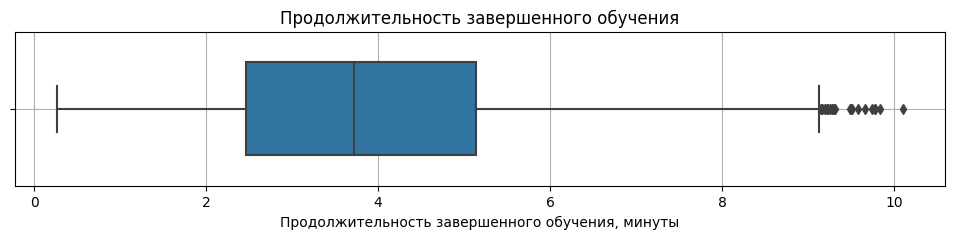

In [38]:
fig_tut_duration = plt.figure(figsize=(12, 2))
boxplot = sns.boxplot(
    data=events_tutorial,
    x='tutorial_duration',
    orient='h',
    width=0.6
)
boxplot.set_title('Продолжительность завершенного обучения');
boxplot.set_xlabel('Продолжительность завершенного обучения, минуты');
boxplot.grid();
boxplot.set_axisbelow(True);

### ВЫЯВЛЕНИЕ ОТСЕВА ПОЛЬЗОВАТЕЛЕЙ НА РАЗЛИЧНЫХ ЭТАПАХ ИГРЫ

Объединим горизонтально таблицы с событиями регистрации, level_choice, pack_choice и purchase в единую таблицу по ключу - user_id

In [39]:
#display(events_level_pack_purchase)
# Уберем из ранее подготовленной таблицы, объединяющей события level_choice, pack_choice и purchase 
    # столбцы-флаги
events_level_pack_purchase.drop(labels=['pack_before_level','purchase_before_pack','purchase_before_level'], \
    axis=1, inplace=True)

#display(events_registration_new)
# Объединим события level_choice, pack_choice и purchase (табл. events_level_pack_purchase) и события регистрации (ранее подготовленная табл. events_registration_new)
events_reg_level_pack_purchase=events_registration_new.merge(events_level_pack_purchase, how='left', \
    on='user_id')
display(events_reg_level_pack_purchase)

,user_id,registration_time,level_choice_time,pack_choice_time,purchase_time
0,27832,2018-01-01 03:48:40,NaT,NaT,NaT
1,27833,2018-01-01 04:07:25,NaT,NaT,NaT
...,...,...,...,...,...
19924,47756,2018-12-31 23:17:30,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT
19925,47757,2018-12-31 23:18:06,NaT,NaT,NaT


Определим процент пользователей, прошедших тот или иной этап игры.

In [40]:
events_reg_level_pack_purchase_cnts=pd.DataFrame(   # таблица количества пользователей на разных этапах игры
    data = [
        ['registration', events_reg_level_pack_purchase['registration_time'].count()],
        ['level_choice', events_reg_level_pack_purchase['level_choice_time'].count()],
        ['pack_choice', events_reg_level_pack_purchase['pack_choice_time'].count()],
        ['purchase', events_reg_level_pack_purchase['purchase_time'].count()],
    ],
	columns= ['passed_event', 'users_cnt'])

events_reg_level_pack_purchase_cnts['%_from_total']=round(events_reg_level_pack_purchase_cnts['users_cnt'] \
    / events_reg_level_pack_purchase_cnts['users_cnt'][0] * 100)
events_reg_level_pack_purchase_cnts['diff_with_previous_step'] \
    =events_reg_level_pack_purchase_cnts['users_cnt'].diff(periods=1) 
events_reg_level_pack_purchase_cnts['%_from_previous_step']=round(events_reg_level_pack_purchase_cnts['users_cnt'] \
    / (events_reg_level_pack_purchase_cnts['users_cnt'] \
    - events_reg_level_pack_purchase_cnts['diff_with_previous_step']) * 100)
print('Число пользователей на различных этапах игры:')
display(events_reg_level_pack_purchase_cnts)

Число пользователей на различных этапах игры:


,passed_event,users_cnt,%_from_total,diff_with_previous_step,%_from_previous_step
0,registration,19926,100.0,NaN,NaN
1,level_choice,8342,42.0,-11584.0,42.0
2,pack_choice,5737,29.0,-2605.0,69.0
3,purchase,1600,8.0,-4137.0,28.0


**ВЫВОД**:
В процентах к числу пользователей, прошедших предыдущий этап, основной отсев происходит на этапе purchase (72% отсев). Также существенный отсев (58%) проиходит после регистрации (на этапе level_choice). Отсев на этапе pack_choice небольшой (31%). 

Построим **ДИАГРАММЫ**, иллюстрирующие показанные выше цифры:

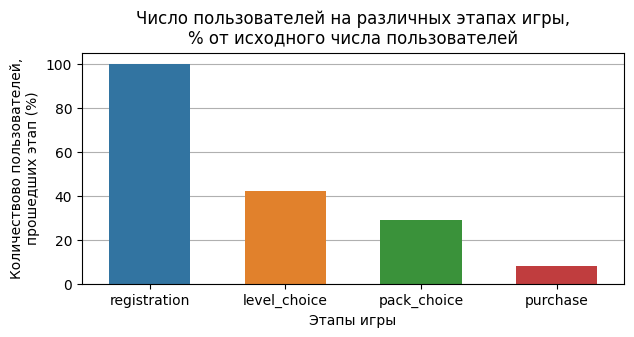

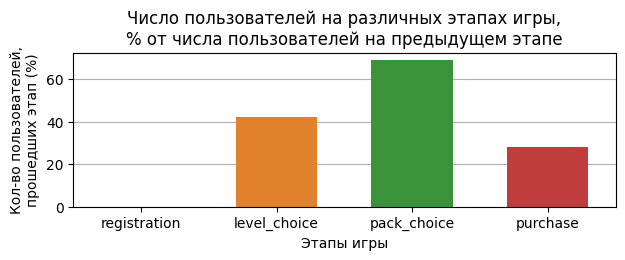

In [41]:
fig_events_reg_level_pack_purchase_cnts = plt.figure(figsize=(7, 3))
barplot = sns.barplot(
    data=events_reg_level_pack_purchase_cnts,
    x='passed_event',
    y='%_from_total',
    orient='v',
    width=0.6
)
barplot.set_title('Число пользователей на различных этапах игры,\n% от исходного числа пользователей');
barplot.set_xlabel('Этапы игры');
barplot.set_ylabel('Количествово пользователей,\nпрошедших этап (%)') #;
barplot.grid(axis='y');
barplot.set_axisbelow(True);

fig_events_reg_level_pack_purchase_cnts = plt.figure(figsize=(7, 2))
barplot = sns.barplot(
    data=events_reg_level_pack_purchase_cnts,
    x='passed_event',
    y='%_from_previous_step',
    orient='v',
    width=0.6
)
barplot.set_title('Число пользователей на различных этапах игры,\n% от числа пользователей на предыдущем этапе');
barplot.set_xlabel('Этапы игры');
barplot.set_ylabel('Кол-во пользователей,\nпрошедших этап (%)') #;
barplot.grid(axis='y');
barplot.set_axisbelow(True);

### ПОДГОТОВКА БАЗОВЫХ ТАБЛИЦ ДЛЯ АНАЛИЗА

##### Объединим горизонтально ранее полученную таблицу событий events_reg_level_pack_purchase с таблицами событий tutorial в единую таблицу all_events_matrix по ключу user_id и добавим столбцы, показывающие место событий обучения в в общей последовательности действий пользователя

Объединим таблицу событий events_reg_level_pack_purchase с таблицей событий tutorial_start

In [42]:
all_events=events_reg_level_pack_purchase.merge(events_tutorial_start_new, how='left', left_on='user_id', right_on='started_user_id').drop(labels='started_user_id', axis=1)
display(all_events)

,user_id,registration_time,level_choice_time,pack_choice_time,purchase_time,tutorial_start_time,tutorial_id
0,27832,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaN
1,27833,2018-01-01 04:07:25,NaT,NaT,NaT,2018-01-01 17:47:40,31508.0
...,...,...,...,...,...,...,...
26116,47756,2018-12-31 23:17:30,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,2019-01-01 03:26:18,49554.0
26117,47757,2018-12-31 23:18:06,NaT,NaT,NaT,NaT,NaN


Добавим столбцы-заготовки для показа место события tutorial_start в ряду других событий пользователя

In [43]:
all_events['tutstart_after_reg']    = 0    # Столбец с фактами tutorial_start после регистрации, но до level_choice (при наличии) (флаг для события обучения) 
all_events['tutstart_after_level']  = 0    # Столбец с фактами tutorial_start после level_choice, но до pack_choice (при наличии) (флаг для события обучения)
all_events['tutstart_after_pack']   = 0    # Столбец с фактами tutorial_start после pack_choice, но до оплаты (при наличии) (флаг для события обучения)
all_events['tutstart_after_purch']  = 0    # Столбец с фактами tutorial_start после оплаты (флаг для события обучения) 
display(all_events)

,user_id,registration_time,level_choice_time,pack_choice_time,purchase_time,tutorial_start_time,tutorial_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch
0,27832,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaN,0,0,0,0
1,27833,2018-01-01 04:07:25,NaT,NaT,NaT,2018-01-01 17:47:40,31508.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
26116,47756,2018-12-31 23:17:30,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,2019-01-01 03:26:18,49554.0,0,0,0,0
26117,47757,2018-12-31 23:18:06,NaT,NaT,NaT,NaT,NaN,0,0,0,0


В полученной таблице заполним столбцы, показывающие место события tutorial_start в общей последовательности действий каждого пользователя -> получим новую таблицу all_events_matrix 

In [44]:
def tutorial_start_place(row):  # Функция размещения событий tutorial_start между другими событиями
    if row['purchase_time'] < row['tutorial_start_time']:
        row['tutstart_after_purch'] = 1
    elif row['pack_choice_time'] < row['tutorial_start_time']:
        row['tutstart_after_pack'] = 1   
    elif row['level_choice_time'] < row['tutorial_start_time']:
        row['tutstart_after_level'] = 1    
    elif row['registration_time'] < row['tutorial_start_time']:
        row['tutstart_after_reg'] = 1
    return row

all_events_matrix=all_events.apply(lambda row: tutorial_start_place(row), axis=1)
display(all_events_matrix.head())

# Проверим, что все события tutorial_start учтены 
    # (что нет событий, не учтенных функцией tutorial_start_place 
    # из-за совпадения по времени событяи tutorial_start с каким-либо другим событием:)
tut_start_cnt=all_events_matrix['tutstart_after_reg'].sum() \
    + all_events_matrix['tutstart_after_level'].sum() \
    + all_events_matrix['tutstart_after_pack'].sum() + all_events_matrix['tutstart_after_purch'].sum()   
    # количество событий tutorial_start после размещения между другими событиями
events_tut_start_for_users_made_level_choice \
    =events_tutorial_start[events_tutorial_start['user_id'].isin(events_level_choice['user_id'])].shape[0]
print("Проверка: Количество событий tutorial_start из общего списка, определенного ранее, \n", 
    "равно количеству событий tutorial_start после размещения между другими событиями?   -", 
    events_tutorial_start.shape[0] == tut_start_cnt)

,user_id,registration_time,level_choice_time,pack_choice_time,purchase_time,tutorial_start_time,tutorial_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch
0,27832,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaN,0,0,0,0
1,27833,2018-01-01 04:07:25,NaT,NaT,NaT,2018-01-01 17:47:40,31508.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3,27835,2018-01-01 11:54:47,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 15:00:51,31506.0,1,0,0,0
4,27836,2018-01-01 13:28:07,NaT,NaT,NaT,2018-01-01 14:54:40,31505.0,1,0,0,0


Проверка: Количество событий tutorial_start из общего списка, определенного ранее, 
 равно количеству событий tutorial_start после размещения между другими событиями?   - True


По аналогии с событиями tutorial_start, добавим в таблицу-матрицу события tutorial_finish

In [45]:
all_events_matrix=all_events_matrix.merge(events_tutorial_finish_new, how='left', \
    left_on=['user_id','tutorial_id'], right_on=['finished_user_id','tutorial_id']) \
    .drop(labels='finished_user_id', axis=1)
all_events_matrix['tutfinish_after_reg'] = 0    # Столбец с фактми tutorial_finish после оплаты
all_events_matrix['tutfinish_after_level'] = 0  # Столбец с фактми tutorial_finish после pack_choice, но до оплаты (при наличии)
all_events_matrix['tutfinish_after_pack'] = 0   # Столбец с фактми tutorial_finish после level_choice, но до pack_choice (при наличии)
all_events_matrix['tutfinish_after_purch'] = 0  # Столбец с фактми tutorial_finish после регистрации, но до level_choice 

def tutorial_finish_place(row):  # Функция размещения событий tutorial_finish между другими событиями
    if row['purchase_time'] < row['tutorial_finish_time']:
        row['tutfinish_after_purch'] = 1
    elif row['pack_choice_time'] < row['tutorial_finish_time']:
        row['tutfinish_after_pack'] = 1   
    elif row['level_choice_time'] < row['tutorial_finish_time']:
        row['tutfinish_after_level'] = 1    
    elif row['tutorial_finish_time'] < row['level_choice_time']:
        row['tutfinish_after_reg'] = 1
    return row

all_events_matrix=all_events_matrix.apply(lambda row: tutorial_finish_place(row), axis=1)
display(all_events_matrix) 

# Проверим, что все события tutorial_finish учтены (что нет событий, не учтенных функцией tutorial_start_place из-за совпадения по времени событяи tutorial_start с каким-либо другим событием:)
tut_finish_cnt=all_events_matrix['tutfinish_after_reg'].sum() \
    + all_events_matrix['tutfinish_after_level'].sum() + all_events_matrix['tutfinish_after_pack'].sum() + all_events_matrix['tutfinish_after_purch'].sum()   # количество событий tutorial_finish после размещения между другими событиями
events_tut_finish_for_users_made_level_choice \
    =events_tutorial_finish[events_tutorial_finish['user_id'].isin(events_level_choice['user_id'])].shape[0]
print("Проверка: Количество событий tutorial_finish из общего списка, определенного ранее, \n", 
    "равно количеству событий tutorial_finish после размещения между другими событиями?   -", 
    events_tut_finish_for_users_made_level_choice == tut_finish_cnt)

,user_id,registration_time,level_choice_time,pack_choice_time,purchase_time,tutorial_start_time,tutorial_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutorial_finish_time,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch
0,27832,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaN,0,0,0,0,NaT,0,0,0,0
1,27833,2018-01-01 04:07:25,NaT,NaT,NaT,2018-01-01 17:47:40,31508.0,1,0,0,0,2018-01-01 17:50:08,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26116,47756,2018-12-31 23:17:30,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,2019-01-01 03:26:18,49554.0,1,0,0,0,2019-01-01 03:29:25,1,0,0,0
26117,47757,2018-12-31 23:18:06,NaT,NaT,NaT,NaT,NaN,0,0,0,0,NaT,0,0,0,0


Проверка: Количество событий tutorial_finish из общего списка, определенного ранее, 
 равно количеству событий tutorial_finish после размещения между другими событиями?   - True


##### Сгруппируем полученую таблицу-матрицу по user_id  и определим суммарное количество событий обучения на разных этапах игры отдельно по каждому пользователю -> новая таблица user_tutorial_cnt_matrix

Сгруппируем таблицу all_events_matrix по user_id (предварительно убрав лишние столбцы) и вычислим суммарное количество событий обучения на разных этапах игры отдельно по каждому пользователю:

In [46]:
matrix_grouped=all_events_matrix.drop(labels=['tutorial_start_time','tutorial_finish_time', \
    'registration_time','level_choice_time','pack_choice_time','purchase_time','tutorial_id'], axis=1) \
    .groupby(['user_id'], axis=0, as_index=False)
user_tutorial_cnt_matrix=matrix_grouped.sum()
display(user_tutorial_cnt_matrix)

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch
0,27832,0,0,0,0,0,0,0,0
1,27833,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,1,0,0,0
19925,47757,0,0,0,0,0,0,0,0


In [47]:
pd.set_option('display.max_rows', 9)
print("Посмотрим на распределение событий обучения по этапам игры:\n")
print(user_tutorial_cnt_matrix.drop(labels='user_id', axis=1, inplace=False).sum())
pd.set_option('display.max_rows', 4)

Посмотрим на распределение событий обучения по этапам игры:

tutstart_after_reg       15258
tutstart_after_level       941
tutstart_after_pack       1847
tutstart_after_purch         4
tutfinish_after_reg       8549
tutfinish_after_level      766
tutfinish_after_pack      1531
tutfinish_after_purch        3
dtype: int64


Добавим в таблицу-матрицу user_tutorial_cnt_matrix столбец, показывающий количество незаконченных обучений на этапе level_choice по каждому пользователю:

In [48]:
user_tutorial_cnt_matrix['tut_notfinish_after_reg']=user_tutorial_cnt_matrix['tutstart_after_reg'] \
    - user_tutorial_cnt_matrix['tutfinish_after_reg']
display(user_tutorial_cnt_matrix)
print('Число пользователей (справа), не закончивших обучение X (слева) раз:')
display(user_tutorial_cnt_matrix['tut_notfinish_after_reg'].value_counts())



,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg
0,27832,0,0,0,0,0,0,0,0,0
1,27833,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,1,0,0,0,0
19925,47757,0,0,0,0,0,0,0,0,0


Число пользователей (справа), не закончивших обучение X (слева) раз:


0    15073
1     3951
     ...  
8       23
7       21
Name: tut_notfinish_after_reg, Length: 10, dtype: int64

### ПРОХОЖДЕНИЕ ЭТАПА LEVEL_CHOICE (от регистрации до level_choice включительно)

#### Подготовка таблиц для анализа

Объеденим горизонтально таблицу со временем всех событий, кроме обучения (events_reg_level_pack_purchase), с полученной мартицей обучения (user_tutorial_cnt_matrix) и получим новую таблицу events_time_plus_tutorial_matrix

In [49]:
events_time_plus_tutorial_matrix=user_tutorial_cnt_matrix.merge(events_reg_level_pack_purchase, \
    how='inner', on=['user_id'])
display(events_time_plus_tutorial_matrix)

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg,registration_time,level_choice_time,pack_choice_time,purchase_time
0,27832,0,0,0,0,0,0,0,0,0,2018-01-01 03:48:40,NaT,NaT,NaT
1,27833,1,0,0,0,0,0,0,0,1,2018-01-01 04:07:25,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,1,0,0,0,0,2018-12-31 23:17:30,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT
19925,47757,0,0,0,0,0,0,0,0,0,2018-12-31 23:18:06,NaT,NaT,NaT


Добавим столбец, показывающий разницу во времени между событиями level_choice и регистрацией

In [50]:
events_time_plus_tutorial_matrix['level-reg_diff']=events_time_plus_tutorial_matrix['level_choice_time'] \
    - events_time_plus_tutorial_matrix['registration_time']
#display(events_time_plus_tutorial_matrix)
events_time_plus_tutorial_matrix['level-reg_diff'] \
    =events_time_plus_tutorial_matrix['level-reg_diff'].dt.total_seconds() / 3600  # пересчет времени в часы
display(events_time_plus_tutorial_matrix)

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg,registration_time,level_choice_time,pack_choice_time,purchase_time,level-reg_diff
0,27832,0,0,0,0,0,0,0,0,0,2018-01-01 03:48:40,NaT,NaT,NaT,NaN
1,27833,1,0,0,0,0,0,0,0,1,2018-01-01 04:07:25,NaT,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,1,0,0,0,0,2018-12-31 23:17:30,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,6.411389
19925,47757,0,0,0,0,0,0,0,0,0,2018-12-31 23:18:06,NaT,NaT,NaT,NaN


Добавим столбец-флаг, показывающий совершил ли пользователь событие level_choice

In [51]:
events_time_plus_tutorial_matrix['level_isna']=events_time_plus_tutorial_matrix['level_choice_time'].isna()
display(events_time_plus_tutorial_matrix)

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg,registration_time,level_choice_time,pack_choice_time,purchase_time,level-reg_diff,level_isna
0,27832,0,0,0,0,0,0,0,0,0,2018-01-01 03:48:40,NaT,NaT,NaT,NaN,True
1,27833,1,0,0,0,0,0,0,0,1,2018-01-01 04:07:25,NaT,NaT,NaT,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,1,0,0,0,0,2018-12-31 23:17:30,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,6.411389,False
19925,47757,0,0,0,0,0,0,0,0,0,2018-12-31 23:18:06,NaT,NaT,NaT,NaN,True


#### Определим взамосвязь между прохождением обучения (полностью или частично) и **фактом** прохождения этапа level_choice

Разобьем пользователей на группы по количеству завершенных обучений до события level_choice и факту прохождения этапа level_choice, и определим для каждой группы количество пользователей и медианное время прохождения этапа level_choice -> новая таблица users_distrib_after_reg_**l1**

In [52]:
users_distrib_after_reg_l1=events_time_plus_tutorial_matrix.groupby \
    (['level_isna','tutfinish_after_reg'], axis=0, as_index=False)
users_distrib_after_reg_l1=users_distrib_after_reg_l1.aggregate \
    ({'user_id':'count', 'level-reg_diff':'median'})
users_distrib_after_reg_l1.rename\
    (columns={'user_id':'user_id_cnt', 'level-reg_diff':'reg-level_time_median'}, inplace=True)
pd.set_option('display.max_rows', 10)
display(users_distrib_after_reg_l1)

,level_isna,tutfinish_after_reg,user_id_cnt,reg-level_time_median
0,False,0,841,7.062778
1,False,1,6784,6.197361
2,False,2,510,4.954028
3,False,3,122,4.500417
4,False,4,56,4.801944
5,False,5,20,5.189722
6,False,6,8,4.722778
7,False,7,1,4.926944
8,True,0,11584,NaN


**Промежуточный вывод:** Все пользователи, не прошедшие этап level_choice, не завершили ни одного обучения.

Дополнительно разобъем полученные группы на подгруппы по количеству **не**завершенных обучений до события level_choice и определим количество пользователей в каждой группе -> новая таблица users_distrib_after_reg_**l2**

In [53]:
users_distrib_after_reg_l2=events_time_plus_tutorial_matrix.groupby \
    (['level_isna','tutfinish_after_reg','tut_notfinish_after_reg'], axis=0, as_index=False)
users_distrib_after_reg_l2=users_distrib_after_reg_l2.aggregate \
    ({'user_id':'count', 'level-reg_diff':'median'})
users_distrib_after_reg_l2.rename \
    (columns={'user_id':'user_id_cnt', 'level-reg_diff':'reg-level_time_median'}, inplace=True)
pd.set_option('display.max_rows', 40)
display(users_distrib_after_reg_l2)
pd.set_option('display.max_rows', 4)

,level_isna,tutfinish_after_reg,tut_notfinish_after_reg,user_id_cnt,reg-level_time_median
0,False,0,0,98,4.934861
1,False,0,1,730,7.357222
2,False,0,2,13,5.171111
3,False,1,0,6450,6.189583
4,False,1,1,302,6.432917
5,False,1,2,25,5.800278
6,False,1,3,7,5.385556
7,False,2,0,419,4.995278
8,False,2,1,74,4.449722
9,False,2,2,11,5.130833


**Промежуточные выводы:** 
1. Все пользователи, не прошедшие этап level_choice, не завершили ни одного обучения, и в большинстве случаев даже не начинали обучение.
2. Все пользователи, завершившие хотя бы одно обучение, прошли этап level_choice.
3. При этом часть пользователей, не завершивших, а иногда даже и не начавших, ни одного обучения, все-таки прошла этап level_choice.

Составим списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до level_choice.
Первым числом в каждом списке будет количество пользователей, прошедших level_choice, вторым числом - количество пользователей непрошедших level_choice.
При этом, базируясь на визуальном изучении предыдущей таблицы (users_distrib_after_reg_l2) и сделанном выводе, выделим следующие варианты:
- количество завершенных обучений - 0 и >=1;
- количество незавершенных обучений только при отсутсвии завершенных - 0, 1, 2 и >=3.

In [54]:
tutfinished0_tutsarted0_after_reg_passed=[]
tutfinished0_tutsarted0_after_reg_passed.append(users_distrib_after_reg_l2[ \
    (users_distrib_after_reg_l2['tutfinish_after_reg']==0) \
    & (users_distrib_after_reg_l2['tut_notfinish_after_reg']==0) \
    & (~users_distrib_after_reg_l2['level_isna'])]['user_id_cnt'].sum())
tutfinished0_tutsarted0_after_reg_passed.append \
    (users_distrib_after_reg_l2[(users_distrib_after_reg_l2['tutfinish_after_reg']==0) \
    & (users_distrib_after_reg_l2['tut_notfinish_after_reg']==0) \
    & (users_distrib_after_reg_l2['level_isna'])]['user_id_cnt'].sum())

tutfinished0_tutsarted1_after_reg_passed=[]
tutfinished0_tutsarted1_after_reg_passed.append(users_distrib_after_reg_l2[ \
    (users_distrib_after_reg_l2['tutfinish_after_reg']==0) \
    & (users_distrib_after_reg_l2['tut_notfinish_after_reg']==1) \
    & (~users_distrib_after_reg_l2['level_isna'])]['user_id_cnt'].sum())
tutfinished0_tutsarted1_after_reg_passed.append(users_distrib_after_reg_l2[ \
    (users_distrib_after_reg_l2['tutfinish_after_reg']==0) \
    & (users_distrib_after_reg_l2['tut_notfinish_after_reg']==1) \
    & (users_distrib_after_reg_l2['level_isna'])]['user_id_cnt'].sum())

tutfinished0_tutsarted2_after_reg_passed=[]
tutfinished0_tutsarted2_after_reg_passed.append(users_distrib_after_reg_l2[ \
    (users_distrib_after_reg_l2['tutfinish_after_reg']==0) \
    & (users_distrib_after_reg_l2['tut_notfinish_after_reg']==2) \
    & (~users_distrib_after_reg_l2['level_isna'])]['user_id_cnt'].sum())
tutfinished0_tutsarted2_after_reg_passed.append(users_distrib_after_reg_l2[ \
    (users_distrib_after_reg_l2['tutfinish_after_reg']==0) \
    & (users_distrib_after_reg_l2['tut_notfinish_after_reg']==2) \
    & (users_distrib_after_reg_l2['level_isna'])]['user_id_cnt'].sum())

tutfinished0_tutsarted3and_after_reg_passed=[]
tutfinished0_tutsarted3and_after_reg_passed.append(users_distrib_after_reg_l2[ \
    (users_distrib_after_reg_l2['tutfinish_after_reg']==0) \
    & (users_distrib_after_reg_l2['tut_notfinish_after_reg']>2) \
    & (~users_distrib_after_reg_l2['level_isna'])]['user_id_cnt'].sum())
tutfinished0_tutsarted3and_after_reg_passed.append(users_distrib_after_reg_l2[ \
    (users_distrib_after_reg_l2['tutfinish_after_reg']==0) \
    & (users_distrib_after_reg_l2['tut_notfinish_after_reg']>2) \
    & (users_distrib_after_reg_l2['level_isna'])]['user_id_cnt'].sum())

tutfinished1and_after_reg_passed=[]
tutfinished1and_after_reg_passed.append(users_distrib_after_reg_l2[ \
    (users_distrib_after_reg_l2['tutfinish_after_reg']>0) \
    & (~users_distrib_after_reg_l2['level_isna'])]['user_id_cnt'].sum())
tutfinished1and_after_reg_passed.append(users_distrib_after_reg_l2[ \
    (users_distrib_after_reg_l2['tutfinish_after_reg']>0) \
    & (users_distrib_after_reg_l2['level_isna'])]['user_id_cnt'].sum())
print('Списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до level_choice:')
print(tutfinished0_tutsarted0_after_reg_passed, tutfinished0_tutsarted1_after_reg_passed, 
    tutfinished0_tutsarted2_after_reg_passed, tutfinished0_tutsarted3and_after_reg_passed, 
    tutfinished1and_after_reg_passed)

Списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до level_choice:
[98, 7970] [730, 2798] [13, 476] [0, 340] [7501, 0]


Построим **ДИАГРАММЫ**, базируясь на полученных списках:

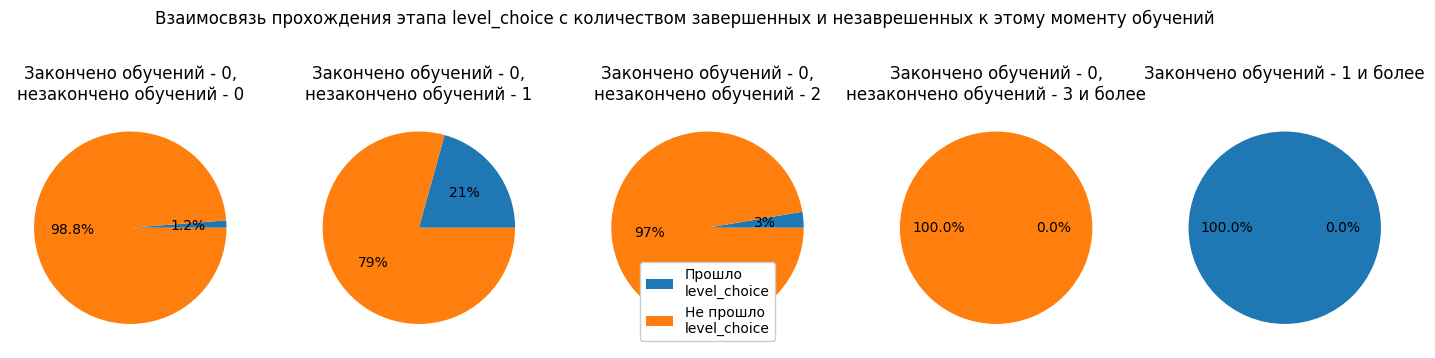

In [55]:
passing_level_choice, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 4.5))
passing_level_choice.suptitle('Взаимосвязь прохождения этапа level_choice с количеством завершенных и незаврешенных к этому моменту обучений')

axes[0].pie(
    tutfinished0_tutsarted0_after_reg_passed,
    #labels=['Прошло\nlevel_choice', 'Не прошло\nlevel_choice'],
    autopct='%.1f%%');
axes[0].set_title('Закончено обучений - 0,\nнезакончено обучений - 0');

axes[1].pie(
    tutfinished0_tutsarted1_after_reg_passed,
    #labels=['Прошло\nlevel_choice', 'Не прошло\nlevel_choice'],
    autopct='%.0f%%');
axes[1].set_title('Закончено обучений - 0,\nнезакончено обучений - 1');

axes[2].pie(
    tutfinished0_tutsarted2_after_reg_passed,
    #labels=['Прошло\nlevel_choice', 'Не прошло\nlevel_choice'],
    autopct='%.0f%%');
axes[2].set_title('Закончено обучений - 0,\nнезакончено обучений - 2');
axes[2].legend(['Прошло\nlevel_choice', 'Не прошло\nlevel_choice'], loc='lower center', framealpha=1);

axes[3].pie(
    tutfinished0_tutsarted3and_after_reg_passed,
    #labels=['Прошло\nlevel_choice', 'Не прошло\nlevel_choice'],
    autopct='%.1f%%');
axes[3].set_title('Закончено обучений - 0,\nнезакончено обучений - 3 и более');

axes[4].pie(
    tutfinished1and_after_reg_passed,
    #labels=['Прошло\nlevel_choice', 'Не прошло\nlevel_choice'],
    autopct='%.1f%%');
axes[4].set_title('Закончено обучений - 1 и более\n');

**Описание полученных результатов:** 
1. Все пользователи, завершившие хотя бы одно обучение, впоследствии прошли этап level_choice.
2. Основная масса пользователей, не завершивших обучение до level_choice, не прошли этот этап:
   - Максимальный процент (21%) прохождения level_choice наблюдается для пользователей, начавших одно обучение до level_choice.
   - При 0 или 2 начатых обучений, процент прохождения level_choice крайне незначителен (1 и 3% соответсвенно).
   - Все пользователи, начавшие 3 и более обучения, не прошли level_choice.    

**Выводы:** 
1. Определяющим фактором для прохождения этапа level_choice является завершение одного обучения. Этого достаточно и дополнительные завершенные и незавершенные обучения роли не играют.
2. При отсутсвии завершенных обучений, важно наличие одного незавершенного. Это существенно повышает шансы прохождения этапа level_choice. Дополнительные незавершенные обучения почти не сказываются на результате.

#### Определим взамосвязь между прохождением обучения (полностью или частично) и **временем** прохождения этапа level_choice

##### Для начала определим взаимосвязь времени и факта комбинаций завершенных и незавершенных обучений.

На основе таблицы-матрицы events_time_plus_tutorial_matrix создадим аналогичную таблицу, но с флагами наличия завершенных и незавершенных обучений на этапе level_choice -> таблица events_time_plus_tutorial_matrix_flags :

In [56]:
events_time_plus_tutorial_matrix_flags=events_time_plus_tutorial_matrix.copy()
events_time_plus_tutorial_matrix_flags['tutfinish_after_reg'] \
    =events_time_plus_tutorial_matrix_flags['tutfinish_after_reg'].apply(lambda q : 'Y' if q>0 else 'N')
events_time_plus_tutorial_matrix_flags['tut_notfinish_after_reg'] \
    =events_time_plus_tutorial_matrix_flags['tut_notfinish_after_reg'].apply(lambda q : 'Y' if q>0 else 'N')
display(events_time_plus_tutorial_matrix_flags)

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg,registration_time,level_choice_time,pack_choice_time,purchase_time,level-reg_diff,level_isna
0,27832,0,0,0,0,N,0,0,0,N,2018-01-01 03:48:40,NaT,NaT,NaT,NaN,True
1,27833,1,0,0,0,N,0,0,0,Y,2018-01-01 04:07:25,NaT,NaT,NaT,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,Y,0,0,0,N,2018-12-31 23:17:30,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,6.411389,False
19925,47757,0,0,0,0,N,0,0,0,N,2018-12-31 23:18:06,NaT,NaT,NaT,NaN,True


Сгруппируем пользователей полученной таблицы по факту наличия завершенных и незавершенных обучений на этапе level_choice -> таблица users_distrib_total_after_reg, и на основе :

In [57]:
users_distrib_total_after_reg=events_time_plus_tutorial_matrix_flags.groupby( \
    ['level_isna','tutfinish_after_reg', 'tut_notfinish_after_reg'], axis=0, as_index=False)
users_distrib_total_after_reg=users_distrib_total_after_reg.aggregate( \
    {'user_id':'count', 'level-reg_diff':'median'})
users_distrib_total_after_reg.rename( \
    columns={'user_id':'user_id_cnt', 'level-reg_diff':'reg-level_time_median'}, inplace=True)
users_distrib_total_after_reg_cool=users_distrib_total_after_reg.copy()
users_distrib_total_after_reg_cool['reg-level_time_median'] \
    =round(users_distrib_total_after_reg_cool['reg-level_time_median'],1)
print('Медианное время (в часах) прохождения этапа level_choice в зависимости от факта наличия завершенных и незавершенных обучений:')
pd.set_option('display.max_rows', 6)
display(users_distrib_total_after_reg_cool)
pd.set_option('display.max_rows', 4)

Медианное время (в часах) прохождения этапа level_choice в зависимости от факта наличия завершенных и незавершенных обучений:


,level_isna,tutfinish_after_reg,tut_notfinish_after_reg,user_id_cnt,reg-level_time_median
0,False,N,N,98,4.9
1,False,N,Y,743,7.3
2,False,Y,N,7005,6.0
3,False,Y,Y,496,5.6
4,True,N,N,7970,NaN
5,True,N,Y,3614,NaN


Построим **ДИАГРАММУ** на основе таблицы users_distrib_total_after_reg :

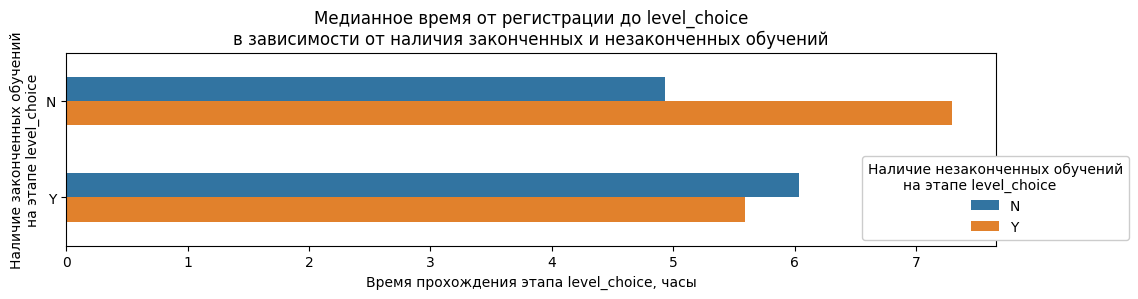

In [58]:
fig_users_distrib_total_after_reg = plt.figure(figsize=(12, 2.5))
barplot = sns.barplot(
    data=users_distrib_total_after_reg[~users_distrib_total_after_reg['level_isna']],
    x='reg-level_time_median',
    y='tutfinish_after_reg',
    hue='tut_notfinish_after_reg',
    orient='h',
    width=0.5
)
barplot.set_title('Медианное время от регистрации до level_choice\nв зависимости от наличия законченных и незаконченных обучений');
barplot.set_xlabel('Время прохождения этапа level_choice, часы');
barplot.set_ylabel('Наличие законченных обучений\nна этапе level_choice');
barplot.legend(title='Наличие незаконченных обучений\n        на этапе level_choice', bbox_to_anchor=(1.15, 0.5), framealpha=1, facecolor='w');
#barplot.grid(axis='x')

**Предварительные выводы:**
- Быстрее всего этап level_choice проходят те, кто вообще не проходил обучение. Однако мы поним, что шансы пройти этап у них минимальны (1%, см. предыдущую диаграмму).
  - Наличие незаконченных обучений при отсутсвии законченных приводит к максимальному времени прохождения этапа. При этом помним, что шансов пройти этап у таких пользователей тоже невелики (21%).
- Наличие законченных обучений увеличивает время прохождения этапа. Зато гарантирует факт прохождения (100%).
  - Наличие незаконченных обучений в дополнение к законченным приводит к небольшому уменьшению времени прохождения этапа.

##### Для дальнейшего более детального анализа отсечем те группы, в которых слишком мало пользователей
Оставим только те группы, в которых состоит не менее 10 пользователей.

Добавим к таблицам групп users_distrib_after_reg_l... столбец-заготовку флага (valid), показывающий удовлетворяет ли группа обозначенному выше условию:

In [59]:
users_distrib_after_reg_l1['valid']=False
display(users_distrib_after_reg_l1)
users_distrib_after_reg_l2['valid']=False
display(users_distrib_after_reg_l2)

,level_isna,tutfinish_after_reg,user_id_cnt,reg-level_time_median,valid
0,False,0,841,7.062778,False
1,False,1,6784,6.197361,False
...,...,...,...,...,...
7,False,7,1,4.926944,False
8,True,0,11584,NaN,False


,level_isna,tutfinish_after_reg,tut_notfinish_after_reg,user_id_cnt,reg-level_time_median,valid
0,False,0,0,98,4.934861,False
1,False,0,1,730,7.357222,False
...,...,...,...,...,...,...
35,True,0,8,23,NaN,False
36,True,0,9,27,NaN,False


Определим функцию, устанавливающую флаги удовлетворения условию (кол-во пользователей в группе >=10), и применим эту функцию к таблице групп завершенного обучения (users_distrib_after_reg_l1) -> получим таблицу events_level_tutorial_matrix_l1_valid :

In [60]:
def stat_validation(row, users_n):
    #if row['user_id_cnt'] >= users_n/400 and row['user_id_cnt'] >= 20:
    if row['user_id_cnt'] >= 10:
        row['valid']=True 
    return row

events_level_tutorial_matrix_l1_valid=users_distrib_after_reg_l1.apply( \
    lambda row: stat_validation(row, users_distrib_after_reg_l1['user_id_cnt'].sum()), axis=1)
pd.set_option('display.max_rows', 10)
display(events_level_tutorial_matrix_l1_valid)
pd.set_option('display.max_rows', 4)

,level_isna,tutfinish_after_reg,user_id_cnt,reg-level_time_median,valid
0,False,0,841,7.062778,True
1,False,1,6784,6.197361,True
2,False,2,510,4.954028,True
3,False,3,122,4.500417,True
4,False,4,56,4.801944,True
5,False,5,20,5.189722,True
6,False,6,8,4.722778,False
7,False,7,1,4.926944,False
8,True,0,11584,NaN,True


С помощью полученной таблицы валидных групп пользователей events_level_tutorial_matrix_l1_valid оставим в таблице-матрице обучения и времени событий (events_time_plus_tutorial_matrix) только пользователей из валидных групп и получим новую итоговую таблицу events_time_plus_tutorial_matrix_for_level_l1 для расчета статистических показателей и построения диаграмм **взаимосвязи количества законченных обучений и времени прохождения этапа level_choice**:

In [61]:
events_time_plus_tutorial_matrix_for_level_l1=events_time_plus_tutorial_matrix[ \
    events_time_plus_tutorial_matrix['tutfinish_after_reg'].isin( \
    list(events_level_tutorial_matrix_l1_valid[ \
    events_level_tutorial_matrix_l1_valid['valid']]['tutfinish_after_reg']))]
display(events_time_plus_tutorial_matrix_for_level_l1)

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg,registration_time,level_choice_time,pack_choice_time,purchase_time,level-reg_diff,level_isna
0,27832,0,0,0,0,0,0,0,0,0,2018-01-01 03:48:40,NaT,NaT,NaT,NaN,True
1,27833,1,0,0,0,0,0,0,0,1,2018-01-01 04:07:25,NaT,NaT,NaT,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,1,0,0,0,0,2018-12-31 23:17:30,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,6.411389,False
19925,47757,0,0,0,0,0,0,0,0,0,2018-12-31 23:18:06,NaT,NaT,NaT,NaN,True


Применим ту же функцию, устанавливающую флаги удовлетворения условию к таблице подгрупп незавершенного обучения (users_distrib_after_reg_l2) -> получим таблицу events_level_tutorial_matrix_l2_valid :

In [62]:
events_level_tutorial_matrix_l2_valid=users_distrib_after_reg_l2.apply( \
    lambda row: stat_validation(row, users_distrib_after_reg_l2['user_id_cnt'].sum()), axis=1)
pd.set_option('display.max_rows', 40)
display(events_level_tutorial_matrix_l2_valid)
pd.set_option('display.max_rows', 4)

,level_isna,tutfinish_after_reg,tut_notfinish_after_reg,user_id_cnt,reg-level_time_median,valid
0,False,0,0,98,4.934861,True
1,False,0,1,730,7.357222,True
2,False,0,2,13,5.171111,True
3,False,1,0,6450,6.189583,True
4,False,1,1,302,6.432917,True
5,False,1,2,25,5.800278,True
6,False,1,3,7,5.385556,False
7,False,2,0,419,4.995278,True
8,False,2,1,74,4.449722,True
9,False,2,2,11,5.130833,True


Чтобы увидеть на диаграмме не только медианное время, но и распределение времени:  
Определим функцию, добавляющую к таблице подгрупп незавершенного обучения (events_level_tutorial_matrix_l2_valid) аггрегатный столбец (both), содержащий количество пользователей как в подгруппе незавершенного обучения, так и в группе завершенного обучения, к которой она относится.
И применим эту функцию к таблице подгрупп незавершенного обучения.

In [63]:
def two_col_in_one_list(row, col1, col2):
    both=[]
    both.append(row[col1])
    both.append(row[col2])
    row['both']=both
    return row

events_level_tutorial_matrix_l2_valid=events_level_tutorial_matrix_l2_valid.apply( \
    lambda row: two_col_in_one_list(row, 'tutfinish_after_reg', 'tut_notfinish_after_reg'), axis=1)
display(events_level_tutorial_matrix_l2_valid)

,level_isna,tutfinish_after_reg,tut_notfinish_after_reg,user_id_cnt,reg-level_time_median,valid,both
0,False,0,0,98,4.934861,True,"[0, 0]"
1,False,0,1,730,7.357222,True,"[0, 1]"
...,...,...,...,...,...,...,...
35,True,0,8,23,NaN,True,"[0, 8]"
36,True,0,9,27,NaN,True,"[0, 9]"


С помощью полученной таблицы валидных групп пользователей events_level_tutorial_matrix_l2_valid оставим в таблице-матрице обучения и времени событий (events_time_plus_tutorial_matrix) только пользователей из валидных групп и получим новую итоговую таблицу events_time_plus_tutorial_matrix_for_level_l2 для расчета статистических показателей и построения диаграмм **взаимосвязи количества законченных и незаконченных обучений и времени прохождения этапа level_choice**:

In [64]:
events_time_plus_tutorial_matrix_for_level_l2=events_time_plus_tutorial_matrix[ \
    events_time_plus_tutorial_matrix.apply( \
        lambda row: two_col_in_one_list(row, 'tutfinish_after_reg', 'tut_notfinish_after_reg'), \
            axis=1)['both'].isin( \
                list(events_level_tutorial_matrix_l2_valid[events_level_tutorial_matrix_l2_valid['valid']]['both']))]
display(events_time_plus_tutorial_matrix_for_level_l2)

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg,registration_time,level_choice_time,pack_choice_time,purchase_time,level-reg_diff,level_isna
0,27832,0,0,0,0,0,0,0,0,0,2018-01-01 03:48:40,NaT,NaT,NaT,NaN,True
1,27833,1,0,0,0,0,0,0,0,1,2018-01-01 04:07:25,NaT,NaT,NaT,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,1,0,0,0,0,2018-12-31 23:17:30,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,6.411389,False
19925,47757,0,0,0,0,0,0,0,0,0,2018-12-31 23:18:06,NaT,NaT,NaT,NaN,True


##### Построим **ДИАГРАММЫ** зависимости времени прохождения этапа level_choice от количества завершенных и незавершенных обучений к моменту level_choice (на основе итоговых таблиц events_time_plus_tutorial_matrix_for_level_l...):

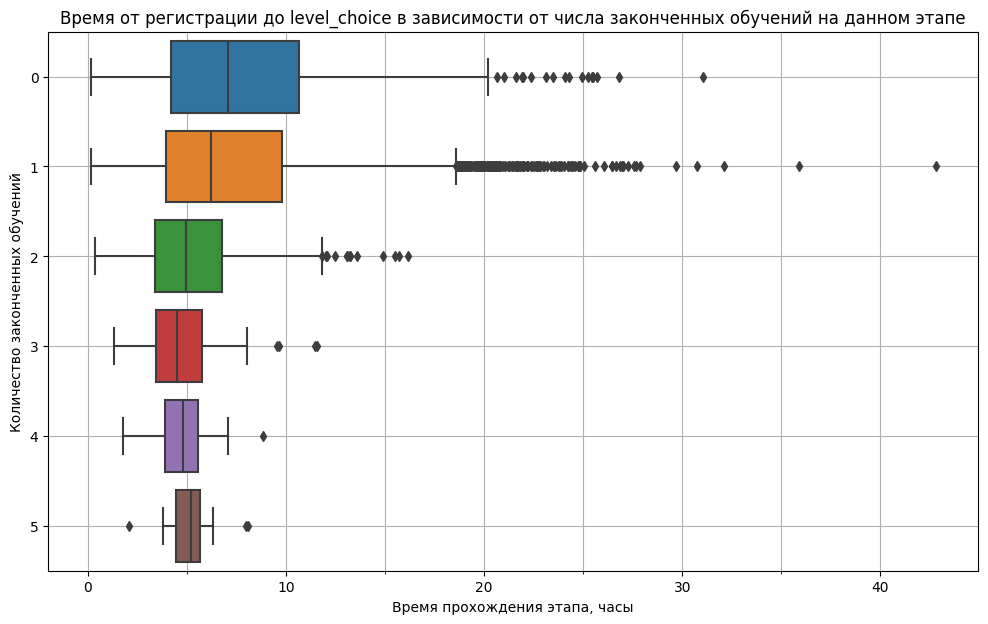

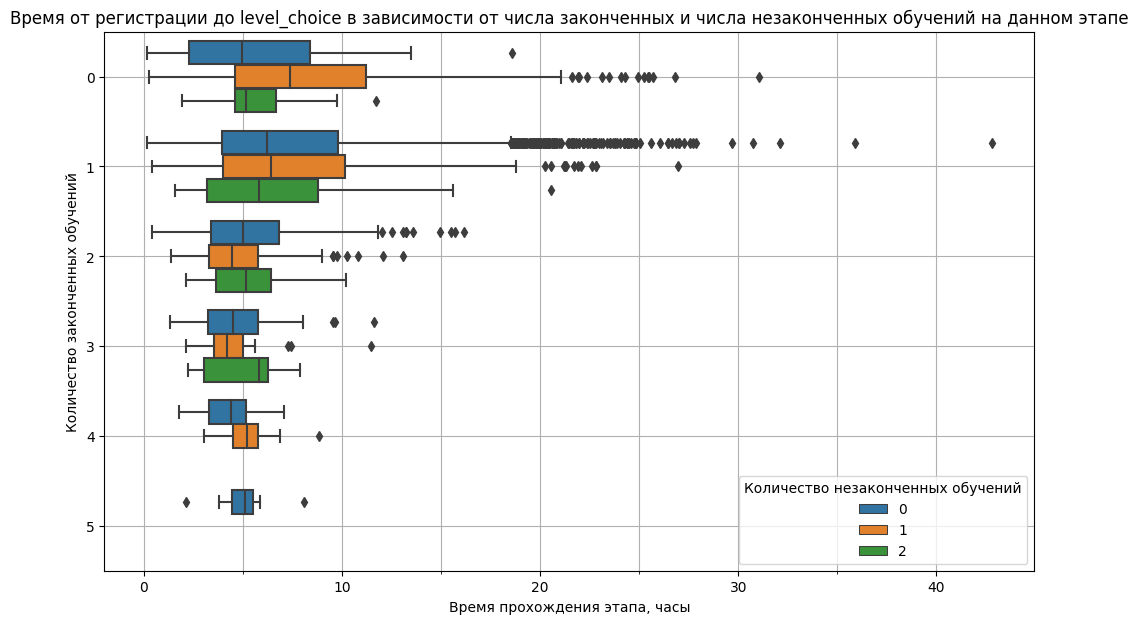

In [65]:
fig_tut_finished_after_reg = plt.figure(figsize=(12, 7))
boxplot = sns.boxplot(
    data=events_time_plus_tutorial_matrix_for_level_l1[ \
        ~events_time_plus_tutorial_matrix_for_level_l1['level_isna']],
    y='tutfinish_after_reg',
    x='level-reg_diff',
    orient='h',
    width=0.8
)
boxplot.set_title('Время от регистрации до level_choice в зависимости от числа законченных обучений на данном этапе');
boxplot.set_xlabel('Время прохождения этапа, часы');
boxplot.set_ylabel('Количество законченных обучений');
boxplot.grid(which='major');
boxplot.grid(which='minor');
boxplot.set_xticks([0,10,20,30,40], minor=False);
boxplot.set_xticks([5,15,25,35], minor=True);
#plt.savefig('plot.png', dpi=300, bbox_inches='tight');
boxplot.set_axisbelow(True);

fig_tut_notfinished_after_reg = plt.figure(figsize=(12, 7))
boxplot = sns.boxplot(
    data=events_time_plus_tutorial_matrix_for_level_l2[ \
        ~events_time_plus_tutorial_matrix_for_level_l2['level_isna']],
    y='tutfinish_after_reg',
    x='level-reg_diff',
    hue='tut_notfinish_after_reg' ,
    orient='h',
    width=0.8   
)
boxplot.set_title('Время от регистрации до level_choice в зависимости от числа законченных и числа незаконченных обучений на данном этапе');
boxplot.set_xlabel('Время прохождения этапа, часы');
boxplot.set_ylabel('Количество законченных обучений');
boxplot.grid(which='major');
boxplot.grid(which='minor');
boxplot.legend (title='Количество незаконченных обучений');
boxplot.set_xticks([0,10,20,30,40], minor=False);
boxplot.set_xticks([5,15,25,35], minor=True);
boxplot.set_axisbelow(True);


**Вывод о важности учета незавершенных обучений, особенно при отсутсвии завершенных**:   
- Наибольший межквартильный интервал, а также размах всего распределения (не считая потенциальных выбросов), наблюдаются для случая с отсутсвием завершенных обучений; при этом по количеству пользователей эта группа занимает не 1-ое место. 
  - Это объясняется тем, что при 0 завершенных обучений, важную роль играют незавершенные обучений и их количество; тогда как при наличии хотя бы одного завершенного обучения, влияние незавершенных на время прохождение этапа не велика (при этом помним помним, что влияние на факт прохожения level_choice существенно). 
- Т.о., рассматривать влияние завершенных обучений на время прохождения этапа без учета наличия незавершенных, в некоторых ситуациях было бы некоректно.

Та же информация в виде столбчатой диаграммы:

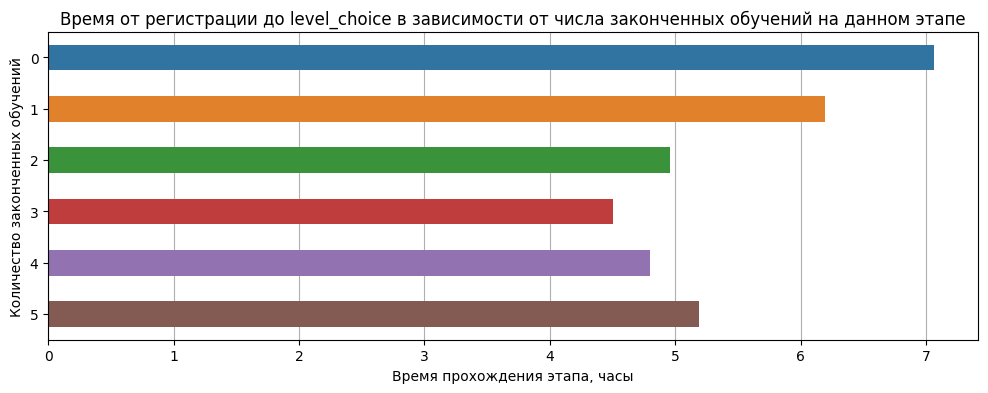

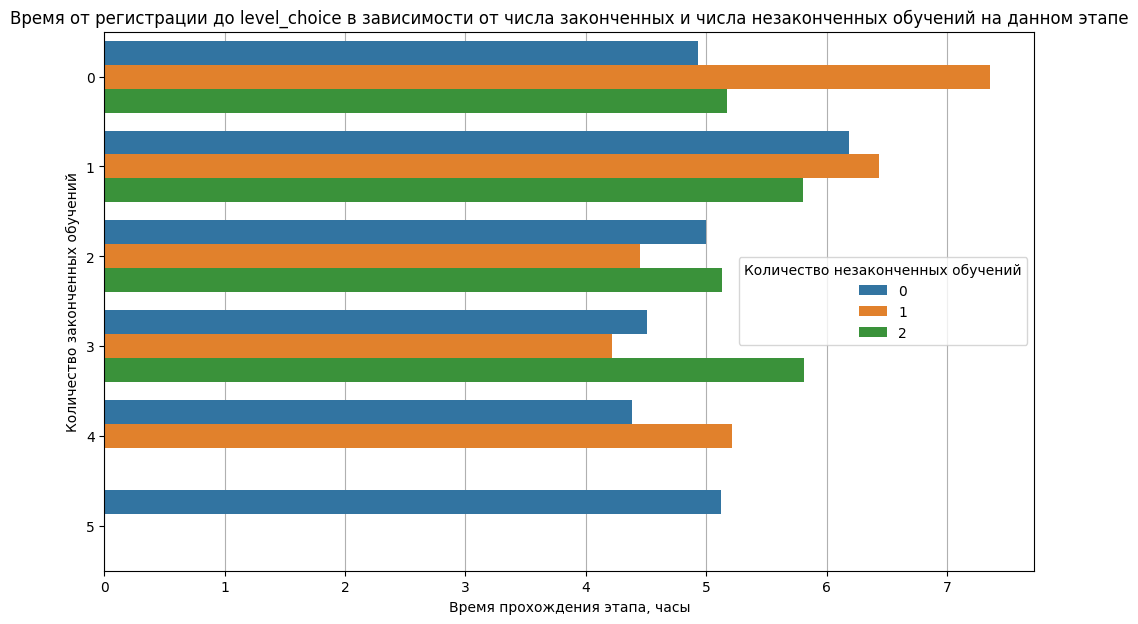

In [66]:
fig_tut_finished_after_reg = plt.figure(figsize=(12, 4))
barplot = sns.barplot(
    data=events_time_plus_tutorial_matrix_for_level_l1[ \
        ~events_time_plus_tutorial_matrix_for_level_l1['level_isna']],
    y='tutfinish_after_reg',
    x='level-reg_diff',
    orient='h',
    width=0.5,
    errorbar=None,
    estimator='median'
)
barplot.set_title('Время от регистрации до level_choice в зависимости от числа законченных обучений на данном этапе');
barplot.set_xlabel('Время прохождения этапа, часы');
barplot.set_ylabel('Количество законченных обучений');
barplot.grid(axis='x');
#barplot.grid(which='minor');
#barplot.set_xticks([0,10,20,30,40], minor=False);
#barplot.set_xticks([5,15,25,35], minor=True);
#plt.savefig('plot.png', dpi=300, bbox_inches='tight');
barplot.set_axisbelow(True);

fig_tut_notfinished_after_reg = plt.figure(figsize=(12, 7))
barplot = sns.barplot(
    data=events_time_plus_tutorial_matrix_for_level_l2[ \
        ~events_time_plus_tutorial_matrix_for_level_l2['level_isna']],
    y='tutfinish_after_reg',
    x='level-reg_diff',
    hue='tut_notfinish_after_reg' ,
    orient='h',
    width=0.8,
    errorbar=None,
    estimator='median'
)
barplot.set_title('Время от регистрации до level_choice в зависимости от числа законченных и числа незаконченных обучений на данном этапе');
barplot.set_xlabel('Время прохождения этапа, часы');
barplot.set_ylabel('Количество законченных обучений');
barplot.grid(axis='x');
#barplot.grid(which='minor');
barplot.legend (title='Количество незаконченных обучений');
#barplot.set_xticks([0,10,20,30,40], minor=False);
#barplot.set_xticks([5,15,25,35], minor=True);
barplot.set_axisbelow(True);

##### **Детальные выводы** о влиянии обучения на время прохождения этапа level_choice
1. **Пользователи вообще без обучения проходят этап со средней скоростью**, однако помним что у таких пользователей очень мало шансов пройти этап в принципе.
2. **Небольшое количество обучений увеличивает время прохождения этапа** (однако многократно повышает шансы пройти этап в принципе):
    - дольше всего этап проходят пользователи с одним незавершенным обучением (8,3 часа), а также с одним завершенным (и 0-2 незавершенных).
3. **Начиная с 2 любых обучений, каждое дополнительное (3-ее) обучение любого  типа уменьшают время, 4-ое еще больше уменьшает время**:
   - быстрее всех этап проходят пользователи с 3 завершенными и 1 незавершенным обучениями (4,2 часа), а также с 4 завершенными.
4. **Слишком большое количество обучений увеличивает время прохождения этапа**:
   - 5-ое обучение (любого типа) увеличивает время прохождения этапа.

- Также может оказаться важным какие обучения шли у пользователя раньше - завершенные или незавершенные, однако для исследования этого вопроса количества пользователей в подгруппах определенно недостаточно.  
Но в любом случае очевидно, что **количество незавершенных обучений очень сильно влияет на время прохождения этапа** для пользователей с одинаковым количеством завершенных обучений.

Также может оказаться важным какие обучения шли у пользователя раньше - завершенные или незавершенные, однако для исследования этого вопроса количества пользователей в подгруппах определенно недостаточно.  
Но в любом случае очевидно, что **количество незавершенных обучений очень сильно влияет на время прохождения этапа** для пользователей с одинаковым количеством завершенных обучений.

Приведем еще раз медианное время прохождения этапа level_choice **в завимости от количества завершенных и незавершенных на этом этапе обучений**:

In [67]:
level_choice_vs_tutorial1_cool=events_level_tutorial_matrix_l1_valid[ \
    events_level_tutorial_matrix_l1_valid['valid'] \
    & ~events_level_tutorial_matrix_l1_valid['level_isna']].drop( \
    labels=['level_isna','user_id_cnt','valid'], axis=1).rename( \
    columns={'tutfinish_after_reg':'Number of tutorials, finished before level_choice', \
        'reg-level_time_median': 'Median time of registration - level_choice phase (hours)'})
level_choice_vs_tutorial1_cool['Median time of registration - level_choice phase (hours)'] \
    =round(level_choice_vs_tutorial1_cool['Median time of registration - level_choice phase (hours)'], 1)
print('Медианное время от регистрации до level_choice в зависимости от числа законченных обучений на данном этапе:')
pd.set_option('display.max_rows', 15)
display(level_choice_vs_tutorial1_cool)

level_choice_vs_tutorial2_cool=events_level_tutorial_matrix_l2_valid[ \
    events_level_tutorial_matrix_l2_valid['valid'] \
    & ~events_level_tutorial_matrix_l2_valid['level_isna']].drop( \
    labels=['level_isna','user_id_cnt','valid','both'], axis=1).rename( \
    columns={'tutfinish_after_reg':'Number of tutorials, finished before level_choice', \
        'reg-level_time_median': 'Median time of registration - level_choice phase (hours)', \
            'tut_notfinish_after_reg': 'Number of tutorials, not finished before level_choice'})
level_choice_vs_tutorial2_cool['Median time of registration - level_choice phase (hours)'] \
    =round(level_choice_vs_tutorial2_cool['Median time of registration - level_choice phase (hours)'], 1)
print('Медианное время от регистрации до level_choice в зависимости от числа законченных и незаконченных обучений на данном этапе:')
display(level_choice_vs_tutorial2_cool)
pd.set_option('display.max_rows', 4)

Медианное время от регистрации до level_choice в зависимости от числа законченных обучений на данном этапе:


,"Number of tutorials, finished before level_choice",Median time of registration - level_choice phase (hours)
0,0,7.1
1,1,6.2
2,2,5.0
3,3,4.5
4,4,4.8
5,5,5.2


Медианное время от регистрации до level_choice в зависимости от числа законченных и незаконченных обучений на данном этапе:


,"Number of tutorials, finished before level_choice","Number of tutorials, not finished before level_choice",Median time of registration - level_choice phase (hours)
0,0,0,4.9
1,0,1,7.4
2,0,2,5.2
3,1,0,6.2
4,1,1,6.4
5,1,2,5.8
7,2,0,5.0
8,2,1,4.4
9,2,2,5.1
12,3,0,4.5


### ПРОХОЖДЕНИЕ ЭТАПА PACK_CHOICE (от level_choice до pack_choice включительно)

#### Подготовка таблиц для анализа

Будем использовать ранее полученную таблицу events_time_plus_tutorial_matrix.

Подобно тому, как мы делали это для этапа level_choice, добавим столбцы, показывающие:
- столбец, показывающий разницу во времени между событиями pack_choice и level_choice;
- столбец, показывающий разницу во времени между событиями регистрацией и level_choice;
- столбец-флаг, показывающий совершил ли пользователь событие pack_choice.

In [68]:
events_time_plus_tutorial_matrix['pack-level_diff']=events_time_plus_tutorial_matrix['pack_choice_time'] \
    - events_time_plus_tutorial_matrix['level_choice_time']
events_time_plus_tutorial_matrix['pack-level_diff'] \
    =events_time_plus_tutorial_matrix['pack-level_diff'].dt.total_seconds() / 3600  # пересчет времени в часы
events_time_plus_tutorial_matrix['pack-reg_diff']=events_time_plus_tutorial_matrix['pack_choice_time'] \
    - events_time_plus_tutorial_matrix['registration_time']
events_time_plus_tutorial_matrix['pack-reg_diff'] \
    =events_time_plus_tutorial_matrix['pack-reg_diff'].dt.total_seconds() / 3600  # пересчет времени в часы
events_time_plus_tutorial_matrix['pack_isna']=events_time_plus_tutorial_matrix['pack_choice_time'].isna()
display(events_time_plus_tutorial_matrix)

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg,registration_time,level_choice_time,pack_choice_time,purchase_time,level-reg_diff,level_isna,pack-level_diff,pack-reg_diff,pack_isna
0,27832,0,0,0,0,0,0,0,0,0,2018-01-01 03:48:40,NaT,NaT,NaT,NaN,True,NaN,NaN,True
1,27833,1,0,0,0,0,0,0,0,1,2018-01-01 04:07:25,NaT,NaT,NaT,NaN,True,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,1,0,0,0,0,2018-12-31 23:17:30,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,6.411389,False,0.140278,6.551667,False
19925,47757,0,0,0,0,0,0,0,0,0,2018-12-31 23:18:06,NaT,NaT,NaT,NaN,True,NaN,NaN,True


Добавим столбец, показывающий суммарное количество событий обучения каждого пользователя с момента регистрации и до pack_choice:

In [69]:
events_time_plus_tutorial_matrix['tutstart_before_pack'] \
    =events_time_plus_tutorial_matrix['tutstart_after_reg'] \
        + events_time_plus_tutorial_matrix['tutstart_after_level']
events_time_plus_tutorial_matrix['tutfinish_before_pack'] \
    =events_time_plus_tutorial_matrix['tutfinish_after_reg'] \
        + events_time_plus_tutorial_matrix['tutfinish_after_level']
display(events_time_plus_tutorial_matrix)

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg,...,level_choice_time,pack_choice_time,purchase_time,level-reg_diff,level_isna,pack-level_diff,pack-reg_diff,pack_isna,tutstart_before_pack,tutfinish_before_pack
0,27832,0,0,0,0,0,0,0,0,0,...,NaT,NaT,NaT,NaN,True,NaN,NaN,True,0,0
1,27833,1,0,0,0,0,0,0,0,1,...,NaT,NaT,NaT,NaN,True,NaN,NaN,True,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,1,0,0,0,0,...,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,6.411389,False,0.140278,6.551667,False,1,1
19925,47757,0,0,0,0,0,0,0,0,0,...,NaT,NaT,NaT,NaN,True,NaN,NaN,True,0,0


Добавим столбец, показывающий суммарное количество незаконченных обучений **с момента регистрации и до pack_choice**:

In [70]:
events_time_plus_tutorial_matrix['tut_notfinish_before_pack'] \
    =events_time_plus_tutorial_matrix['tutstart_before_pack'] \
        - events_time_plus_tutorial_matrix['tutfinish_before_pack']
display(events_time_plus_tutorial_matrix)

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg,...,pack_choice_time,purchase_time,level-reg_diff,level_isna,pack-level_diff,pack-reg_diff,pack_isna,tutstart_before_pack,tutfinish_before_pack,tut_notfinish_before_pack
0,27832,0,0,0,0,0,0,0,0,0,...,NaT,NaT,NaN,True,NaN,NaN,True,0,0,0
1,27833,1,0,0,0,0,0,0,0,1,...,NaT,NaT,NaN,True,NaN,NaN,True,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,1,0,0,0,0,...,2019-01-01 05:50:36,NaT,6.411389,False,0.140278,6.551667,False,1,1,0
19925,47757,0,0,0,0,0,0,0,0,0,...,NaT,NaT,NaN,True,NaN,NaN,True,0,0,0


#### Определим взамосвязь между прохождением обучения (полностью или частично) и **фактом** прохождения этапа pack_choice

Разобьем пользователей на группы по количеству завершенных обучений до события pack_choice и факту прохождения этапа pack_choice, и определим для каждой группы количество пользователей и медианное время прохождения этапа pack_choice -> новая таблица users_distrib_after_reg_to_pack_l1

In [71]:
users_distrib_after_reg_to_pack_l1=events_time_plus_tutorial_matrix.groupby( \
    ['level_isna','pack_isna','tutfinish_before_pack'], axis=0, as_index=False)
users_distrib_after_reg_to_pack_l1=users_distrib_after_reg_to_pack_l1.aggregate( \
    {'user_id':'count', 'pack-level_diff':'median', 'pack-reg_diff':'median'})
users_distrib_after_reg_to_pack_l1.rename( \
    columns={'user_id':'user_id_cnt', 'pack-level_diff':'level-pack_time_median', \
        'pack-reg_diff':'reg-pack_time_median'}, inplace=True)
pd.set_option('display.max_rows', 20)
display(users_distrib_after_reg_to_pack_l1)

,level_isna,pack_isna,tutfinish_before_pack,user_id_cnt,level-pack_time_median,reg-pack_time_median
0,False,False,0,561,0.080000,7.134444
1,False,False,1,4664,0.083056,6.297222
2,False,False,2,365,0.084444,5.045556
3,False,False,3,85,0.074167,4.487222
4,False,False,4,39,0.056111,5.100278
5,False,False,5,15,0.064444,5.171944
6,False,False,6,7,0.071667,4.964444
7,False,False,7,1,0.104167,5.031111
8,False,True,0,280,NaN,NaN
9,False,True,1,1817,NaN,NaN


**Промежуточные выводы:**
1. Большинство пользователей, не прошедших этап pack_choice, не завершили ни одного обучения (бо'льшая их часть отсеялась еще на этапе level_choice).
2. В отличие от этапа level_choice, на этапе pack_choice отсеялось и пользователи с пройденным обучением (восновном с одним).

Разобьем пользователей на группы по факту прохождения этапа pack_choice и по количеству завершенных обучений до события level_choice, и затем на подгруппы по числу завершенных обучений между level_ и pack_choice , и определим для каждой группы количество пользователей и медианное время прохождения этапа pack_choice -> новая таблица users_distrib_after_reg_to_pack_l1_details:

In [72]:
users_distrib_after_reg_to_pack_l1_details=events_time_plus_tutorial_matrix.groupby( \
    ['pack_isna','tutfinish_after_reg', 'tutfinish_after_level'], axis=0, as_index=False)
users_distrib_after_reg_to_pack_l1_details=users_distrib_after_reg_to_pack_l1_details.aggregate( \
    {'user_id':'count', 'pack-level_diff':'median', 'pack-reg_diff':'median'})
users_distrib_after_reg_to_pack_l1_details.rename( \
    columns={'user_id':'user_id_cnt', 'pack-level_diff':'level-pack_time_median', \
        'pack-reg_diff':'reg-pack_time_median'}, inplace=True)
pd.set_option('display.max_rows', 45)
display(users_distrib_after_reg_to_pack_l1_details)

,pack_isna,tutfinish_after_reg,tutfinish_after_level,user_id_cnt,level-pack_time_median,reg-pack_time_median
0,False,0,0,561,0.080000,7.134444
1,False,1,0,4664,0.083056,6.297222
2,False,1,1,13,0.123611,4.024167
3,False,2,0,352,0.084028,5.057361
4,False,2,1,7,0.078333,2.784167
5,False,3,0,78,0.074028,4.616111
6,False,3,1,1,0.046389,2.366111
7,False,4,0,38,0.060556,5.176667
8,False,5,0,15,0.064444,5.171944
9,False,6,0,7,0.071667,4.964444


**Промежуточные выводы:** 
1. *Большинство пользователей, не прошедших этап pack_choice, не завершили ни одного обучения (бо'льшая их часть отсеялась еще на этапе level_choice).*
2. *В отличие от этапа level_choice, на этапе pack_choice отсеялось и пользователи с пройденным обучением (восновном с одним).*
3. Все пользователи, не закончившие ни одного обучения на этапе level_choice, также не закончили ни одного обучения на этапе pack_choice.

Дополнительно разобъем полученные группы на подгруппы по количеству **не**завершенных обучений до события pack_choice и определим количество пользователей в каждой группе -> новая таблица users_distrib_after_reg_to_pack**l2**  
*Во избежание чрезмерного дробения групп, при учете незавершенных обучений не будем разделять завершенные на этапы.*

In [73]:
users_distrib_after_reg_to_pack_l2=events_time_plus_tutorial_matrix.groupby( \
    ['level_isna','pack_isna','tutfinish_before_pack','tut_notfinish_before_pack'], axis=0, as_index=False)
users_distrib_after_reg_to_pack_l2=users_distrib_after_reg_to_pack_l2.aggregate( \
    {'user_id':'count', 'pack-level_diff':'median', 'pack-reg_diff':'median'})
users_distrib_after_reg_to_pack_l2.rename( \
    columns={'user_id':'user_id_cnt', 'pack-level_diff':'level-pack_time_median', \
        'pack-reg_diff':'reg-pack_time_median'}, inplace=True)
pd.set_option('display.max_rows', 72)
display(users_distrib_after_reg_to_pack_l2)

,level_isna,pack_isna,tutfinish_before_pack,tut_notfinish_before_pack,user_id_cnt,level-pack_time_median,reg-pack_time_median
0,False,False,0,0,74,0.079583,4.768333
1,False,False,0,1,478,0.079583,7.547222
2,False,False,0,2,9,0.101389,5.245000
3,False,False,1,0,4431,0.083333,6.298333
4,False,False,1,1,207,0.073889,6.238889
5,False,False,1,2,18,0.084583,7.167083
6,False,False,1,3,8,0.084583,5.003611
7,False,False,2,0,302,0.083889,5.068333
8,False,False,2,1,50,0.093056,4.512639
9,False,False,2,2,8,0.100694,5.320972


Составим списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до pack_choice.
Первым числом в каждом списке будет количество пользователей, прошедших pack_choice, вторым числом - количество пользователей непрошедших pack_choice.
При этом, базируясь на выводе по этапу level_choice (при наличии хотя бы одного завершенного обучения, незавершенные обучения не важны, а при отсутствии завершенных важно наличие хотя бы одного незавершенного), выделим следующие варианты:
- количество завершенных обучений к моменту pack_choice - 0 и >=1;
- количество незавершенных обучений только при отсутсвии завершенных - 0 и >=1.

При этом составим такие списки отдельно:
- для всех зарегестрированных пользователей;
- только для тех, кто прошел level_choice.

In [74]:
tutfinished0_tutsarted0_before_pack_all=[]
tutfinished0_tutsarted0_before_pack_all.append(users_distrib_after_reg_to_pack_l2[ \
    (users_distrib_after_reg_to_pack_l2['tutfinish_before_pack']==0) \
        & (users_distrib_after_reg_to_pack_l2['tut_notfinish_before_pack']==0) \
            & (~users_distrib_after_reg_to_pack_l2['pack_isna'])]['user_id_cnt'].sum())
tutfinished0_tutsarted0_before_pack_all.append(users_distrib_after_reg_to_pack_l2[ \
    (users_distrib_after_reg_to_pack_l2['tutfinish_before_pack']==0) \
        & (users_distrib_after_reg_to_pack_l2['tut_notfinish_before_pack']==0) \
            & (users_distrib_after_reg_to_pack_l2['pack_isna'])]['user_id_cnt'].sum())

tutfinished0_tutsarted1and_before_pack_all=[]
tutfinished0_tutsarted1and_before_pack_all.append(users_distrib_after_reg_to_pack_l2[ \
    (users_distrib_after_reg_to_pack_l2['tutfinish_before_pack']==0) \
        & (users_distrib_after_reg_to_pack_l2['tut_notfinish_before_pack']>0) \
            & (~users_distrib_after_reg_to_pack_l2['pack_isna'])]['user_id_cnt'].sum())
tutfinished0_tutsarted1and_before_pack_all.append(users_distrib_after_reg_to_pack_l2[ \
    (users_distrib_after_reg_to_pack_l2['tutfinish_before_pack']==0) \
        & (users_distrib_after_reg_to_pack_l2['tut_notfinish_before_pack']>0) \
            & (users_distrib_after_reg_to_pack_l2['pack_isna'])]['user_id_cnt'].sum())

tutfinished1and_before_pack_all=[]
tutfinished1and_before_pack_all.append(users_distrib_after_reg_to_pack_l2[ \
    (users_distrib_after_reg_to_pack_l2['tutfinish_before_pack']>0) \
        & (~users_distrib_after_reg_to_pack_l2['pack_isna'])]['user_id_cnt'].sum())
tutfinished1and_before_pack_all.append(users_distrib_after_reg_to_pack_l2[ \
    (users_distrib_after_reg_to_pack_l2['tutfinish_before_pack']>0) \
        & (users_distrib_after_reg_to_pack_l2['pack_isna'])]['user_id_cnt'].sum())

print('Списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до pack_choice среди всех зарегестрированных:')
print(tutfinished0_tutsarted0_before_pack_all, tutfinished0_tutsarted1and_before_pack_all, \
    tutfinished1and_before_pack_all)

Списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до pack_choice среди всех зарегестрированных:
[74, 7994] [487, 3870] [5176, 2325]


In [75]:
tutfinished0_tutsarted0_before_pack_level_passed=[]
tutfinished0_tutsarted0_before_pack_level_passed.append(users_distrib_after_reg_to_pack_l2[ \
    (users_distrib_after_reg_to_pack_l2['tutfinish_before_pack']==0) \
        & (users_distrib_after_reg_to_pack_l2['tut_notfinish_before_pack']==0) \
            & (~users_distrib_after_reg_to_pack_l2['pack_isna'])]['user_id_cnt'].sum())
tutfinished0_tutsarted0_before_pack_level_passed.append(users_distrib_after_reg_to_pack_l2[ \
    (users_distrib_after_reg_to_pack_l2['tutfinish_before_pack']==0) \
        & (users_distrib_after_reg_to_pack_l2['tut_notfinish_before_pack']==0) \
            & (~users_distrib_after_reg_to_pack_l2['level_isna']) \
                & (users_distrib_after_reg_to_pack_l2['pack_isna'])]['user_id_cnt'].sum())

tutfinished0_tutsarted1and_before_pack_level_passed=[]
tutfinished0_tutsarted1and_before_pack_level_passed.append(users_distrib_after_reg_to_pack_l2[ \
    (users_distrib_after_reg_to_pack_l2['tutfinish_before_pack']==0) \
        & (users_distrib_after_reg_to_pack_l2['tut_notfinish_before_pack']>0) \
            & (~users_distrib_after_reg_to_pack_l2['pack_isna'])]['user_id_cnt'].sum())
tutfinished0_tutsarted1and_before_pack_level_passed.append(users_distrib_after_reg_to_pack_l2[ \
    (users_distrib_after_reg_to_pack_l2['tutfinish_before_pack']==0) \
        & (users_distrib_after_reg_to_pack_l2['tut_notfinish_before_pack']>0) \
            & (~users_distrib_after_reg_to_pack_l2['level_isna']) \
                & (users_distrib_after_reg_to_pack_l2['pack_isna'])]['user_id_cnt'].sum())

tutfinished1and_before_pack_level_passed=[]
tutfinished1and_before_pack_level_passed.append(users_distrib_after_reg_to_pack_l2[ \
    (users_distrib_after_reg_to_pack_l2['tutfinish_before_pack']>0) \
        & (~users_distrib_after_reg_to_pack_l2['pack_isna'])]['user_id_cnt'].sum())
tutfinished1and_before_pack_level_passed.append(users_distrib_after_reg_to_pack_l2[\
    (users_distrib_after_reg_to_pack_l2['tutfinish_before_pack']>0) \
        & (~users_distrib_after_reg_to_pack_l2['level_isna']) \
            & (users_distrib_after_reg_to_pack_l2['pack_isna'])]['user_id_cnt'].sum())

print('Списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до pack_choice среди тех, кто прошел level_choice:')
print(tutfinished0_tutsarted0_before_pack_level_passed, tutfinished0_tutsarted1and_before_pack_level_passed, \
    tutfinished1and_before_pack_level_passed)

Списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до pack_choice среди тех, кто прошел level_choice:
[74, 24] [487, 256] [5176, 2325]


Построим **ДИАГРАММЫ**, базируясь на полученных списках:

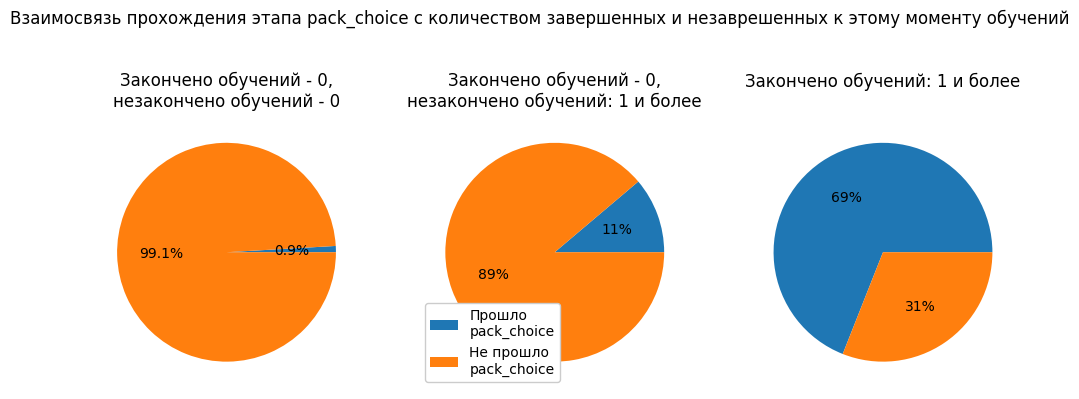

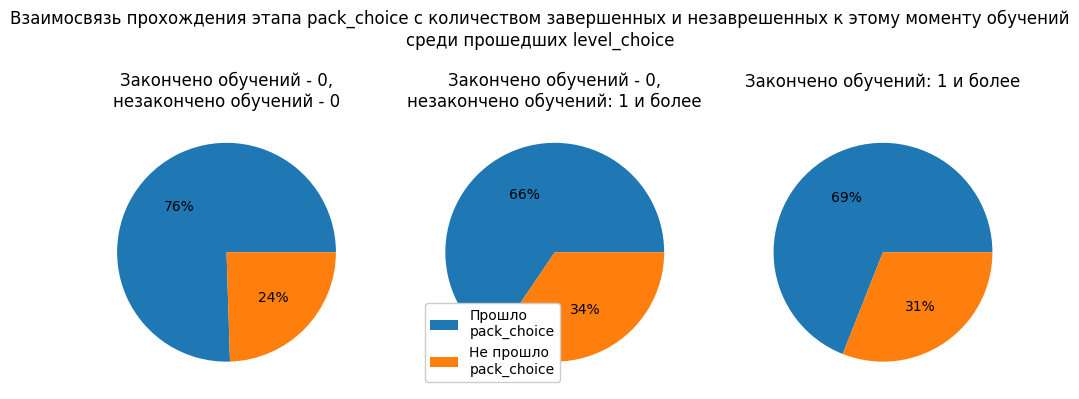

In [76]:
passing_pack_choice_all, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
passing_pack_choice_all.suptitle('Взаимосвязь прохождения этапа pack_choice с количеством завершенных и незаврешенных к этому моменту обучений')

axes[0].pie(
    tutfinished0_tutsarted0_before_pack_all,
    autopct='%.1f%%',
    #colors=['y','c']
    );
axes[0].set_title('Закончено обучений - 0,\nнезакончено обучений - 0');


axes[1].pie(
    tutfinished0_tutsarted1and_before_pack_all,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[1].set_title('Закончено обучений - 0,\nнезакончено обучений: 1 и более');
axes[1].legend(['Прошло\npack_choice', 'Не прошло\npack_choice'], loc='lower left', framealpha=1);

axes[2].pie(
    tutfinished1and_before_pack_all,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[2].set_title('Закончено обучений: 1 и более\n');

passing_pack_choice_level_passed, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
passing_pack_choice_level_passed.suptitle('Взаимосвязь прохождения этапа pack_choice с количеством завершенных и незаврешенных к этому моменту обучений\nсреди прошедших level_choice')

axes[0].pie(
    tutfinished0_tutsarted0_before_pack_level_passed,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[0].set_title('Закончено обучений - 0,\nнезакончено обучений - 0');


axes[1].pie(
    tutfinished0_tutsarted1and_before_pack_level_passed,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[1].set_title('Закончено обучений - 0,\nнезакончено обучений: 1 и более');
axes[1].legend(['Прошло\npack_choice', 'Не прошло\npack_choice'], loc='lower left', framealpha=1);

axes[2].pie(
    tutfinished1and_before_pack_level_passed,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[2].set_title('Закончено обучений: 1 и более\n');

**Выводы** 
1. 2/3 пользователей, завершивших хотя бы одно обучение, прошли этап pack_choice.
   *Примечание. Одинаковый результат на правых диаграммах объясняется тем, что все пользователи, завершившие хотя бы 1 обучение, прошли level_choice/*
2. Подавляющее большинство пользователей, не завершивших обучение, не прошли pack_choice. При этом большая их часть отсеялась еще на этапе level_chice, а из тех кто все-таки прошел level_choice, большинство прошло и pack_choice:
   - из необучавшихся вообще этап level_choice прошел только 1%; из этого процента 3/4 прошли и этап pack_choice.
   - незавершенное обучение повышает процент прошедших level_choice до 11%; из этих 11% 2/3 сумели пройти и pack_choice.
3. Отметим, что среди прошедших level_choice, соотношение прошедших и непрошедших pack_choice примерно одинаково для групп с разным количеством и качеством обучения - от 2/3:1/3 до 3/4:1/4 .

#### Определим взамосвязь между прохождением обучения (полностью или частично) и **временем** прохождения этапов pack_choice и игры в целом.

##### Для начала определим взаимосвязь времени и фактов завершения обучений на этапах level_choice и pack_choice.
Будем действовать подобно тому, как мы действовали анализируя этап level_choice:

In [77]:
events_time_plus_tutorial_matrix_packflags=events_time_plus_tutorial_matrix.copy()
events_time_plus_tutorial_matrix_packflags['tutfinish_after_reg'] \
    =events_time_plus_tutorial_matrix_packflags['tutfinish_after_reg'].apply( \
        lambda q : 'Y' if q>0 else 'N')
events_time_plus_tutorial_matrix_packflags['tutfinish_after_level'] \
    =events_time_plus_tutorial_matrix_packflags['tutfinish_after_level'].apply( \
        lambda q : 'Y' if q>0 else 'N')

users_distrib_total_after_reg_to_pack_l1_details=events_time_plus_tutorial_matrix_packflags.groupby( \
    ['pack_isna','tutfinish_after_reg', 'tutfinish_after_level'], axis=0, as_index=False)
users_distrib_total_after_reg_to_pack_l1_details=users_distrib_total_after_reg_to_pack_l1_details.aggregate( \
    {'user_id':'count', 'pack-level_diff':'median', 'pack-reg_diff':'median'})
users_distrib_total_after_reg_to_pack_l1_details.rename( \
    columns={'user_id':'user_id_cnt', 'pack-level_diff':'level-pack_time_median', \
        'pack-reg_diff':'reg-pack_time_median'}, inplace=True)
users_distrib_total_after_reg_to_pack_l1_details_cool=users_distrib_total_after_reg_to_pack_l1_details.copy()
users_distrib_total_after_reg_to_pack_l1_details_cool['level-pack_time_median'] \
    =round(users_distrib_total_after_reg_to_pack_l1_details_cool['level-pack_time_median'],3)
users_distrib_total_after_reg_to_pack_l1_details_cool['reg-pack_time_median'] \
    =round(users_distrib_total_after_reg_to_pack_l1_details_cool['reg-pack_time_median'],1)
print('Медианное время (в часах) прохождения этапа pack_choice и общее время от регистрации до pack_choice\nв зависимости от факта наличия завершенных обучений на этапе level_choice и на этапе pack_choice:')
pd.set_option('display.max_rows', 6)
display(users_distrib_total_after_reg_to_pack_l1_details_cool)
pd.set_option('display.max_rows', 4)

Медианное время (в часах) прохождения этапа pack_choice и общее время от регистрации до pack_choice
в зависимости от факта наличия завершенных обучений на этапе level_choice и на этапе pack_choice:


,pack_isna,tutfinish_after_reg,tutfinish_after_level,user_id_cnt,level-pack_time_median,reg-pack_time_median
0,False,N,N,561,0.080,7.1
1,False,Y,N,5155,0.083,6.1
2,False,Y,Y,21,0.089,3.5
3,True,N,N,11864,NaN,NaN
4,True,Y,N,1920,NaN,NaN
5,True,Y,Y,405,NaN,NaN


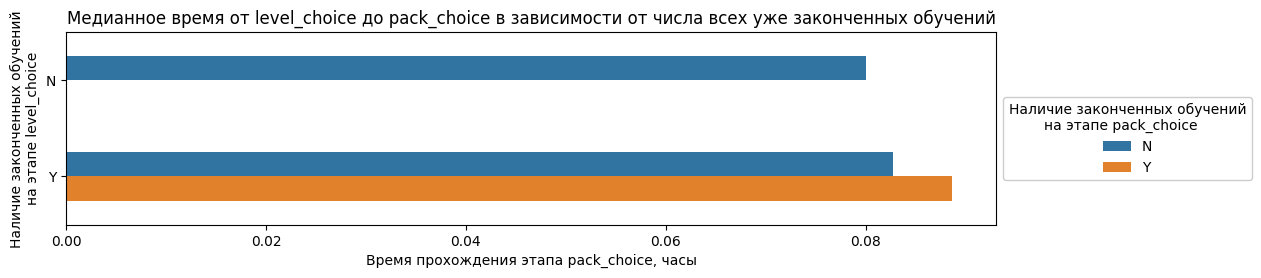

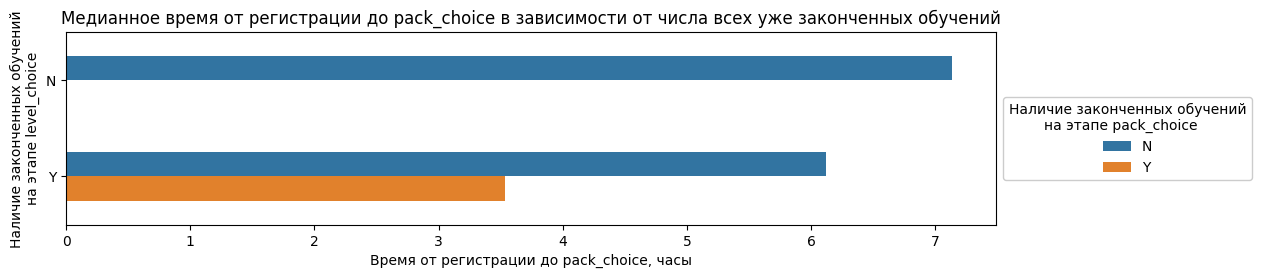

In [78]:
fig_tut_finished_before_level_for_pack_median = plt.figure(figsize=(12, 2.5))
barplot = sns.barplot(
    data=users_distrib_total_after_reg_to_pack_l1_details[ \
        ~users_distrib_total_after_reg_to_pack_l1_details['pack_isna']],
    x='level-pack_time_median',
    y='tutfinish_after_reg',
    hue='tutfinish_after_level',
    orient='h',
    width=0.5
)
barplot.set_title('Медианное время от level_choice до pack_choice в зависимости от числа всех уже законченных обучений');
barplot.set_xlabel('Время прохождения этапа pack_choice, часы');
barplot.set_ylabel('Наличие законченных обучений\nна этапе level_choice');
barplot.legend (title='Наличие законченных обучений\n        на этапе pack_choice', \
    bbox_to_anchor=(1, 0.7), framealpha=1, facecolor='w'); 

fig_tut_finished_for_pack_median = plt.figure(figsize=(12, 2.5))
barplot = sns.barplot(
    data=users_distrib_total_after_reg_to_pack_l1_details[ \
        ~users_distrib_total_after_reg_to_pack_l1_details['pack_isna']],
    x='reg-pack_time_median',
    y='tutfinish_after_reg',
    hue='tutfinish_after_level',
    orient='h',
    width=0.5
)
barplot.set_title('Медианное время от регистрации до pack_choice в зависимости от числа всех уже законченных обучений');
barplot.set_xlabel('Время от регистрации до pack_choice, часы');
barplot.set_ylabel('Наличие законченных обучений\nна этапе level_choice');
barplot.legend (title='Наличие законченных обучений\n        на этапе pack_choice', \
    bbox_to_anchor=(1, 0.7), framealpha=1, facecolor='w');

**Предварительные выводы:**
1. **Если смотреть только на  время прохождения этапа pack_choice:**
   - Быстрее всего этап pack_choice проходят те, кто вообще не проходил обучение. Однако мы поним, что шансы дойти до этого этапа у них минимальны (1%), а шансы пройти его еще меньше - (76% от 1%, см. предыдущую диаграмму).
   - Повторим ранее сделанный вывод: те, кто не завершал обучения на этапе level_choice, не завершат его и на этапе pack_choice.
   -Среди закончивших обучение на этапе level_choice, быстрее проходят этап pack_choice те, кто не завершает доплнительного обучения на этом этапе.
2. **Если посмотреть на общее время от регистрации до события pack_choice, то картина получается обратной:**
   - Те, кто не завершил ни одного обучения, совершают pack_choice позднее всех.
   - Наличие законченных обучений на этапе level_choice уменьшает время до события pack_choice.
   - Наличие еще и дополнительных законченных обучений на этапе pack_choice еще существенней уменьшает время до события pack_choice.

##### Дополнительно определим взаимосвязь времени и наличия незавершенного обучения для тех, у кого нет завершенного обучения.
При анализе этапа level_choice было установлено, что при наличии завершенного обучения, влияние назавершенного на время прохождения этапа незначительно и им можно пренебречь.  
Будем действовать подобно тому, как мы действовали анализируя этап level_choice:

In [79]:
events_time_plus_tutorial_matrix_packflags2=events_time_plus_tutorial_matrix.copy()
events_time_plus_tutorial_matrix_packflags2['tutfinish_before_pack'] \
    =events_time_plus_tutorial_matrix_packflags2['tutfinish_before_pack'].apply( \
        lambda q : 'Y' if q>0 else 'N')
events_time_plus_tutorial_matrix_packflags2['tut_notfinish_before_pack'] \
    =events_time_plus_tutorial_matrix_packflags2['tut_notfinish_before_pack'].apply( \
        lambda q : 'Y' if q>0 else 'N')

users_distrib_total_after_reg_to_pack_l2=events_time_plus_tutorial_matrix_packflags2[ \
    (events_time_plus_tutorial_matrix_packflags2['tutfinish_before_pack']=='N')].groupby( \
        ['pack_isna', 'tutfinish_before_pack', 'tut_notfinish_before_pack'], axis=0, as_index=False)
users_distrib_total_after_reg_to_pack_l2=users_distrib_total_after_reg_to_pack_l2.aggregate( \
    {'user_id':'count', 'pack-level_diff':'median', 'pack-reg_diff':'median'})
users_distrib_total_after_reg_to_pack_l2.rename( \
    columns={'user_id':'user_id_cnt', 'pack-level_diff':'level-pack_time_median', \
        'pack-reg_diff':'reg-pack_time_median'}, inplace=True)
users_distrib_total_after_reg_to_pack_l2_cool=users_distrib_total_after_reg_to_pack_l2.copy()
users_distrib_total_after_reg_to_pack_l2_cool['level-pack_time_median'] \
    =round(users_distrib_total_after_reg_to_pack_l2_cool['level-pack_time_median'],4)
users_distrib_total_after_reg_to_pack_l2_cool['reg-pack_time_median'] \
    =round(users_distrib_total_after_reg_to_pack_l2_cool['reg-pack_time_median'],1)
print('Медианное время (в часах) прохождения этапа pack_choice и общее время от регистрации до pack_choice\nв зависимости от факта наличия незавершенных обучений для тех, у кого нет завершенных:')
display(users_distrib_total_after_reg_to_pack_l2_cool)

Медианное время (в часах) прохождения этапа pack_choice и общее время от регистрации до pack_choice
в зависимости от факта наличия незавершенных обучений для тех, у кого нет завершенных:


,pack_isna,tutfinish_before_pack,tut_notfinish_before_pack,user_id_cnt,level-pack_time_median,reg-pack_time_median
0,False,N,N,74,0.0796,4.8
1,False,N,Y,487,0.0800,7.5
2,True,N,N,7994,NaN,NaN
3,True,N,Y,3870,NaN,NaN


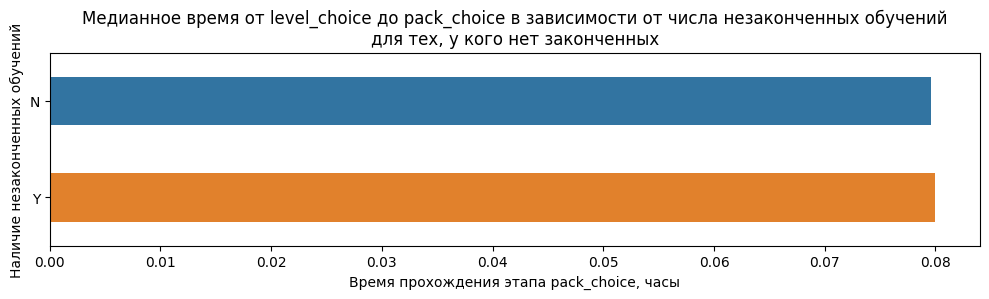

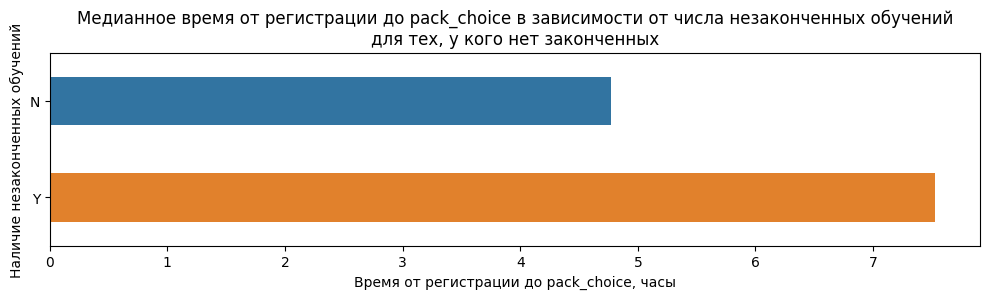

In [80]:
fig_tut_notfinished_for_levelpack_median = plt.figure(figsize=(12, 2.5))
barplot = sns.barplot(
    data=users_distrib_total_after_reg_to_pack_l2[~users_distrib_total_after_reg_to_pack_l2['pack_isna']],
    x='level-pack_time_median',
    y='tut_notfinish_before_pack',
    orient='h',
    width=0.5
)
barplot.set_title('Медианное время от level_choice до pack_choice в зависимости от числа незаконченных обучений\nдля тех, у кого нет законченных');
barplot.set_xlabel('Время прохождения этапа pack_choice, часы');
barplot.set_ylabel('Наличие незаконченных обучений');

fig_tut_notfinished_for_pack_median = plt.figure(figsize=(12, 2.5))
barplot = sns.barplot(
    data=users_distrib_total_after_reg_to_pack_l2[~users_distrib_total_after_reg_to_pack_l2['pack_isna']],
    x='reg-pack_time_median',
    y='tut_notfinish_before_pack',
    orient='h',
    width=0.5
)
barplot.set_title('Медианное время от регистрации до pack_choice в зависимости от числа незаконченных обучений\nдля тех, у кого нет законченных');
barplot.set_xlabel('Время от регистрации до pack_choice, часы');
barplot.set_ylabel('Наличие незаконченных обучений');

**Предварительные выводы:**
1. **Если смотреть только на  время прохождения этапа pack_choice:**
   - В отлияие от этапа level_choice, этап pack_choice пользователи вообще без обучения проходят чуть-чуть быстрее (на несколько секунд), чем те кто начинал, но не заканчивал обучение.
2. **Если посмотреть на общее время от регистрации до события pack_choice, то картина получается обратной:**
   - Пользователи без обучения совершают pack_choice гораздо быстрее чем те, кто начинал, но не заканчивал обучение. Это объясняется тем, что на на этап level_choice они потратили гораздо больше времени, а этот этап на порядок более значим для суммарного времени чем этап pack_choice.

##### Для дальнейшего анализа отсечем те группы, в которых слишком мало пользователей
Как и на этапе level_choice, оставим только те группы, в которых состоит не менее 10 пользователей.
Для этого используем аналогичный алгоритм.

Добавим к таблицам групп users_distrib_after_reg_to_pack_l... столбец-заготовку флага (valid), показывающий удовлетворяет ли группа обозначенному выше условию:


In [81]:
users_distrib_after_reg_to_pack_l1_details['valid']=False
display(users_distrib_after_reg_to_pack_l1_details)
users_distrib_after_reg_to_pack_l2['valid']=False
display(users_distrib_after_reg_to_pack_l2)

,pack_isna,tutfinish_after_reg,tutfinish_after_level,user_id_cnt,level-pack_time_median,reg-pack_time_median,valid
0,False,0,0,561,0.080000,7.134444,False
1,False,1,0,4664,0.083056,6.297222,False
...,...,...,...,...,...,...,...
42,True,5,4,1,NaN,NaN,False
43,True,6,2,1,NaN,NaN,False


,level_isna,pack_isna,tutfinish_before_pack,tut_notfinish_before_pack,user_id_cnt,level-pack_time_median,reg-pack_time_median,valid
0,False,False,0,0,74,0.079583,4.768333,False
1,False,False,0,1,478,0.079583,7.547222,False
...,...,...,...,...,...,...,...,...
69,True,True,0,8,23,NaN,NaN,False
70,True,True,0,9,27,NaN,NaN,False


Применим ранее написанную функцию stat_validation , устанавливающую флаги удовлетворения условию размера групп, к таблице групп завершенного обучения -> получим таблицу events_level_tutorial_matrix_l1_valid :

In [82]:
reg_to_pack_matrix_l1_valid=users_distrib_after_reg_to_pack_l1_details.apply( \
    lambda row: stat_validation(row, users_distrib_after_reg_to_pack_l1_details['user_id_cnt'].sum()), axis=1)
pd.set_option('display.max_rows', 4)
print( \
    'Разбиение пользователей на группы по факту прохождения этапа pack_choice,\nчислу завершенных обучений на этапе level_choice и на этапе pack_choice,\nс указанием флага валидности групп с учетом кол-ва пользователей\nи медианного времени прохождения этапа pack_choice и всей игры до события pack_choice:')
display(reg_to_pack_matrix_l1_valid)
pd.set_option('display.max_rows', 9)
print('Та же таблица, но только с валидными по количеству пользователей подгруппами, и только среди прошедших pack_choice:')
display(reg_to_pack_matrix_l1_valid[ \
    (~reg_to_pack_matrix_l1_valid['pack_isna']) & (reg_to_pack_matrix_l1_valid['valid'])])

Разбиение пользователей на группы по факту прохождения этапа pack_choice,
числу завершенных обучений на этапе level_choice и на этапе pack_choice,
с указанием флага валидности групп с учетом кол-ва пользователей
и медианного времени прохождения этапа pack_choice и всей игры до события pack_choice:


,pack_isna,tutfinish_after_reg,tutfinish_after_level,user_id_cnt,level-pack_time_median,reg-pack_time_median,valid
0,False,0,0,561,0.080000,7.134444,True
1,False,1,0,4664,0.083056,6.297222,True
...,...,...,...,...,...,...,...
42,True,5,4,1,NaN,NaN,False
43,True,6,2,1,NaN,NaN,False


Та же таблица, но только с валидными по количеству пользователей подгруппами, и только среди прошедших pack_choice:


,pack_isna,tutfinish_after_reg,tutfinish_after_level,user_id_cnt,level-pack_time_median,reg-pack_time_median,valid
0,False,0,0,561,0.080000,7.134444,True
1,False,1,0,4664,0.083056,6.297222,True
2,False,1,1,13,0.123611,4.024167,True
3,False,2,0,352,0.084028,5.057361,True
5,False,3,0,78,0.074028,4.616111,True
7,False,4,0,38,0.060556,5.176667,True
8,False,5,0,15,0.064444,5.171944,True


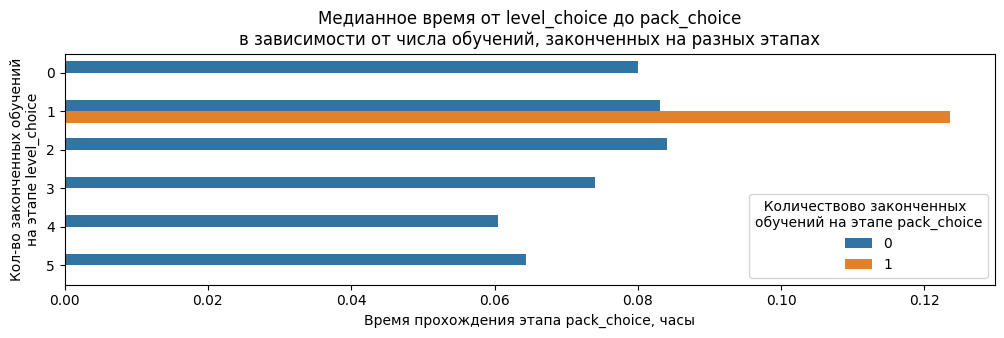

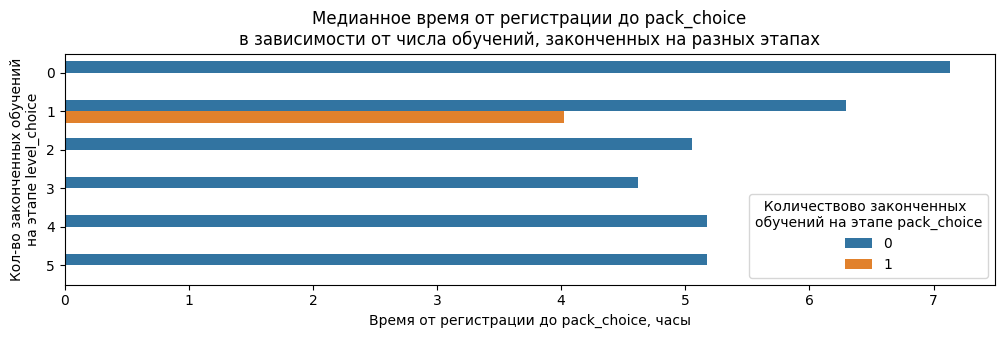

In [83]:
fig_tut_for_pack_median = plt.figure(figsize=(12, 3))
barplot = sns.barplot(
    data=reg_to_pack_matrix_l1_valid[ \
        reg_to_pack_matrix_l1_valid['valid'] & ~reg_to_pack_matrix_l1_valid['pack_isna']],
    x='level-pack_time_median',
    y='tutfinish_after_reg',
    hue='tutfinish_after_level',
    orient='h',
    width=0.6
)
barplot.set_title('Медианное время от level_choice до pack_choice\nв зависимости от числа обучений, законченных на разных этапах');
barplot.set_xlabel('Время прохождения этапа pack_choice, часы');
barplot.set_ylabel('Кол-во законченных обучений\nна этапе level_choice');
barplot.legend (title='  Количествово законченных\nобучений на этапе pack_choice', loc='lower right');

fig_tut_for_reg_pack_median = plt.figure(figsize=(12, 3))
barplot = sns.barplot(
    data=reg_to_pack_matrix_l1_valid[ \
        reg_to_pack_matrix_l1_valid['valid'] & ~reg_to_pack_matrix_l1_valid['pack_isna']],
    x='reg-pack_time_median',
    y='tutfinish_after_reg',
    hue='tutfinish_after_level',
    orient='h',
    width=0.6
)
barplot.set_title('Медианное время от регистрации до pack_choice\nв зависимости от числа обучений, законченных на разных этапах');
barplot.set_xlabel('Время от регистрации до pack_choice, часы');
barplot.set_ylabel('Кол-во законченных обучений\nна этапе level_choice');
barplot.legend (title='  Количествово законченных\nобучений на этапе pack_choice', loc='lower right');

**Предварительные выводы:**
1. **Если смотреть только на  время прохождения этапа pack_choice:**
   - Для закончивших обучения **на этапе level_choice** наблюдается небольшой рост времени прохождения этапа pack_choice при увеличении обучений от 0 до 2, далее сильное уменьшение времени влоть до 4 обучений и небольшой рост при 5-ом обучении. Самые быстрые - с 4 обучениями, самые медленные - с 2. 
     - Противоречия с ранее сделанным выводом нет, поскольку подгруппы с 1 и 2 обучениями самые объемные, поэтому действительно в целом не завершившие обучение проходят этап pack_choice быстрее завершивших.
   - Завершение обучения **на этапе pack_choice** существенно увеличивает длительность этапа.
   - Среди закончивших обучение на этапе level_choice, быстрее проходят этап pack_choice те, кто не завершает доплнительного обучения на этом этапе.
2. **Если посмотреть на общее время от регистрации до события pack_choice:**
   - Те, кто не завершил ни одного обучения или завершил 1 (0-1), совершают pack_choice дольше всех.
   - Наличие законченного обучения на этапе pack_choice уменьшает время до события pack_choice.  
3. Помним, что **общую длительность двух этапов игры определяет первый этап, level_choice**, поскольку длительность этапов отличается на порядок.

Применим ранее написанную функцию stat_validation , устанавливающую флаги удовлетворения условию размера групп, к таблице групп завершенного и незавершенного обучения -> получим таблицу reg_to_pack_matrix_l2_valid :

In [84]:
reg_to_pack_matrix_l2_valid=users_distrib_after_reg_to_pack_l2.apply( \
    lambda row: stat_validation(row, users_distrib_after_reg_to_pack_l2['user_id_cnt'].sum()), axis=1)
pd.set_option('display.max_rows', 80)
print('Разбиение пользователей на группы по факту прохождения этапа pack_choice,\nчислу завершенных и незавершенных обучений к моменту pack_choice,\nс указанием флага валидности групп с учетом кол-ва пользователей\nи медианного времени прохождения этапа pack_choice и всей игры до события pack_choice:')
display(reg_to_pack_matrix_l2_valid)
print('Та же таблица, но только с валидными по количеству пользователей подгруппами, и только среди прошедших pack_choice:')
display(reg_to_pack_matrix_l2_valid[ \
    (~reg_to_pack_matrix_l2_valid['pack_isna']) & (reg_to_pack_matrix_l2_valid['valid'])])

Разбиение пользователей на группы по факту прохождения этапа pack_choice,
числу завершенных и незавершенных обучений к моменту pack_choice,
с указанием флага валидности групп с учетом кол-ва пользователей
и медианного времени прохождения этапа pack_choice и всей игры до события pack_choice:


,level_isna,pack_isna,tutfinish_before_pack,tut_notfinish_before_pack,user_id_cnt,level-pack_time_median,reg-pack_time_median,valid
0,False,False,0,0,74,0.079583,4.768333,True
1,False,False,0,1,478,0.079583,7.547222,True
2,False,False,0,2,9,0.101389,5.245000,False
3,False,False,1,0,4431,0.083333,6.298333,True
4,False,False,1,1,207,0.073889,6.238889,True
5,False,False,1,2,18,0.084583,7.167083,True
6,False,False,1,3,8,0.084583,5.003611,False
7,False,False,2,0,302,0.083889,5.068333,True
8,False,False,2,1,50,0.093056,4.512639,True
9,False,False,2,2,8,0.100694,5.320972,False


Та же таблица, но только с валидными по количеству пользователей подгруппами, и только среди прошедших pack_choice:


,level_isna,pack_isna,tutfinish_before_pack,tut_notfinish_before_pack,user_id_cnt,level-pack_time_median,reg-pack_time_median,valid
0,False,False,0,0,74,0.079583,4.768333,True
1,False,False,0,1,478,0.079583,7.547222,True
3,False,False,1,0,4431,0.083333,6.298333,True
4,False,False,1,1,207,0.073889,6.238889,True
5,False,False,1,2,18,0.084583,7.167083,True
7,False,False,2,0,302,0.083889,5.068333,True
8,False,False,2,1,50,0.093056,4.512639,True
12,False,False,3,0,57,0.078333,4.487222,True
13,False,False,3,1,19,0.074722,4.330278,True
16,False,False,4,0,19,0.049722,4.501667,True


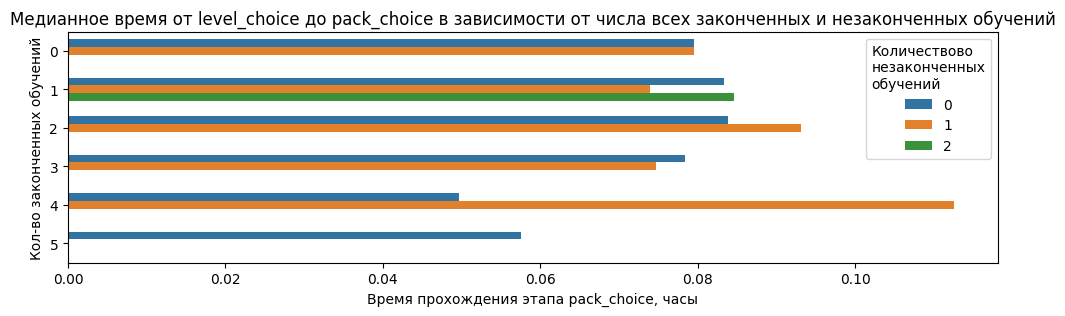

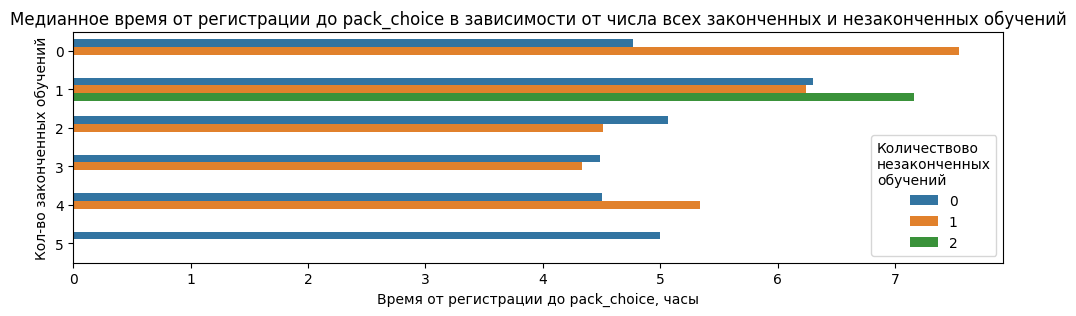

In [85]:
fig_tut_for_level_pack_median = plt.figure(figsize=(12, 3))
barplot = sns.barplot(
    data=reg_to_pack_matrix_l2_valid[ \
        reg_to_pack_matrix_l2_valid['valid'] & ~reg_to_pack_matrix_l2_valid['pack_isna']],
    x='level-pack_time_median',
    y='tutfinish_before_pack',
    hue='tut_notfinish_before_pack',
    orient='h',
    width=0.6
)
barplot.set_title('Медианное время от level_choice до pack_choice в зависимости от числа всех законченных и незаконченных обучений');
barplot.set_xlabel('Время прохождения этапа pack_choice, часы');
barplot.set_ylabel('Кол-во законченных обучений');
barplot.legend (title='Количествово\nнезаконченных\nобучений', loc='upper right');

fig_tut_for_reg_pack_median = plt.figure(figsize=(12, 3))
barplot = sns.barplot(
    data=reg_to_pack_matrix_l2_valid[ \
        reg_to_pack_matrix_l2_valid['valid'] & ~reg_to_pack_matrix_l2_valid['pack_isna']],
    x='reg-pack_time_median',
    y='tutfinish_before_pack',
    hue='tut_notfinish_before_pack',
    orient='h',
    width=0.6
)
barplot.set_title('Медианное время от регистрации до pack_choice в зависимости от числа всех законченных и незаконченных обучений');
barplot.set_xlabel('Время от регистрации до pack_choice, часы');
barplot.set_ylabel('Кол-во законченных обучений');
barplot.legend (title='Количествово\nнезаконченных\nобучений', loc='lower right');

##### **Детальные выводы** о влиянии обучения на время прохождения этапа pack_choice и всей игры до момента pack_choice
**Время прохождения этапа pack_choice**
1. Время прохождения этапа pack_choice завист от количества завершенных обучений. При отсутсвии незавершенных:
   - В диапазоне **от 0 до 3 завершенных обучений** значимой разницы во времени прохождения этапа не наблюдается; максимум - 5 минут при 2 обучениях.
   - При количестве **завершенных обучений 4 и 5** время прохождения этапа существенно меньше, минимум - 3 минуты при 4 обучениях.
2. Однозначного влияния количества незавершенных на этапе pack_choice обучений на время прохождения этапа нет. Незавершенные обучения могут как увеличивать, так и уменьшать это время, как правило, незначительно, хотя при 4 завершенных обучениях одно незавершенное увеличивает время прохождения этапа болле чем в 2 раза.

Следует иметь ввиду, что этап pack_choice всего занимает несколько минут. 

**Время прохождения игры от регистрации до события pack_choice**
1. Время прохождения игры завист от количества завершенных на этом этапе обучений:
   - **Одно (1) завершенное обучение** существенно **увеличивает** время игры;
   - При любом другом количестве завершенных обучений (0, 2 и более), значимой разницы во времени не наблюдается.
2. Количество незавершенных на этапе pack_choice обучений тоже влияет на время прохождения этого этапа. Однако это влияние зависит от наличия завершенных обучений:
   - При отсутсвии **завершенных обучений (0)**:
     - **незавершенное обучение** существенно **увеличивает время прохождения этапа** (видимо не даёт достаточных дополнительных знаний, а время при этом тратится);
   - При наличии **завершенных обучений (1 и более)**:
      - **Значимого и определенного влияния** дополнительных **незавершенных обучений не просматривается** - они могут как немного увеличивать, так и немного уменьшать время прохождения этапа (видимо в зависимости от общего числа обучений). 

Картина связи количества обучений и времени прохождения игры от регистрации до момента pack_choice, в целом повторяет аналогичную картину для этапа level_choice, поскольку этот этап занимает на порядок больше времени чем этап pack_choice и влияние времени прохождения этапа pack_choice на общую картину несущественно.

Можно было бы детально проанализировать как сказывается наиличие обучений именно на этапе pack_choice на время прохождения игры, однако поскольку этапом, определяющим время, является level_choice, а влияние длительности этапа pack_choice крайне незначительно, такой анализ представляется бессмысленным.

### ПРОХОЖДЕНИЕ ЭТАПА PURCHASE (от pack_choice до purchase включительно)

#### Подготовка таблиц для анализа

Будем использовать ранее полученную таблицу events_time_plus_tutorial_matrix.

Подобно тому, как мы делали это для предыдущих этапов игры, добавим столбцы, показывающие:
- столбец, показывающий разницу во времени между событиями pack_choice и purchase;
- столбец, показывающий разницу во времени между событиями регистрацией и purchase;
- столбец-флаг, показывающий совершил ли пользователь событие purchase.

In [86]:
events_time_plus_tutorial_matrix['purchase-pack_diff'] \
    =events_time_plus_tutorial_matrix['purchase_time'] \
        - events_time_plus_tutorial_matrix['pack_choice_time']
events_time_plus_tutorial_matrix['purchase-pack_diff'] \
    =events_time_plus_tutorial_matrix['purchase-pack_diff'].dt.total_seconds() / 3600  # пересчет времени в часы
events_time_plus_tutorial_matrix['purchase-reg_diff'] \
    =events_time_plus_tutorial_matrix['purchase_time'] \
        - events_time_plus_tutorial_matrix['registration_time']
events_time_plus_tutorial_matrix['purchase-reg_diff'] \
    =events_time_plus_tutorial_matrix['purchase-reg_diff'].dt.total_seconds() / 3600  # пересчет времени в часы
events_time_plus_tutorial_matrix['purchase_isna']=events_time_plus_tutorial_matrix['purchase_time'].isna()
#pd.set_option('display.max_rows', 28)
display(events_time_plus_tutorial_matrix.head(14))

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg,...,level_isna,pack-level_diff,pack-reg_diff,pack_isna,tutstart_before_pack,tutfinish_before_pack,tut_notfinish_before_pack,purchase-pack_diff,purchase-reg_diff,purchase_isna
0,27832,0,0,0,0,0,0,0,0,0,...,True,NaN,NaN,True,0,0,0,NaN,NaN,True
1,27833,1,0,0,0,0,0,0,0,1,...,True,NaN,NaN,True,1,0,1,NaN,NaN,True
2,27834,1,0,0,0,0,0,0,0,1,...,True,NaN,NaN,True,1,0,1,NaN,NaN,True
3,27835,1,0,0,0,1,0,0,0,0,...,False,0.022500,8.732222,False,1,1,0,NaN,NaN,True
4,27836,2,0,0,0,0,0,0,0,2,...,True,NaN,NaN,True,2,0,2,NaN,NaN,True
5,27837,0,0,0,0,0,0,0,0,0,...,True,NaN,NaN,True,0,0,0,NaN,NaN,True
6,27838,0,0,0,0,0,0,0,0,0,...,True,NaN,NaN,True,0,0,0,NaN,NaN,True
7,27839,1,0,0,0,1,0,0,0,0,...,False,0.084444,4.314722,False,1,1,0,NaN,NaN,True
8,27840,1,0,0,0,0,0,0,0,1,...,False,NaN,NaN,True,1,0,1,NaN,NaN,True
9,27841,1,0,0,0,0,0,0,0,1,...,True,NaN,NaN,True,1,0,1,NaN,NaN,True


Добавим столбец, показывающий суммарное количество событий обучения каждого пользователя с момента регистрации и до purchase:

In [87]:
events_time_plus_tutorial_matrix['tutstart_before_purchase'] \
    =events_time_plus_tutorial_matrix['tutstart_after_reg'] \
        + events_time_plus_tutorial_matrix['tutstart_after_level'] \
            + events_time_plus_tutorial_matrix['tutstart_after_pack']
events_time_plus_tutorial_matrix['tutfinish_before_purchase'] \
    =events_time_plus_tutorial_matrix['tutfinish_after_reg'] \
        + events_time_plus_tutorial_matrix['tutfinish_after_level'] \
            + events_time_plus_tutorial_matrix['tutfinish_after_pack']
pd.set_option('display.max_rows', 4)
display(events_time_plus_tutorial_matrix)

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg,...,pack-reg_diff,pack_isna,tutstart_before_pack,tutfinish_before_pack,tut_notfinish_before_pack,purchase-pack_diff,purchase-reg_diff,purchase_isna,tutstart_before_purchase,tutfinish_before_purchase
0,27832,0,0,0,0,0,0,0,0,0,...,NaN,True,0,0,0,NaN,NaN,True,0,0
1,27833,1,0,0,0,0,0,0,0,1,...,NaN,True,1,0,1,NaN,NaN,True,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,1,0,0,0,0,...,6.551667,False,1,1,0,NaN,NaN,True,1,1
19925,47757,0,0,0,0,0,0,0,0,0,...,NaN,True,0,0,0,NaN,NaN,True,0,0


Добавим столбец, показывающий суммарное количество незаконченных обучений **с момента регистрации и до purchase**:

In [88]:
events_time_plus_tutorial_matrix['tut_notfinish_before_purchase'] \
    =events_time_plus_tutorial_matrix['tutstart_before_purchase'] \
        - events_time_plus_tutorial_matrix['tutfinish_before_purchase']
display(events_time_plus_tutorial_matrix)

,user_id,tutstart_after_reg,tutstart_after_level,tutstart_after_pack,tutstart_after_purch,tutfinish_after_reg,tutfinish_after_level,tutfinish_after_pack,tutfinish_after_purch,tut_notfinish_after_reg,...,pack_isna,tutstart_before_pack,tutfinish_before_pack,tut_notfinish_before_pack,purchase-pack_diff,purchase-reg_diff,purchase_isna,tutstart_before_purchase,tutfinish_before_purchase,tut_notfinish_before_purchase
0,27832,0,0,0,0,0,0,0,0,0,...,True,0,0,0,NaN,NaN,True,0,0,0
1,27833,1,0,0,0,0,0,0,0,1,...,True,1,0,1,NaN,NaN,True,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19924,47756,1,0,0,0,1,0,0,0,0,...,False,1,1,0,NaN,NaN,True,1,1,0
19925,47757,0,0,0,0,0,0,0,0,0,...,True,0,0,0,NaN,NaN,True,0,0,0


#### Определим взамосвязь между прохождением обучения (полностью или частично) и **фактом** прохождения этапа purchase

Разобьем пользователей на группы по количеству завершенных обучений до события purchase и факту прохождения этапа purchase, и определим для каждой группы количество пользователей и медианное время прохождения этапа purchase -> новая таблица users_distrib_after_reg_to_purchase_l1

In [89]:
users_distrib_after_reg_to_purchase_l1=events_time_plus_tutorial_matrix.groupby( \
    ['level_isna','pack_isna','purchase_isna','tutfinish_before_purchase'], axis=0, as_index=False)
users_distrib_after_reg_to_purchase_l1=users_distrib_after_reg_to_purchase_l1.aggregate( \
    {'user_id':'count', 'purchase-pack_diff':'median', 'purchase-reg_diff':'median'})
users_distrib_after_reg_to_purchase_l1.rename( \
    columns={'user_id':'user_id_cnt', 'purchase-pack_diff':'pack-purchase_time_median', \
        'purchase-reg_diff':'reg-purchase_time_median'}, inplace=True)
pd.set_option('display.max_rows', 32)
display(users_distrib_after_reg_to_purchase_l1)

,level_isna,pack_isna,purchase_isna,tutfinish_before_purchase,user_id_cnt,pack-purchase_time_median,reg-purchase_time_median
0,False,False,False,0,153,95.518889,101.816944
1,False,False,False,1,1143,84.389722,91.753333
2,False,False,False,2,182,80.067639,84.958472
3,False,False,False,3,44,81.888889,87.291806
4,False,False,False,4,20,83.713611,86.702222
5,False,False,False,5,19,105.871111,111.739444
6,False,False,False,6,15,64.576389,70.364722
7,False,False,False,7,14,108.623056,112.193750
8,False,False,False,8,6,77.349861,79.842083
9,False,False,False,9,4,149.225972,150.994028


**Промежуточные выводы:** 
1. Большинство пользователей, не прошедших этап purchase, не завершили ни одного обучения (бо'льшая их часть отсеялась еще на этапе level_choice).
2. В отличие от этапа level_choice, на этапах purchase и pack_choice отсеивались и пользователи с пройденным обучением (восновном с одним).

Разобьем пользователей на группы по факту прохождения этапа purchase и по количеству завершенных обучений до события level_choice, и затем на подгруппы по числу завершенных обучений между level_ и pack_choice и на подгруппы по числу завершенных обучений между  pack_choice и purchase, и определим для каждой группы количество пользователей и медианное время прохождения этапа purchase -> новая таблица users_distrib_after_reg_to_purchase_l1_details:

In [90]:
users_distrib_after_reg_to_purchase_l1_details=events_time_plus_tutorial_matrix.groupby( \
    ['purchase_isna','tutfinish_before_pack','tutfinish_after_pack'], axis=0, as_index=False)
users_distrib_after_reg_to_purchase_l1_details=users_distrib_after_reg_to_purchase_l1_details.aggregate( \
    {'user_id':'count', 'purchase-pack_diff':'median', 'purchase-reg_diff':'median'})
users_distrib_after_reg_to_purchase_l1_details.rename( \
    columns={'user_id':'user_id_cnt', 'purchase-pack_diff':'pack-purchase_time_median', \
        'purchase-reg_diff':'reg-purchase_time_median'}, inplace=True)
pd.set_option('display.max_rows', 115)
display(users_distrib_after_reg_to_purchase_l1_details)

,purchase_isna,tutfinish_before_pack,tutfinish_after_pack,user_id_cnt,pack-purchase_time_median,reg-purchase_time_median
0,False,0,0,153,95.518889,101.816944
1,False,1,0,1143,84.389722,91.753333
2,False,1,1,118,82.205694,86.265694
3,False,1,2,19,76.921667,79.549167
4,False,1,3,11,83.682500,85.461667
5,False,1,4,4,90.879167,96.804583
6,False,1,5,1,52.824167,54.311389
7,False,1,6,1,36.422222,39.116667
8,False,1,7,1,32.285556,34.944722
9,False,2,0,64,76.928333,84.065556


**Промежуточные выводы:** 
1. *Большинство пользователей, не прошедших этап purchase, не завершили ни одного обучения (бо'льшая их часть отсеялась еще на этапе level_choice).*
2. *В отличие от этапа level_choice, на этапах purchase и pack_choice отсеивались и пользователи с пройденным обучением (восновном с одним).*
3. Все пользователи, не закончившие ни одного обучения на этапе level_choice, также не закончили ни одного обучения на этапах pack_choice и purchase.

Дополнительно разобъем полученные группы на подгруппы по количеству **не**завершенных обучений до события purchase и определим количество пользователей в каждой группе -> новая таблица users_distrib_after_reg_to_purchase_**l2**  
*Во избежание чрезмерного дробения групп, при учете незавершенных обучений не будем разделять завершенные на этапы.*

In [91]:
users_distrib_after_reg_to_purchase_l2=events_time_plus_tutorial_matrix.groupby( \
    ['level_isna','pack_isna','purchase_isna','tutfinish_before_purchase', \
        'tut_notfinish_before_purchase'], axis=0, as_index=False)
users_distrib_after_reg_to_purchase_l2=users_distrib_after_reg_to_purchase_l2.aggregate( \
    {'user_id':'count', 'purchase-pack_diff':'median', 'purchase-reg_diff':'median'})
users_distrib_after_reg_to_purchase_l2.rename( \
    columns={'user_id':'user_id_cnt', 'purchase-pack_diff':'pack-purchase_time_median', \
        'purchase-reg_diff':'reg-purchase_time_median'}, inplace=True)
pd.set_option('display.max_rows', 4)
display(users_distrib_after_reg_to_purchase_l2)

,level_isna,pack_isna,purchase_isna,tutfinish_before_purchase,tut_notfinish_before_purchase,user_id_cnt,pack-purchase_time_median,reg-purchase_time_median
0,False,False,False,0,0,22,100.645000,107.485833
1,False,False,False,0,1,124,89.670694,98.835000
...,...,...,...,...,...,...,...,...
111,True,True,True,0,8,23,NaN,NaN
112,True,True,True,0,9,27,NaN,NaN


Составим списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до purchase.
Первым числом в каждом списке будет количество пользователей, прошедших purchase, вторым числом - количество пользователей непрошедших purchase.
При этом, базируясь на выводе по этапу level_choice (при наличии хотя бы одного завершенного обучения, незавершенные обучения не важны, а при отсутствии завершенных важно наличие хотя бы одного незавершенного), выделим следующие варианты:
- количество завершенных обучений к моменту purchase - 0 и >=1;
- количество незавершенных обучений только при отсутсвии завершенных - 0 и >=1.

При этом составим такие списки отдельно:
- для всех зарегестрированных пользователей;
- только для тех, кто прошел pack_choice.

In [92]:
tutfinished0_tutsarted0_before_purchase_all=[]
tutfinished0_tutsarted0_before_purchase_all.append(users_distrib_after_reg_to_purchase_l2[ \
    (users_distrib_after_reg_to_purchase_l2['tutfinish_before_purchase']==0) \
        & (users_distrib_after_reg_to_purchase_l2['tut_notfinish_before_purchase']==0) \
            & (~users_distrib_after_reg_to_purchase_l2['purchase_isna'])]['user_id_cnt'].sum())
tutfinished0_tutsarted0_before_purchase_all.append(users_distrib_after_reg_to_purchase_l2[ \
    (users_distrib_after_reg_to_purchase_l2['tutfinish_before_purchase']==0) \
        & (users_distrib_after_reg_to_purchase_l2['tut_notfinish_before_purchase']==0) \
            & (users_distrib_after_reg_to_purchase_l2['purchase_isna'])]['user_id_cnt'].sum())

tutfinished0_tutsarted1and_before_purchase_all=[]
tutfinished0_tutsarted1and_before_purchase_all.append(users_distrib_after_reg_to_purchase_l2[ \
    (users_distrib_after_reg_to_purchase_l2['tutfinish_before_purchase']==0) \
        & (users_distrib_after_reg_to_purchase_l2['tut_notfinish_before_purchase']>0) \
            & (~users_distrib_after_reg_to_purchase_l2['purchase_isna'])]['user_id_cnt'].sum())
tutfinished0_tutsarted1and_before_purchase_all.append(users_distrib_after_reg_to_purchase_l2[ \
    (users_distrib_after_reg_to_purchase_l2['tutfinish_before_purchase']==0) \
        & (users_distrib_after_reg_to_purchase_l2['tut_notfinish_before_purchase']>0) \
            & (users_distrib_after_reg_to_purchase_l2['purchase_isna'])]['user_id_cnt'].sum())

tutfinished1and_before_purchase_all=[]
tutfinished1and_before_purchase_all.append(users_distrib_after_reg_to_purchase_l2[ \
    (users_distrib_after_reg_to_purchase_l2['tutfinish_before_purchase']>0) \
        & (~users_distrib_after_reg_to_purchase_l2['purchase_isna'])]['user_id_cnt'].sum())
tutfinished1and_before_purchase_all.append(users_distrib_after_reg_to_purchase_l2[ \
    (users_distrib_after_reg_to_purchase_l2['tutfinish_before_purchase']>0) \
        & (users_distrib_after_reg_to_purchase_l2['purchase_isna'])]['user_id_cnt'].sum())

print('Списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до pack_choice среди всех зарегестрированных:')
print(tutfinished0_tutsarted0_before_purchase_all, tutfinished0_tutsarted1and_before_purchase_all, \
    tutfinished1and_before_purchase_all)

Списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до pack_choice среди всех зарегестрированных:
[22, 8046] [131, 4226] [1447, 6054]


In [93]:
tutfinished0_tutsarted0_before_purchase_pack_passed=[]
tutfinished0_tutsarted0_before_purchase_pack_passed.append(users_distrib_after_reg_to_purchase_l2[ \
    (users_distrib_after_reg_to_purchase_l2['tutfinish_before_purchase']==0) \
        & (users_distrib_after_reg_to_purchase_l2['tut_notfinish_before_purchase']==0) \
            & (~users_distrib_after_reg_to_purchase_l2['purchase_isna'])]['user_id_cnt'].sum())
tutfinished0_tutsarted0_before_purchase_pack_passed.append(users_distrib_after_reg_to_purchase_l2[ \
    (users_distrib_after_reg_to_purchase_l2['tutfinish_before_purchase']==0) \
        & (users_distrib_after_reg_to_purchase_l2['tut_notfinish_before_purchase']==0) \
            & (~users_distrib_after_reg_to_purchase_l2['pack_isna']) \
                & (users_distrib_after_reg_to_purchase_l2['purchase_isna'])]['user_id_cnt'].sum())

tutfinished0_tutsarted1and_before_purchase_pack_passed=[]
tutfinished0_tutsarted1and_before_purchase_pack_passed.append(users_distrib_after_reg_to_purchase_l2[ \
    (users_distrib_after_reg_to_purchase_l2['tutfinish_before_purchase']==0) \
        & (users_distrib_after_reg_to_purchase_l2['tut_notfinish_before_purchase']>0) \
            & (~users_distrib_after_reg_to_purchase_l2['purchase_isna'])]['user_id_cnt'].sum())
tutfinished0_tutsarted1and_before_purchase_pack_passed.append(users_distrib_after_reg_to_purchase_l2[ \
    (users_distrib_after_reg_to_purchase_l2['tutfinish_before_purchase']==0) \
        & (users_distrib_after_reg_to_purchase_l2['tut_notfinish_before_purchase']>0) \
            & (~users_distrib_after_reg_to_purchase_l2['pack_isna']) \
                & (users_distrib_after_reg_to_purchase_l2['purchase_isna'])]['user_id_cnt'].sum())

tutfinished1and_before_purchase_pack_passed=[]
tutfinished1and_before_purchase_pack_passed.append(users_distrib_after_reg_to_purchase_l2[ \
    (users_distrib_after_reg_to_purchase_l2['tutfinish_before_purchase']>0) \
        & (~users_distrib_after_reg_to_purchase_l2['purchase_isna'])]['user_id_cnt'].sum())
tutfinished1and_before_purchase_pack_passed.append(users_distrib_after_reg_to_purchase_l2[ \
    (users_distrib_after_reg_to_purchase_l2['tutfinish_before_purchase']>0) \
        & (~users_distrib_after_reg_to_purchase_l2['pack_isna']) \
            & (users_distrib_after_reg_to_purchase_l2['purchase_isna'])]['user_id_cnt'].sum())

print('Списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до pack_choice среди тех, кто прошел level_choice:')
print(tutfinished0_tutsarted0_before_purchase_pack_passed, \
    tutfinished0_tutsarted1and_before_purchase_pack_passed, tutfinished1and_before_purchase_pack_passed)

Списки количества пользователей, для разных сочетаний количества завершенных и незавершенных обучений до pack_choice среди тех, кто прошел level_choice:
[22, 52] [131, 356] [1447, 3729]


Построим **ДИАГРАММЫ**, базируясь на полученных списках:

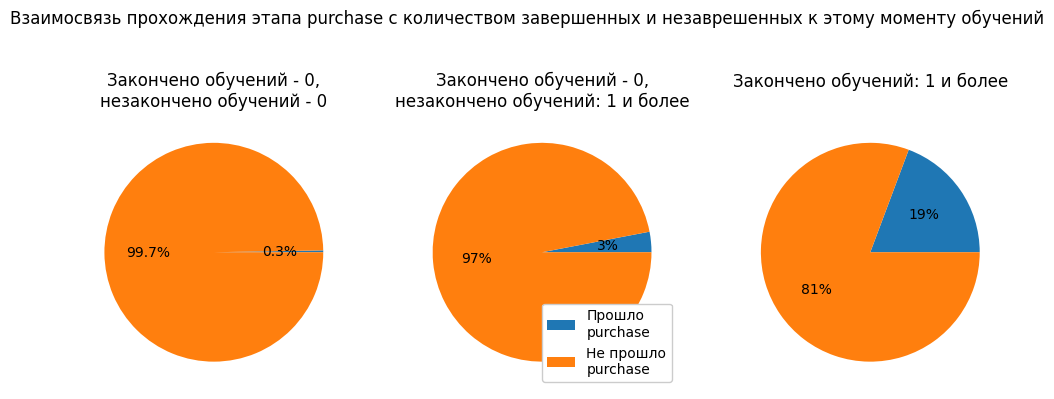

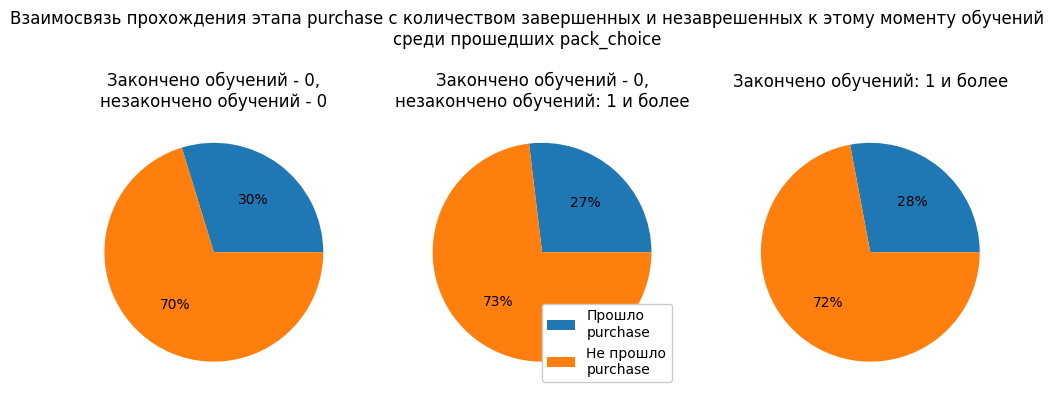

In [94]:
passing_purchase_all, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
passing_purchase_all.suptitle( \
    'Взаимосвязь прохождения этапа purchase с количеством завершенных и незаврешенных к этому моменту обучений')

axes[0].pie(
    tutfinished0_tutsarted0_before_purchase_all,
    autopct='%.1f%%',
    #colors=['y','c']
    );
axes[0].set_title('Закончено обучений - 0,\nнезакончено обучений - 0');


axes[1].pie(
    tutfinished0_tutsarted1and_before_purchase_all,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[1].set_title('Закончено обучений - 0,\nнезакончено обучений: 1 и более');
axes[1].legend(['Прошло\npurchase', 'Не прошло\npurchase'], loc='lower right', framealpha=1);

axes[2].pie(
    tutfinished1and_before_purchase_all,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[2].set_title('Закончено обучений: 1 и более\n');

passing_purchase_pack_passed, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
passing_purchase_pack_passed.suptitle( \
    'Взаимосвязь прохождения этапа purchase с количеством завершенных и незаврешенных к этому моменту обучений\nсреди прошедших pack_choice')

axes[0].pie(
    tutfinished0_tutsarted0_before_purchase_pack_passed,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[0].set_title('Закончено обучений - 0,\nнезакончено обучений - 0');


axes[1].pie(
    tutfinished0_tutsarted1and_before_purchase_pack_passed,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[1].set_title('Закончено обучений - 0,\nнезакончено обучений: 1 и более');
axes[1].legend(['Прошло\npurchase', 'Не прошло\npurchase'], loc='lower right', framealpha=1);

axes[2].pie(
    tutfinished1and_before_purchase_pack_passed,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[2].set_title('Закончено обучений: 1 и более\n');

**Выводы** 
1. Только 1/5 пользователей, завершивших хотя бы одно обучение, прошли этап purchase.
2. Почти все пользователи, не завершившие обучения, не прошли purchase. При этом большая их часть отсеялась на предыдущих этапах (восновном еще на этапе level_chice), а из тех кто все-таки прошел предыдущие этапы, purchase прошло меньше 1/3:
   - из необучавшихся вообще предыдущие этапы прошло менее 1% пользователей; из этого процента чуть меньше 1/3 прошли и этап purchase;
   - незавершенное обучение повышает процент прошедших предыдущие этапы до 3%; из этих 3% менее 1/3 сумели пройти и purchase;
   - среди завершивших хотя бы одно обучение, 1/5 прошла предыдущие этапы; из них чуть больше 1/4 сумели пройти и purchase;
3. Отметим, что среди прошедших предыдущие этапы, соотношение прошедших и непрошедших purchase примерно одинаково для групп с разным количеством и качеством обучения - от 1/4:3/4 до 1/3:2/3. Одинаковое (но другое) соотношение наблюдалось и на этапе pack_choice.

#### Определим взамосвязь между прохождением обучения (полностью или частично) и **временем** прохождения этапа purchase и игры в целом.

##### Для начала определим взаимосвязь времени и фактов завершения обучений на этапах до purchase и на этом этапе.
Будем действовать подобно тому, как мы действовали, анализируя этап pack_choice:

In [95]:
events_time_plus_tutorial_matrix_purchflags=events_time_plus_tutorial_matrix.copy()
events_time_plus_tutorial_matrix_purchflags['tutfinish_before_pack'] \
    =events_time_plus_tutorial_matrix_purchflags['tutfinish_before_pack'].apply( \
        lambda q : 'Y' if q>0 else 'N')
events_time_plus_tutorial_matrix_purchflags['tutfinish_after_pack'] \
    =events_time_plus_tutorial_matrix_purchflags['tutfinish_after_pack'].apply( \
        lambda q : 'Y' if q>0 else 'N')

users_distrib_total_after_reg_to_purch_l1_details=events_time_plus_tutorial_matrix_purchflags.groupby( \
    ['purchase_isna','tutfinish_before_pack','tutfinish_after_pack'], axis=0, as_index=False)
users_distrib_total_after_reg_to_purch_l1_details=users_distrib_total_after_reg_to_purch_l1_details.aggregate( \
    {'user_id':'count', 'purchase-pack_diff':'median', 'purchase-reg_diff':'median'})
users_distrib_total_after_reg_to_purch_l1_details.rename( \
    columns={'user_id':'user_id_cnt', 'purchase-pack_diff':'pack-purchase_time_median', \
        'purchase-reg_diff':'reg-purchase_time_median'}, inplace=True)
users_distrib_total_after_reg_to_purch_l1_details_cool=users_distrib_total_after_reg_to_purch_l1_details.copy()
users_distrib_total_after_reg_to_purch_l1_details_cool['pack-purchase_time_median'] \
    =round(users_distrib_total_after_reg_to_purch_l1_details_cool['pack-purchase_time_median'],3)
users_distrib_total_after_reg_to_purch_l1_details_cool['reg-purchase_time_median'] \
    =round(users_distrib_total_after_reg_to_purch_l1_details_cool['reg-purchase_time_median'],1)
print( \
    'Медианное время (в часах) прохождения этапа purchase и общее время от регистрации до purchase\nв зависимости от факта наличия завершенных обучений до этапа purchase и на этом этапе:')
pd.set_option('display.max_rows', 10)
display(users_distrib_total_after_reg_to_purch_l1_details_cool)
pd.set_option('display.max_rows', 4)

Медианное время (в часах) прохождения этапа purchase и общее время от регистрации до purchase
в зависимости от факта наличия завершенных обучений до этапа purchase и на этом этапе:


,purchase_isna,tutfinish_before_pack,tutfinish_after_pack,user_id_cnt,pack-purchase_time_median,reg-purchase_time_median
0,False,N,N,153,95.519,101.8
1,False,Y,N,1216,84.254,91.7
2,False,Y,Y,231,84.629,88.5
3,True,N,N,12272,NaN,NaN
4,True,Y,N,5475,NaN,NaN
5,True,Y,Y,579,NaN,NaN


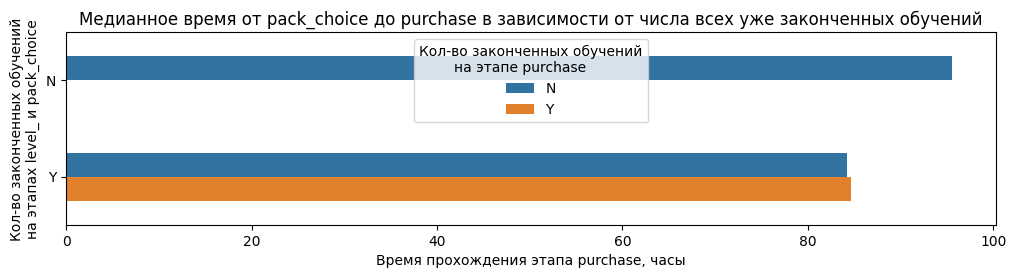

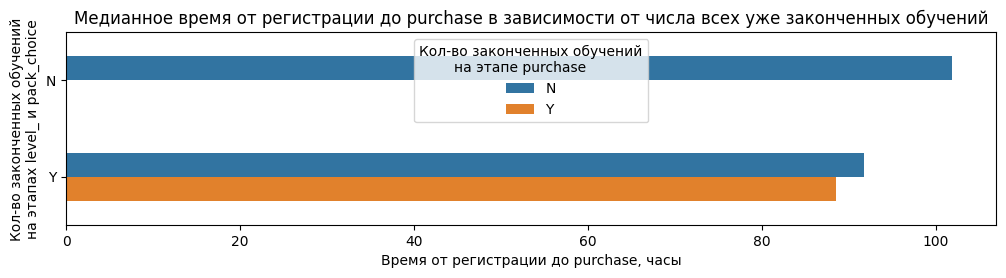

In [96]:
fig_tut_finished_pack_purch_median = plt.figure(figsize=(12, 2.5))
barplot = sns.barplot(
    data=users_distrib_total_after_reg_to_purch_l1_details[ \
        ~users_distrib_total_after_reg_to_purch_l1_details['purchase_isna']],
    x='pack-purchase_time_median',
    y='tutfinish_before_pack',
    hue='tutfinish_after_pack',
    orient='h',
    width=0.5
)
barplot.set_title( \
    'Медианное время от pack_choice до purchase в зависимости от числа всех уже законченных обучений');
barplot.set_xlabel('Время прохождения этапа purchase, часы');
barplot.set_ylabel('Кол-во законченных обучений\nна этапах level_ и pack_choice');
barplot.legend (title='Кол-во законченных обучений\n        на этапе purchase', loc='upper center'); 

fig_tut_finished_reg_purch_median = plt.figure(figsize=(12, 2.5))
barplot = sns.barplot(
    data=users_distrib_total_after_reg_to_purch_l1_details[ \
        ~users_distrib_total_after_reg_to_purch_l1_details['purchase_isna']],
    x='reg-purchase_time_median',
    y='tutfinish_before_pack',
    hue='tutfinish_after_pack',
    orient='h',
    width=0.5
)
barplot.set_title( \
    'Медианное время от регистрации до purchase в зависимости от числа всех уже законченных обучений');
barplot.set_xlabel('Время от регистрации до purchase, часы');
barplot.set_ylabel('Кол-во законченных обучений\nна этапах level_ и pack_choice');
barplot.legend (title='Кол-во законченных обучений\n        на этапе purchase', loc='upper center');
#bbox_to_anchor=(1.15, 0.5), framealpha=1, facecolor='w');

**Предварительные выводы:**
1. Этап purchase занимает на порядок большк времени чем этап pack_choice. В целом соотношение этапов игры примерно такое:
   - level_choice - часы;
   - pack_choice  - минуты;
   - purchase     - дни.
2. **Если смотреть только на  время прохождения этапа purchase:**
   - По сравнению с длительностью этапа, разница во времени между различными группами не слишком большая. Завершившие обучение проходят этап быстрее чем незавершавшие. 
3. **Если посмотреть на общее время от регистрации до события purchase, то картина получается очень похожая.**

##### Дополнительно определим взаимосвязь времени и наличия незавершенного обучения для тех, у кого нет завершенного обучения.
При анализе этапа level_choice было установлено, что при наличии завершенного обучения, влияние назавершенного на время прохождения этапа незначительно и им можно пренебречь.  
Будем действовать подобно тому, как мы действовали анализируя этап pack_choice:

In [97]:
events_time_plus_tutorial_matrix_purchflags2=events_time_plus_tutorial_matrix.copy()
events_time_plus_tutorial_matrix_purchflags2['tutfinish_before_purchase'] \
    =events_time_plus_tutorial_matrix_purchflags2['tutfinish_before_purchase'].apply( \
        lambda q : 'Y' if q>0 else 'N')
events_time_plus_tutorial_matrix_purchflags2['tut_notfinish_before_purchase'] \
    =events_time_plus_tutorial_matrix_purchflags2['tut_notfinish_before_purchase'].apply( \
        lambda q : 'Y' if q>0 else 'N')

users_distrib_total_after_reg_to_purch_l2 \
    =events_time_plus_tutorial_matrix_purchflags2[ \
        events_time_plus_tutorial_matrix_purchflags2['tutfinish_before_purchase']=='N'].groupby( \
            ['purchase_isna', 'tutfinish_before_purchase', 'tut_notfinish_before_purchase'], axis=0, as_index=False)
users_distrib_total_after_reg_to_purch_l2=users_distrib_total_after_reg_to_purch_l2.aggregate( \
    {'user_id':'count', 'purchase-pack_diff':'median', 'purchase-reg_diff':'median'})
users_distrib_total_after_reg_to_purch_l2.rename( \
    columns={'user_id':'user_id_cnt', 'purchase-pack_diff':'pack-purchase_time_median', \
        'purchase-reg_diff':'reg-purchase_time_median'}, inplace=True)
users_distrib_total_after_reg_to_purch_l2_cool=users_distrib_total_after_reg_to_purch_l2.copy()
users_distrib_total_after_reg_to_purch_l2_cool['pack-purchase_time_median'] \
    =round(users_distrib_total_after_reg_to_purch_l2_cool['pack-purchase_time_median'],2)
users_distrib_total_after_reg_to_purch_l2_cool['reg-purchase_time_median'] \
    =round(users_distrib_total_after_reg_to_purch_l2_cool['reg-purchase_time_median'],1)
print( \
    'Медианное время (в часах) прохождения этапа purchase и общее время от регистрации до purchase\nв зависимости от факта наличия незавершенных обучений для тех, у кого нет завершенных:')
display(users_distrib_total_after_reg_to_purch_l2_cool)

Медианное время (в часах) прохождения этапа purchase и общее время от регистрации до purchase
в зависимости от факта наличия незавершенных обучений для тех, у кого нет завершенных:


,purchase_isna,tutfinish_before_purchase,tut_notfinish_before_purchase,user_id_cnt,pack-purchase_time_median,reg-purchase_time_median
0,False,N,N,22,100.65,107.5
1,False,N,Y,131,91.19,101.4
2,True,N,N,8046,NaN,NaN
3,True,N,Y,4226,NaN,NaN


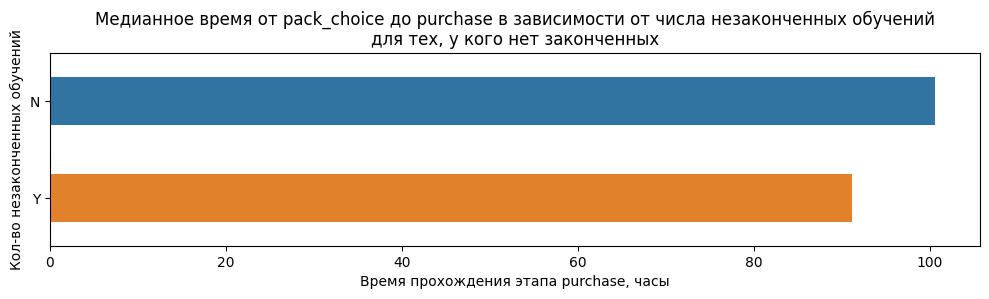

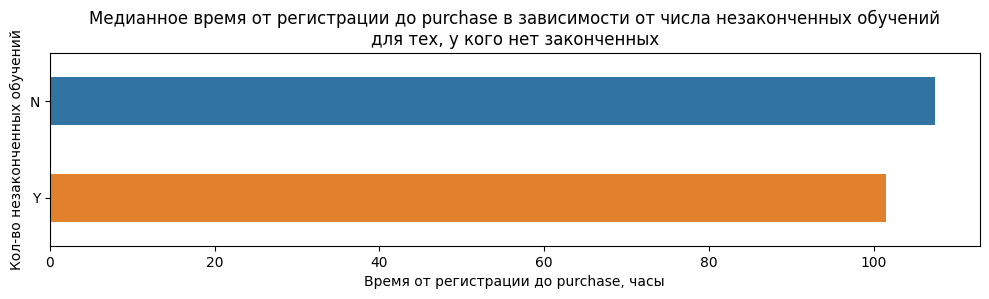

In [98]:
fig_tut_notfinished_for_packpurch_median = plt.figure(figsize=(12, 2.5))
barplot = sns.barplot(
    data=users_distrib_total_after_reg_to_purch_l2[ \
        ~users_distrib_total_after_reg_to_purch_l2['purchase_isna']],
    x='pack-purchase_time_median',
    y='tut_notfinish_before_purchase',
    orient='h',
    width=0.5
)
barplot.set_title( \
    'Медианное время от pack_choice до purchase в зависимости от числа незаконченных обучений\nдля тех, у кого нет законченных');
barplot.set_xlabel('Время прохождения этапа purchase, часы');
barplot.set_ylabel('Кол-во незаконченных обучений');

fig_tut_notfinished_for_regpurch_median = plt.figure(figsize=(12, 2.5))
barplot = sns.barplot(
    data=users_distrib_total_after_reg_to_purch_l2[ \
        ~users_distrib_total_after_reg_to_purch_l2['purchase_isna']],
    x='reg-purchase_time_median',
    y='tut_notfinish_before_purchase',
    orient='h',
    width=0.5
)
barplot.set_title( \
    'Медианное время от регистрации до purchase в зависимости от числа незаконченных обучений\nдля тех, у кого нет законченных');
barplot.set_xlabel('Время от регистрации до purchase, часы');
barplot.set_ylabel('Кол-во незаконченных обучений');

**Предварительный вывод:**
Картина и на самом этапе purchase и в целом одинаковая - из незакончивших обучение игру проходят немного быстрее те, кто хотя бы начинал обучение.  
- Схожесть картин на самом этапе purchase и в целом объясняется тем, что продолжительность игры определяется этапом purchase, многократно превосходящим по времени остальные этапы.

##### Для дальнейшего анализа отсечем те группы, в которых слишком мало пользователей
Как и на предыдущих этапах, оставим только те группы, в которых состоит не менее 10 пользователей.
Для этого используем аналогичный алгоритм.

Добавим к таблицам групп users_distrib_after_reg_to_purchase_l... столбец-заготовку флага (valid), показывающий удовлетворяет ли группа обозначенному выше условию:


In [99]:
users_distrib_after_reg_to_purchase_l1_details['valid']=False
display(users_distrib_after_reg_to_purchase_l1_details)
#users_distrib_total_after_reg_to_purch_l1_details['valid']=False
#display(users_distrib_total_after_reg_to_purch_l1_details)
users_distrib_after_reg_to_purchase_l2['valid']=False
pd.set_option('display.max_rows', 4)
display(users_distrib_after_reg_to_purchase_l2)

,purchase_isna,tutfinish_before_pack,tutfinish_after_pack,user_id_cnt,pack-purchase_time_median,reg-purchase_time_median,valid
0,False,0,0,153,95.518889,101.816944,False
1,False,1,0,1143,84.389722,91.753333,False
...,...,...,...,...,...,...,...
75,True,8,0,12,NaN,NaN,False
76,True,9,0,3,NaN,NaN,False


,level_isna,pack_isna,purchase_isna,tutfinish_before_purchase,tut_notfinish_before_purchase,user_id_cnt,pack-purchase_time_median,reg-purchase_time_median,valid
0,False,False,False,0,0,22,100.645000,107.485833,False
1,False,False,False,0,1,124,89.670694,98.835000,False
...,...,...,...,...,...,...,...,...,...
111,True,True,True,0,8,23,NaN,NaN,False
112,True,True,True,0,9,27,NaN,NaN,False


Применим ранее написанную функцию stat_validation , устанавливающую флаги удовлетворения условию размера групп, к таблице групп завершенного обучения -> получим таблицу reg_to_to_purchase_l1_details_matrix_l1_valid :

In [100]:
reg_to_purchase_l1_details_matrix_l1_valid=users_distrib_after_reg_to_purchase_l1_details.apply( \
    lambda row: stat_validation(row, users_distrib_total_after_reg_to_purch_l1_details['user_id_cnt'].sum()), axis=1)
print( \
    'Разбиение пользователей на группы по факту прохождения этапа purchase,\nчислу завершенных обучений до этапа purchase, и на этапе purchase,\nс указанием флага валидности групп с учетом кол-ва пользователей\nи медианного времени прохождения этапа purchase и всей игры до события purchase:')
pd.set_option('display.max_rows', 4)
display(reg_to_purchase_l1_details_matrix_l1_valid) 
print( \
    'Та же таблица, но только с валидными по количеству пользователей подгруппами, и только среди прошедших purchase:')
pd.set_option('display.max_rows', 7)
display(reg_to_purchase_l1_details_matrix_l1_valid[ \
    (~reg_to_purchase_l1_details_matrix_l1_valid['purchase_isna']) \
        & (reg_to_purchase_l1_details_matrix_l1_valid['valid'])])

Разбиение пользователей на группы по факту прохождения этапа purchase,
числу завершенных обучений до этапа purchase, и на этапе purchase,
с указанием флага валидности групп с учетом кол-ва пользователей
и медианного времени прохождения этапа purchase и всей игры до события purchase:


,purchase_isna,tutfinish_before_pack,tutfinish_after_pack,user_id_cnt,pack-purchase_time_median,reg-purchase_time_median,valid
0,False,0,0,153,95.518889,101.816944,True
1,False,1,0,1143,84.389722,91.753333,True
...,...,...,...,...,...,...,...
75,True,8,0,12,NaN,NaN,True
76,True,9,0,3,NaN,NaN,False


Та же таблица, но только с валидными по количеству пользователей подгруппами, и только среди прошедших purchase:


,purchase_isna,tutfinish_before_pack,tutfinish_after_pack,user_id_cnt,pack-purchase_time_median,reg-purchase_time_median,valid
0,False,0,0,153,95.518889,101.816944,True
1,False,1,0,1143,84.389722,91.753333,True
2,False,1,1,118,82.205694,86.265694,True
3,False,1,2,19,76.921667,79.549167,True
4,False,1,3,11,83.682500,85.461667,True
9,False,2,0,64,76.928333,84.065556,True
10,False,2,1,19,78.820556,84.751111,True


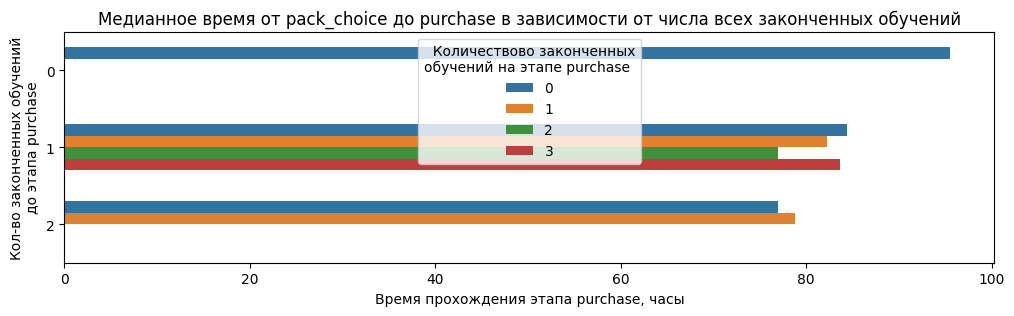

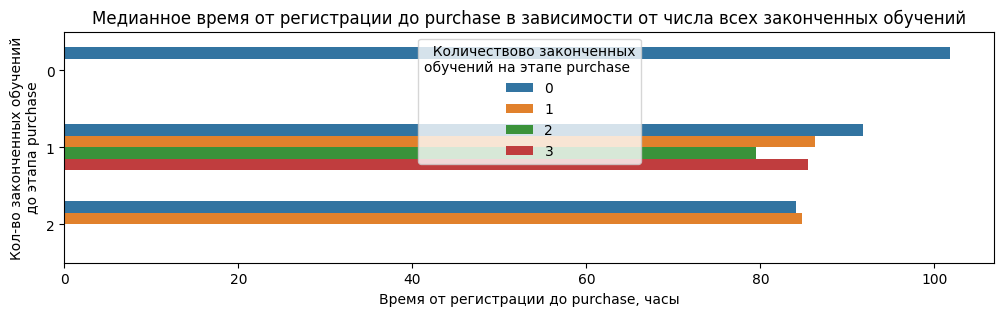

In [101]:
fig_tut_for_purch_median = plt.figure(figsize=(12, 3))
barplot = sns.barplot(
    data=reg_to_purchase_l1_details_matrix_l1_valid[ \
        reg_to_purchase_l1_details_matrix_l1_valid['valid'] \
            & ~reg_to_purchase_l1_details_matrix_l1_valid['purchase_isna']],
    x='pack-purchase_time_median',
    y='tutfinish_before_pack',
    hue='tutfinish_after_pack',
    orient='h',
    width=0.6
)
barplot.set_title( \
    'Медианное время от pack_choice до purchase в зависимости от числа всех законченных обучений');
barplot.set_xlabel('Время прохождения этапа purchase, часы');
barplot.set_ylabel('Кол-во законченных обучений\nдо этапа purchase');
barplot.legend (title='  Количествово законченных\nобучений на этапе purchase', loc='upper center');

fig_tut_for_reg_pucrh_median = plt.figure(figsize=(12, 3))
barplot = sns.barplot(
    data=reg_to_purchase_l1_details_matrix_l1_valid[ \
        reg_to_purchase_l1_details_matrix_l1_valid['valid'] \
            & ~reg_to_purchase_l1_details_matrix_l1_valid['purchase_isna']],
    x='reg-purchase_time_median',
    y='tutfinish_before_pack',
    hue='tutfinish_after_pack',
    orient='h',
    width=0.6
)
barplot.set_title( \
    'Медианное время от регистрации до purchase в зависимости от числа всех законченных обучений');
barplot.set_xlabel('Время от регистрации до purchase, часы');
barplot.set_ylabel('Кол-во законченных обучений\nдо этапа purchase');
barplot.legend (title='  Количествово законченных\nобучений на этапе purchase', loc='upper center');

**Предварительные выводы:**
1. **Если смотреть только на  время прохождения этапа purchase:**
   - Незакончившие ни одного обучения (0) **до этапа purchase** проходят этап purchase медленнее чем те, кто имел законченные обучения. 
   - Завершение обучения **на этапе purchase** (в дополнение к обучениям, завершенным ранее) не оказывает существенного и определенного влияния на скорость прохождения этапа.
2. **Если посмотреть на общее время от регистрации до события pack_choice**, то картина будет такой же.

Применим ранее написанную функцию stat_validation , устанавливающую флаги удовлетворения условию размера групп, к таблице групп завершенного обучения (users_distrib_after_reg_l2) -> получим таблицу events_level_tutorial_matrix_l2_valid :

In [102]:
reg_to_purchase_matrix_l2_valid=users_distrib_after_reg_to_purchase_l2.apply( \
    lambda row: stat_validation(row, users_distrib_after_reg_to_purchase_l2['user_id_cnt'].sum()), axis=1)
pd.set_option('display.max_rows', 6)
print( \
    'Разбиение пользователей на группы по факту прохождения этапа purchase,\nчислу завершенных и незавершенных обучений к моменту purchase,\nс указанием флага валидности групп с учетом кол-ва пользователей\nи медианного времени прохождения этапа purchase и всей игры до события purchase:')
display(reg_to_purchase_matrix_l2_valid)
print( \
    'Та же таблица, но только с валидными по количеству пользователей подгруппами, и только среди прошедших purchase:')
pd.set_option('display.max_rows', 9)
display(reg_to_purchase_matrix_l2_valid[ \
    (~reg_to_purchase_matrix_l2_valid['purchase_isna']) & (reg_to_purchase_matrix_l2_valid['valid'])])

Разбиение пользователей на группы по факту прохождения этапа purchase,
числу завершенных и незавершенных обучений к моменту purchase,
с указанием флага валидности групп с учетом кол-ва пользователей
и медианного времени прохождения этапа purchase и всей игры до события purchase:


,level_isna,pack_isna,purchase_isna,tutfinish_before_purchase,tut_notfinish_before_purchase,user_id_cnt,pack-purchase_time_median,reg-purchase_time_median,valid
0,False,False,False,0,0,22,100.645000,107.485833,True
1,False,False,False,0,1,124,89.670694,98.835000,True
2,False,False,False,0,2,7,121.657500,123.089722,False
...,...,...,...,...,...,...,...,...,...
110,True,True,True,0,7,21,NaN,NaN,True
111,True,True,True,0,8,23,NaN,NaN,True
112,True,True,True,0,9,27,NaN,NaN,True


Та же таблица, но только с валидными по количеству пользователей подгруппами, и только среди прошедших purchase:


,level_isna,pack_isna,purchase_isna,tutfinish_before_purchase,tut_notfinish_before_purchase,user_id_cnt,pack-purchase_time_median,reg-purchase_time_median,valid
0,False,False,False,0,0,22,100.645000,107.485833,True
1,False,False,False,0,1,124,89.670694,98.835000,True
3,False,False,False,1,0,1083,84.265556,91.753333,True
4,False,False,False,1,1,52,85.781528,88.705139,True
7,False,False,False,2,0,159,80.571111,85.101667,True
8,False,False,False,2,1,20,87.389583,89.428333,True
11,False,False,False,3,0,26,60.792639,65.933889,True
12,False,False,False,3,1,13,99.408611,112.550000,True
15,False,False,False,4,0,13,83.744722,87.942778,True


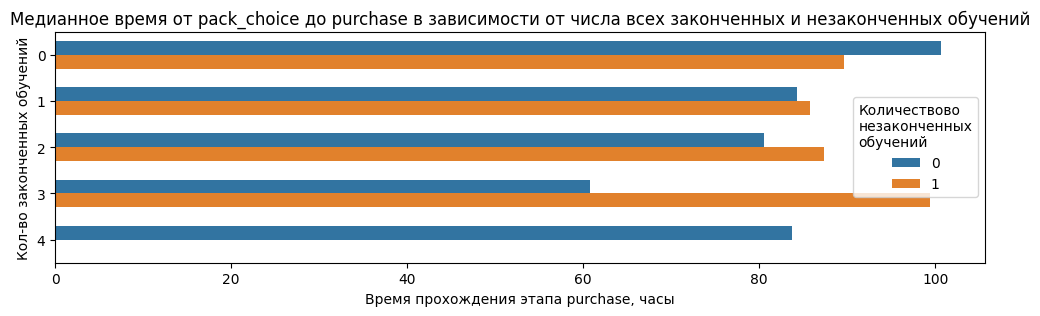

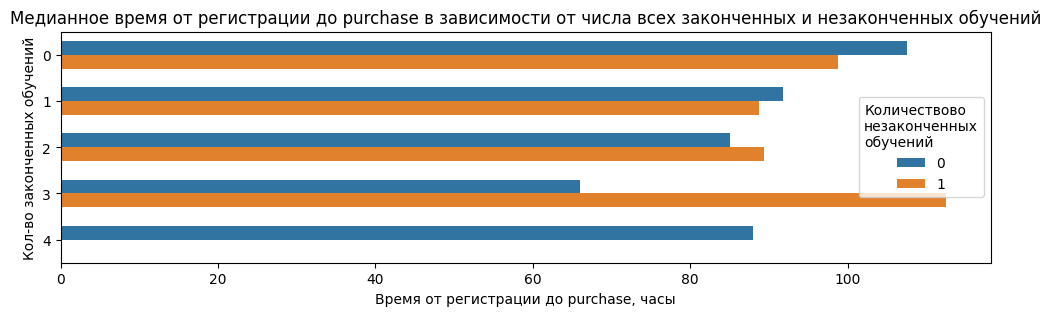

In [103]:
fig_tut_for_pack_purchase_median = plt.figure(figsize=(12, 3))
barplot = sns.barplot(
    data=reg_to_purchase_matrix_l2_valid[ \
        reg_to_purchase_matrix_l2_valid['valid'] & ~reg_to_purchase_matrix_l2_valid['purchase_isna']],
    x='pack-purchase_time_median',
    y='tutfinish_before_purchase',
    hue='tut_notfinish_before_purchase',
    orient='h',
    width=0.6
)
barplot.set_title( \
    'Медианное время от pack_choice до purchase в зависимости от числа всех законченных и незаконченных обучений');
barplot.set_xlabel('Время прохождения этапа purchase, часы');
barplot.set_ylabel('Кол-во законченных обучений');
barplot.legend (title='Количествово\nнезаконченных\nобучений', loc='center right');

fig_tut_for_reg_purchase_median = plt.figure(figsize=(12, 3))
barplot = sns.barplot(
    data=reg_to_purchase_matrix_l2_valid[ \
        reg_to_purchase_matrix_l2_valid['valid'] & ~reg_to_purchase_matrix_l2_valid['purchase_isna']],
    x='reg-purchase_time_median',
    y='tutfinish_before_purchase',
    hue='tut_notfinish_before_purchase',
    orient='h',
    width=0.6
)
barplot.set_title( \
    'Медианное время от регистрации до purchase в зависимости от числа всех законченных и незаконченных обучений');
barplot.set_xlabel('Время от регистрации до purchase, часы');
barplot.set_ylabel('Кол-во законченных обучений');
barplot.legend (title='Количествово\nнезаконченных\nобучений', loc='center right');

##### **Детальные выводы** о влиянии обучения на время прохождения этапа purchase и всей игры до момента purchase
**Время прохождения этапа purchase**
1. Время прохождения этапа purchase завист от количества завершенных обучений. При отсутсвии незавершенных:
   - **В пределах от 0 до 3 обучений**: чем больше завершенных обучений, тем быстрее проходит этап; значимое сокращение длительности этапа происходит при наличии одного обучения и при наличии 3 обучений.
   - **4-ое звершенное обучение** существенно увеличивает время прохождения этапа и ставит его в один ряд с результатами 1-2 обучений.
2. Незавершенное обучение:
   - при отсутсвии завершенных (0) сокращает время прохождения этапа;
   - при наличии завершенных - наоборот увеличивает; чем больше завершенных обучений, тем сильнее назавершенное увеличивает время прохождения этапа.

**Если посмотреть на общее время от регистрации до события purchase**, то картина будет практически такой же.

### РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО ВРЕМЕНИ ПРОХОЖДЕНИЯ ИГРЫ И ЕЕ ЭТАПОВ.

Посмотрим без подробностей на распределение пользователей по времени прохождения игры и ее отдельных этапов.
Воспользуемся таблицей-матрицей событий events_time_plus_tutorial_matrix : 

In [104]:
print(events_time_plus_tutorial_matrix.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19926 entries, 0 to 19925
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   user_id                        19926 non-null  int64         
 1   tutstart_after_reg             19926 non-null  int64         
 2   tutstart_after_level           19926 non-null  int64         
 3   tutstart_after_pack            19926 non-null  int64         
 4   tutstart_after_purch           19926 non-null  int64         
 5   tutfinish_after_reg            19926 non-null  int64         
 6   tutfinish_after_level          19926 non-null  int64         
 7   tutfinish_after_pack           19926 non-null  int64         
 8   tutfinish_after_purch          19926 non-null  int64         
 9   tut_notfinish_after_reg        19926 non-null  int64         
 10  registration_time              19926 non-null  datetime64[ns]
 11  level_choice_ti

Построим **ДИАГРАММУ** на основе столбцов длительности этапов игры:

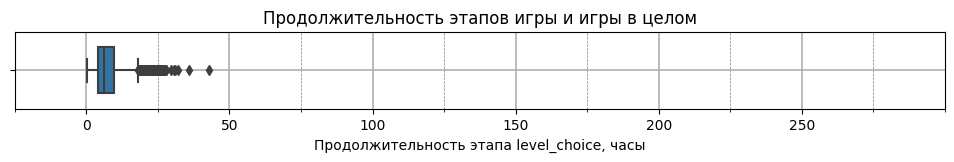

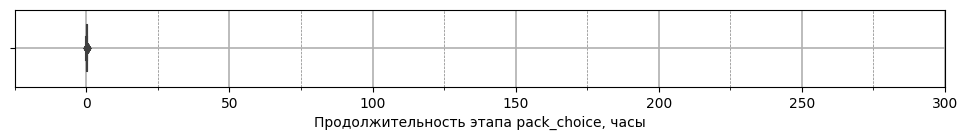

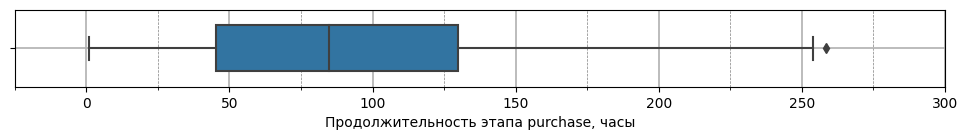

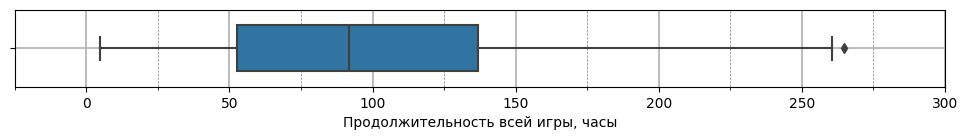

In [105]:
fig_reg_level_duration = plt.figure(figsize=(12, 1))
boxplot = sns.boxplot(
    data=events_time_plus_tutorial_matrix,
    x='level-reg_diff',
    orient='h',
    width=0.6
)
boxplot.set_title('Продолжительность этапов игры и игры в целом');
boxplot.set_xlabel('Продолжительность этапа level_choice, часы');
boxplot.grid(which='major', linewidth=1.2);
boxplot.grid(which='minor', linestyle='--', color='gray', linewidth=0.5);
boxplot.set_xticks([0,50,100,150,200,250], minor=False);
boxplot.set_xticks([-25,25,75,125,175,225,275,300], minor=True);
boxplot.set_axisbelow(True);

fig_reg_level_duration = plt.figure(figsize=(12, 1))
boxplot = sns.boxplot(
    data=events_time_plus_tutorial_matrix,
    x='pack-level_diff',
    orient='h',
    width=0.6
)
boxplot.set_xlabel('Продолжительность этапа pack_choice, часы');
boxplot.grid(which='major', linewidth=1.2);
boxplot.grid(which='minor', linestyle='--', color='gray', linewidth=0.5);
boxplot.set_xticks([0,50,100,150,200,250,300], minor=False);
boxplot.set_xticks([-25,25,75,125,175,225,275], minor=True);
boxplot.set_axisbelow(True);

fig_reg_level_duration = plt.figure(figsize=(12, 1))
boxplot = sns.boxplot(
    data=events_time_plus_tutorial_matrix,
    x='purchase-pack_diff',
    orient='h',
    width=0.6
)
boxplot.set_xlabel('Продолжительность этапа purchase, часы');
boxplot.grid(which='major', linewidth=1.2);
boxplot.grid(which='minor', linestyle='--', color='gray', linewidth=0.5);
boxplot.set_xticks([0,50,100,150,200,250,300], minor=False);
boxplot.set_xticks([-25,25,75,125,175,225,275], minor=True);
boxplot.set_axisbelow(True);

fig_reg_level_duration = plt.figure(figsize=(12, 1))
boxplot = sns.boxplot(
    data=events_time_plus_tutorial_matrix,
    x='purchase-reg_diff',
    orient='h',
    width=0.6
)
boxplot.set_xlabel('Продолжительность всей игры, часы');
boxplot.grid(which='major', linewidth=1.2);
boxplot.grid(which='minor', linestyle='--', color='gray', linewidth=0.5);
boxplot.set_xticks([0,50,100,150,200,250,300], minor=False);
boxplot.set_xticks([-25,25,75,125,175,225,275], minor=True);
boxplot.set_axisbelow(True);

##### **Вывод** о вкладе этапов в общую продолжительность игры:
Еще раз отметим, что длительность всей игры определяется этапом purchase; этап level_choice оказывает незначительное влияние, а этап pack_choice практически никакого.

### ПЕРВОЕ ОБУЧЕНИЕ ПОСЛЕ level_choice?
Ранее мы установили, что все пользователи, не закончившие ни одного обучения на этапе level_choice, также не закончили ни одного обучения на этапе pack_choice.  

Посмотрим есть ли случаи хотя бы начала обучения после события level_choice при полном отсутвии обучения на этапе level_choice.

Воспользуемся таблицей-матрицей событий events_time_plus_tutorial_matrix: 


In [106]:
print( \
    'Количество пользователей не обучавшихся на этапе level_choice                                            -', \
        events_time_plus_tutorial_matrix[events_time_plus_tutorial_matrix['tutstart_after_reg']==0].shape[0])
print( \
    'Количество пользователей не обучавшихся на этапе level_choice, но начавших обучение на этапе pack_choice -', \
        events_time_plus_tutorial_matrix[ \
            (events_time_plus_tutorial_matrix['tutstart_after_reg']==0) \
            & (events_time_plus_tutorial_matrix['tutstart_after_level']>0)].shape[0])
print( \
    'Количество пользователей не обучавшихся на этапе level_choice, но начавших обучение на этапе purchase    -', \
        events_time_plus_tutorial_matrix[\
            (events_time_plus_tutorial_matrix['tutstart_after_reg']==0) \
                & (events_time_plus_tutorial_matrix['tutstart_after_pack']>0)].shape[0])
print( \
    'Количество пользователей не обучавшихся на этапе level_choice, но начавших обучение росле purchase       -', \
        events_time_plus_tutorial_matrix[ \
            (events_time_plus_tutorial_matrix['tutstart_after_reg']==0) \
                & (events_time_plus_tutorial_matrix['tutstart_after_purch']>0)].shape[0])

Количество пользователей не обучавшихся на этапе level_choice                                            - 8068
Количество пользователей не обучавшихся на этапе level_choice, но начавших обучение на этапе pack_choice - 0
Количество пользователей не обучавшихся на этапе level_choice, но начавших обучение на этапе purchase    - 0
Количество пользователей не обучавшихся на этапе level_choice, но начавших обучение росле purchase       - 0


**Вывод**: если пользователь не начинал обучения на этапе level_choice, то он не начнет его и на других этапах игры.

## ПОДЫТОЖИМ РЕЗУЛЬТАТЫ АНАЛИЗА И ВЫВОДЫ.

### Коментарий по итогам предобработки данных
При попытке перевести данные колонки start_time в таблице events в формат datetime были обнаружены несколько некорректных значений даты-времени. С учетом того, что таких значений крайне мало, а также что они явно не относятся к 2018 году, строки, содержащие такие значения были удалены.

### Результаты предварительного анализа
**Проверка корректности данных:**  

**Результат:** Данные по пользователям, зарегистрировавшимся в 2018 г., целостны и корректны.

**Некоторые колличественные данные:**

|||
|---|---|
|В среднем пользователь начинал обучение около|1.52 раз|
|В среднем пользователь заканчивал обучение около|1.45 раз|
|Количество пользователей, проходивших обучение после оплаты|3|

**Некоторые выводы об алгоритме работы игры:**
- Действия level_choice, pack_choice и purchase могут располагаться только в следующем порядке:  -> level_choice -> pack_choice -> purchase
  - для совершения purchase предыдущие два действия обязательны
- Действия level_choice, pack_choice и purchase можно совершить только по одному разу.   
- tutorial_id представляет собой уникальный идентификатор события обучения (имеющего начало и конец)
- Проходить обучение (начинать (tutorial_start) и/или завершать (tutorial_finish)) возможно и после оплаты платных вопросов (purchase), однако такое поведение пользователя встречается крайне редко

**Медианная продолжительность завершенного обучения** - 3.7 минут

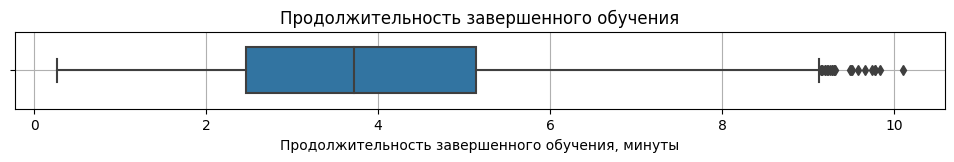

In [107]:
fig_tut_duration = plt.figure(figsize=(12, 1))
boxplot = sns.boxplot(
    data=events_tutorial,
    x='tutorial_duration',
    orient='h',
    width=0.6
)
boxplot.set_title('Продолжительность завершенного обучения');
boxplot.set_xlabel('Продолжительность завершенного обучения, минуты');
boxplot.grid();
boxplot.set_axisbelow(True);

**Отсев пользователей на различных этапах игры**:  
В процентах к числу пользователей, прошедших предыдущий этап, основной отсев происходит на этапе purchase (72% отсев). Также существенный отсев (58%) проиходит после регистрации (на этапе level_choice). Отсев на этапе pack_choice небольшой (31%). 

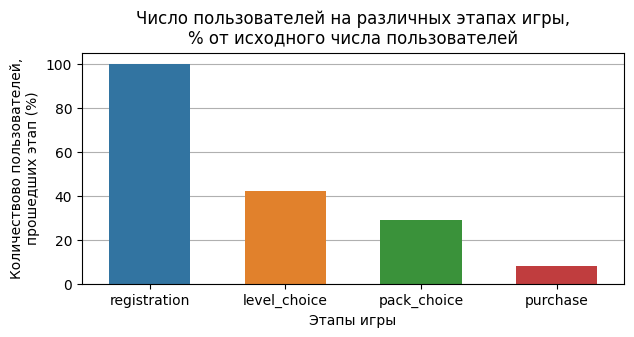

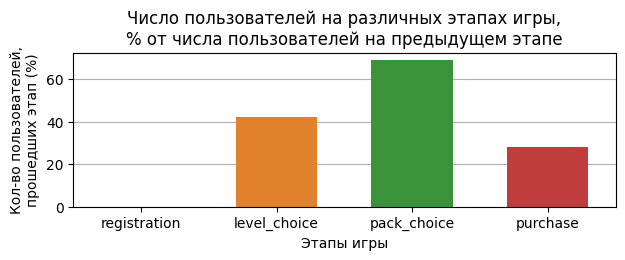

In [108]:
fig_events_reg_level_pack_purchase_cnts = plt.figure(figsize=(7, 3))
barplot = sns.barplot(
    data=events_reg_level_pack_purchase_cnts,
    x='passed_event',
    y='%_from_total',
    orient='v',
    width=0.6
)
barplot.set_title('Число пользователей на различных этапах игры,\n% от исходного числа пользователей');
barplot.set_xlabel('Этапы игры');
barplot.set_ylabel('Количествово пользователей,\nпрошедших этап (%)') #;
barplot.grid(axis='y');
barplot.set_axisbelow(True);

fig_events_reg_level_pack_purchase_cnts = plt.figure(figsize=(7, 2))
barplot = sns.barplot(
    data=events_reg_level_pack_purchase_cnts,
    x='passed_event',
    y='%_from_previous_step',
    orient='v',
    width=0.6
)
barplot.set_title('Число пользователей на различных этапах игры,\n% от числа пользователей на предыдущем этапе');
barplot.set_xlabel('Этапы игры');
barplot.set_ylabel('Кол-во пользователей,\nпрошедших этап (%)') #;
barplot.grid(axis='y');
barplot.set_axisbelow(True);

### Анализ данных
Количество пройденных завершенных и незавершенных обучений по разному влияет
- на факт прохождения этапов игры 
- и на время прохождения этапов игры.

#### Влияние обучения на факт прохождения этапов игры (на отсев пользователей)
1. **При полном отсутствии обучения** шансов пройти игру крайне мало:
   - только 1,2% пользователей без обучения проходят этап level_choice;
   - только 0,9% проходят этап pack_choice;
   - только 0,3% проходят этап purchase.
2. **Определяющим фактором для полного прохождения игры (совершения purchase) является завершение одного обучения**. Дополнительные завершенные и незавершенные обучения существенной роли не играют.
   - 100 % пользователей, завершивших хотя бы одно обучение, проходят этап level_choice;
   - 69 % пользователей, завершивших хотя бы одно обучение, проходят и этап pack_choice;
   - 19 % пользователей, завершивших хотя бы одно обучение, проходят и этап purchase.
3. **При отсутствии завершенных обучений**, важно наличие одного незавершенного. Это существенно повышает шансы прохождения этапов игры. Дополнительные незавершенные обучения почти не сказываются на результате.**
   - незавершенное обучение повышает процент прошедших level_choice до 24% (по сравнению с 1,2% при полном отсутствии обучения);
   - повышает процент прошедших pack_choice до 11% (по сравнению с 0,9% при полном отсутствии обучения);
   - повышает процент прошедших purchase до 3% (по сравнению с 0,3 % при полном отсутствии обучения).

Также важно, что те, кто не завершает обучения на этапе level_choice, не завершат обучение и на последующих этапах, даже если дойдут до них. ***Гипотеза 3***


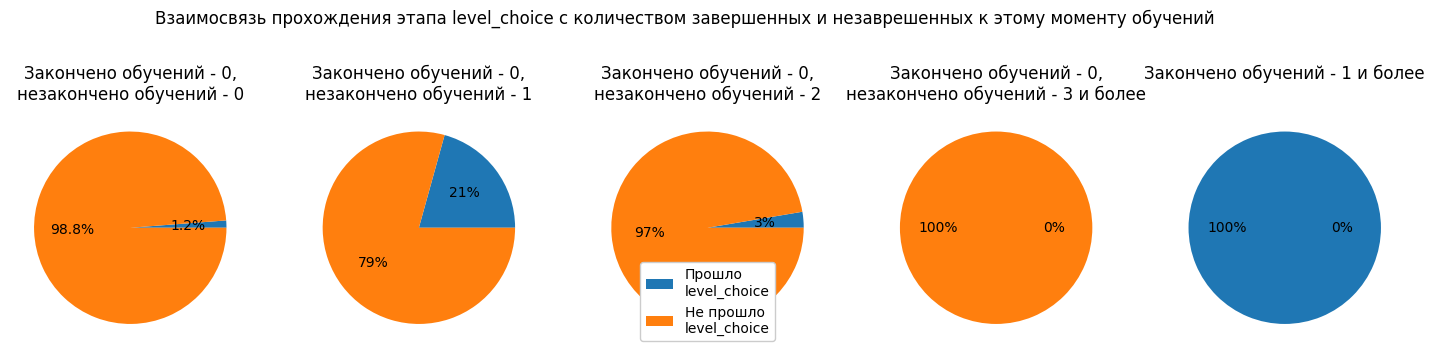

In [109]:
passing_level_choice, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 4.5))
passing_level_choice.suptitle('Взаимосвязь прохождения этапа level_choice с количеством завершенных и незаврешенных к этому моменту обучений')

axes[0].pie(
    tutfinished0_tutsarted0_after_reg_passed,
    #labels=['Прошло\nlevel_choice', 'Не прошло\nlevel_choice'],
    autopct='%.1f%%');
    #colors=['y','c'];
axes[0].set_title('Закончено обучений - 0,\nнезакончено обучений - 0');

axes[1].pie(
    tutfinished0_tutsarted1_after_reg_passed,
    #labels=['Прошло\nlevel_choice', 'Не прошло\nlevel_choice'],
    autopct='%.0f%%');
axes[1].set_title('Закончено обучений - 0,\nнезакончено обучений - 1');

axes[2].pie(
    tutfinished0_tutsarted2_after_reg_passed,
    #labels=['Прошло\nlevel_choice', 'Не прошло\nlevel_choice'],
    autopct='%.0f%%');
axes[2].set_title('Закончено обучений - 0,\nнезакончено обучений - 2');
axes[2].legend(['Прошло\nlevel_choice', 'Не прошло\nlevel_choice'], loc='lower center', framealpha=1);

axes[3].pie(
    tutfinished0_tutsarted3and_after_reg_passed,
    #labels=['Прошло\nlevel_choice', 'Не прошло\nlevel_choice'],
    autopct='%.0f%%'),
axes[3].set_title('Закончено обучений - 0,\nнезакончено обучений - 3 и более');

axes[4].pie(
    tutfinished1and_after_reg_passed,
    #labels=['Прошло\nlevel_choice', 'Не прошло\nlevel_choice'],
    autopct='%.0f%%'),
axes[4].set_title('Закончено обучений - 1 и более\n');

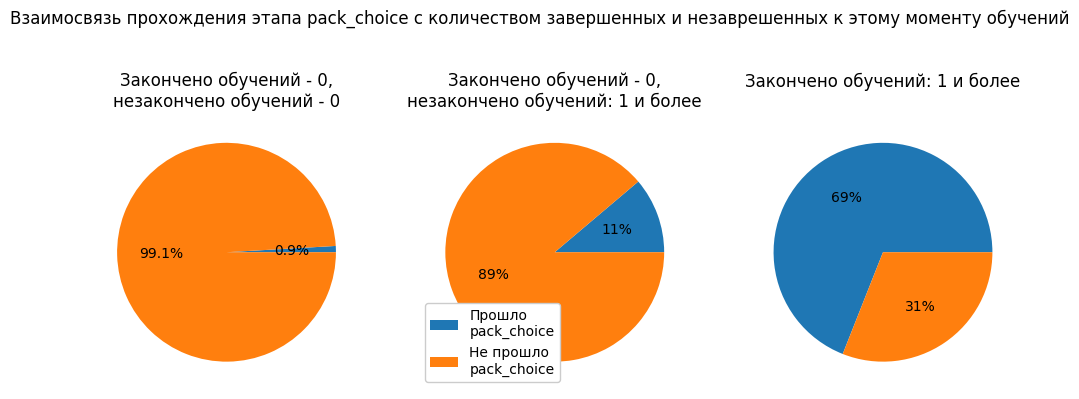

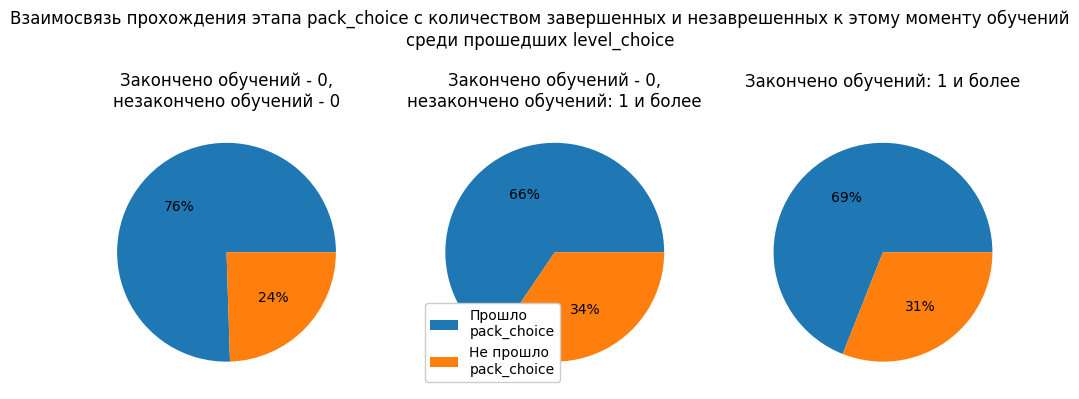

In [110]:
passing_pack_choice_all, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
passing_pack_choice_all.suptitle('Взаимосвязь прохождения этапа pack_choice с количеством завершенных и незаврешенных к этому моменту обучений')

axes[0].pie(
    tutfinished0_tutsarted0_before_pack_all,
    autopct='%.1f%%',
     );
axes[0].set_title('Закончено обучений - 0,\nнезакончено обучений - 0');


axes[1].pie(
    tutfinished0_tutsarted1and_before_pack_all,
    autopct='%.0f%%',
    );
axes[1].set_title('Закончено обучений - 0,\nнезакончено обучений: 1 и более');
axes[1].legend(['Прошло\npack_choice', 'Не прошло\npack_choice'], loc='lower left', framealpha=1);

axes[2].pie(
    tutfinished1and_before_pack_all,
    autopct='%.0f%%',
    );
axes[2].set_title('Закончено обучений: 1 и более\n');

passing_pack_choice_level_passed, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
passing_pack_choice_level_passed.suptitle('Взаимосвязь прохождения этапа pack_choice с количеством завершенных и незаврешенных к этому моменту обучений\nсреди прошедших level_choice')

axes[0].pie(
    tutfinished0_tutsarted0_before_pack_level_passed,
    autopct='%.0f%%',
    );
axes[0].set_title('Закончено обучений - 0,\nнезакончено обучений - 0');


axes[1].pie(
    tutfinished0_tutsarted1and_before_pack_level_passed,
    autopct='%.0f%%',
    );
axes[1].set_title('Закончено обучений - 0,\nнезакончено обучений: 1 и более');
axes[1].legend(['Прошло\npack_choice', 'Не прошло\npack_choice'], loc='lower left', framealpha=1);

axes[2].pie(
    tutfinished1and_before_pack_level_passed,
    autopct='%.0f%%',
    );
axes[2].set_title('Закончено обучений: 1 и более\n');

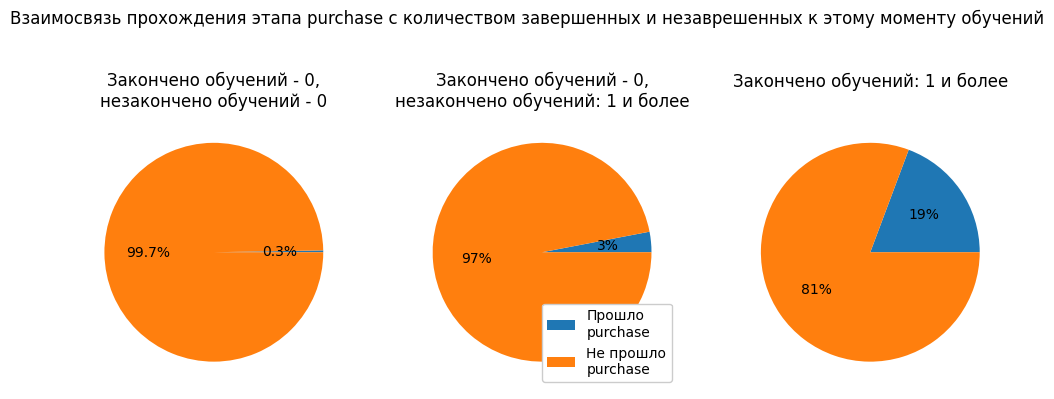

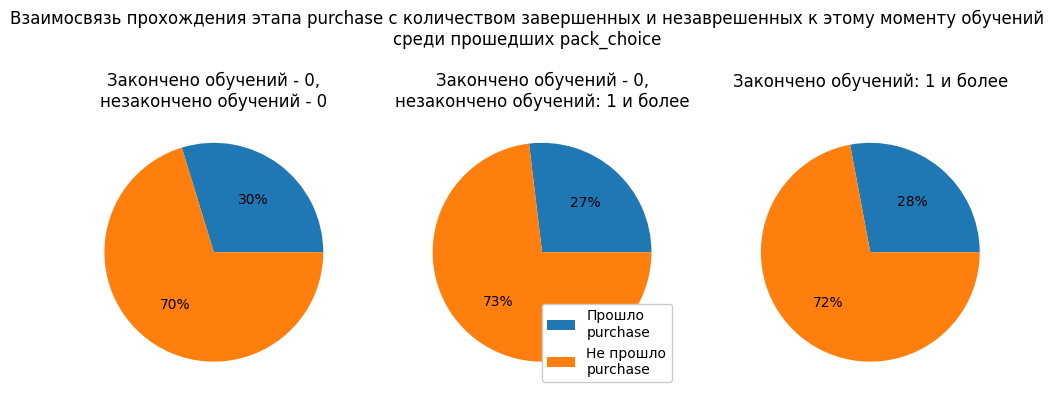

In [111]:
passing_purchase_all, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
passing_purchase_all.suptitle('Взаимосвязь прохождения этапа purchase с количеством завершенных и незаврешенных к этому моменту обучений')

axes[0].pie(
    tutfinished0_tutsarted0_before_purchase_all,
    autopct='%.1f%%',
    #colors=['y','c']
    );
axes[0].set_title('Закончено обучений - 0,\nнезакончено обучений - 0');


axes[1].pie(
    tutfinished0_tutsarted1and_before_purchase_all,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[1].set_title('Закончено обучений - 0,\nнезакончено обучений: 1 и более');
axes[1].legend(['Прошло\npurchase', 'Не прошло\npurchase'], loc='lower right', framealpha=1);

axes[2].pie(
    tutfinished1and_before_purchase_all,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[2].set_title('Закончено обучений: 1 и более\n');

passing_purchase_pack_passed, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
passing_purchase_pack_passed.suptitle('Взаимосвязь прохождения этапа purchase с количеством завершенных и незаврешенных к этому моменту обучений\nсреди прошедших pack_choice')

axes[0].pie(
    tutfinished0_tutsarted0_before_purchase_pack_passed,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[0].set_title('Закончено обучений - 0,\nнезакончено обучений - 0');


axes[1].pie(
    tutfinished0_tutsarted1and_before_purchase_pack_passed,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[1].set_title('Закончено обучений - 0,\nнезакончено обучений: 1 и более');
axes[1].legend(['Прошло\npurchase', 'Не прошло\npurchase'], loc='lower right', framealpha=1);

axes[2].pie(
    tutfinished1and_before_purchase_pack_passed,
    autopct='%.0f%%',
    #colors=['y','c']
    );
axes[2].set_title('Закончено обучений: 1 и более\n');

#### Влияние обучения на время прохождения этапов игры


##### Вклад этапов в общую продолжительность игры.
Длительность всей игры определяется этапом purchase; этап level_choice оказывает незначительное влияние, а этап pack_choice практически никакого.
Соотношение длительности этапов игры примерно такое:
   - level_choice - часы;
   - pack_choice  - минуты;
   - purchase     - дни.

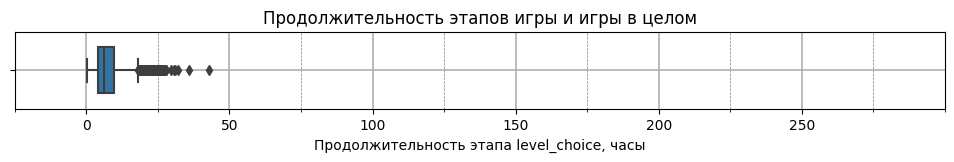

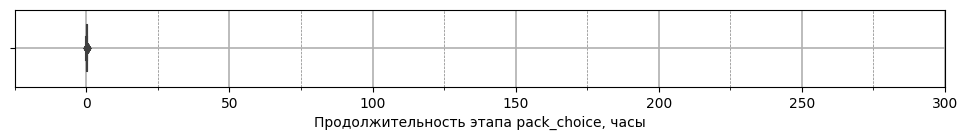

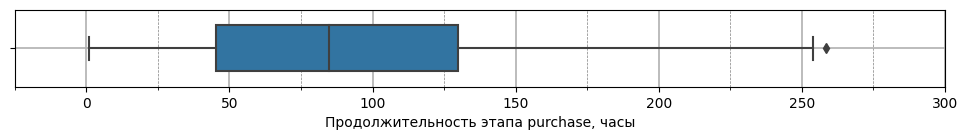

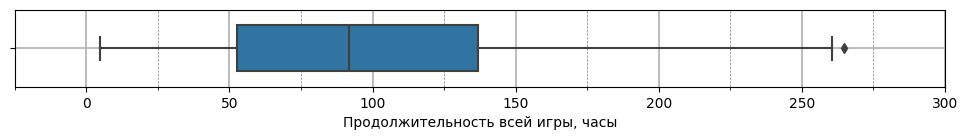

In [112]:
fig_reg_level_duration = plt.figure(figsize=(12, 1))
boxplot = sns.boxplot(
    data=events_time_plus_tutorial_matrix,
    x='level-reg_diff',
    orient='h',
    width=0.6
)
boxplot.set_title('Продолжительность этапов игры и игры в целом');
boxplot.set_xlabel('Продолжительность этапа level_choice, часы');
boxplot.grid(which='major', linewidth=1.2);
boxplot.grid(which='minor', linestyle='--', color='gray', linewidth=0.5);
boxplot.set_xticks([0,50,100,150,200,250], minor=False);
boxplot.set_xticks([-25,25,75,125,175,225,275,300], minor=True);
boxplot.set_axisbelow(True);

fig_reg_level_duration = plt.figure(figsize=(12, 1))
boxplot = sns.boxplot(
    data=events_time_plus_tutorial_matrix,
    x='pack-level_diff',
    orient='h',
    width=0.6
)
boxplot.set_xlabel('Продолжительность этапа pack_choice, часы');
boxplot.grid(which='major', linewidth=1.2);
boxplot.grid(which='minor', linestyle='--', color='gray', linewidth=0.5);
boxplot.set_xticks([0,50,100,150,200,250,300], minor=False);
boxplot.set_xticks([-25,25,75,125,175,225,275], minor=True);
boxplot.set_axisbelow(True);

fig_reg_level_duration = plt.figure(figsize=(12, 1))
boxplot = sns.boxplot(
    data=events_time_plus_tutorial_matrix,
    x='purchase-pack_diff',
    orient='h',
    width=0.6
)
boxplot.set_xlabel('Продолжительность этапа purchase, часы');
boxplot.grid(which='major', linewidth=1.2);
boxplot.grid(which='minor', linestyle='--', color='gray', linewidth=0.5);
boxplot.set_xticks([0,50,100,150,200,250,300], minor=False);
boxplot.set_xticks([-25,25,75,125,175,225,275], minor=True);
boxplot.set_axisbelow(True);

fig_reg_level_duration = plt.figure(figsize=(12, 1))
boxplot = sns.boxplot(
    data=events_time_plus_tutorial_matrix,
    x='purchase-reg_diff',
    orient='h',
    width=0.6
)
boxplot.set_xlabel('Продолжительность всей игры, часы');
boxplot.grid(which='major', linewidth=1.2);
boxplot.grid(which='minor', linestyle='--', color='gray', linewidth=0.5);
boxplot.set_xticks([0,50,100,150,200,250,300], minor=False);
boxplot.set_xticks([-25,25,75,125,175,225,275], minor=True);
boxplot.set_axisbelow(True);

##### Этап level_choice.

**Важность учета незавершенных обучений, особенно при отсутсвии завершенных:**   
- Наибольший межквартильный интервал, а также размах всего распределения (не считая потенциальных выбросов), наблюдаются для случая с отсутсвием завершенных обучений; при этом по количеству пользователей эта группа занимает не 1-ое место. 
  - Это объясняется тем, что при 0 завершенных обучений, важную роль играют незавершенные обучений и их количество; тогда как при наличии хотя бы одного завершенного обучения, влияние незавершенных на время прохождение этапа не велика (при этом помним помним, что влияние на факт прохожения level_choice существенно). 
- Т.о., **рассматривать влияние завершенных обучений на время прохождения этапа без учета наличия незавершенных, в некоторых ситуациях было бы некоректно**.

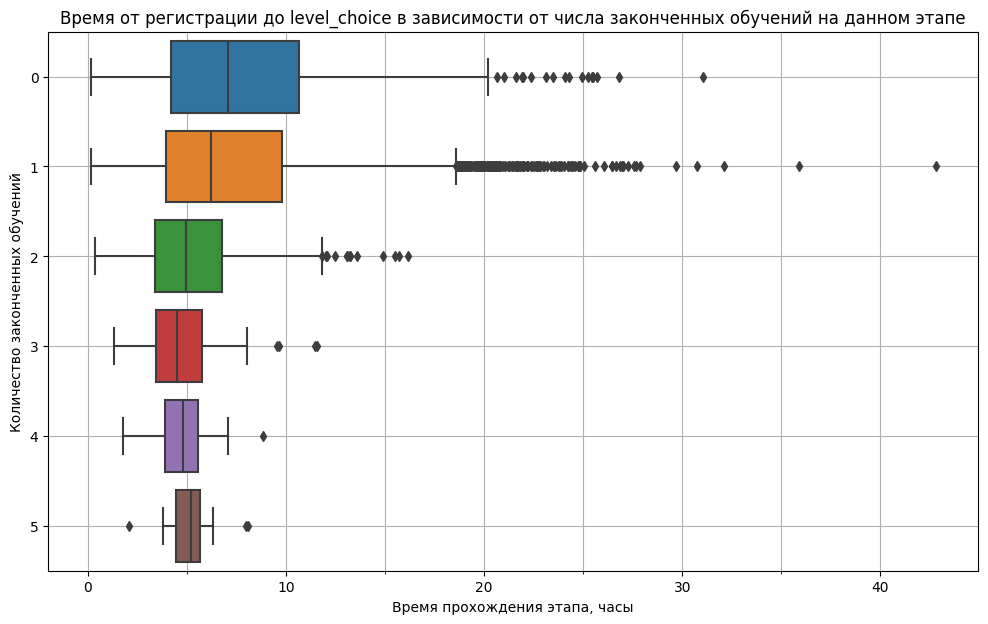

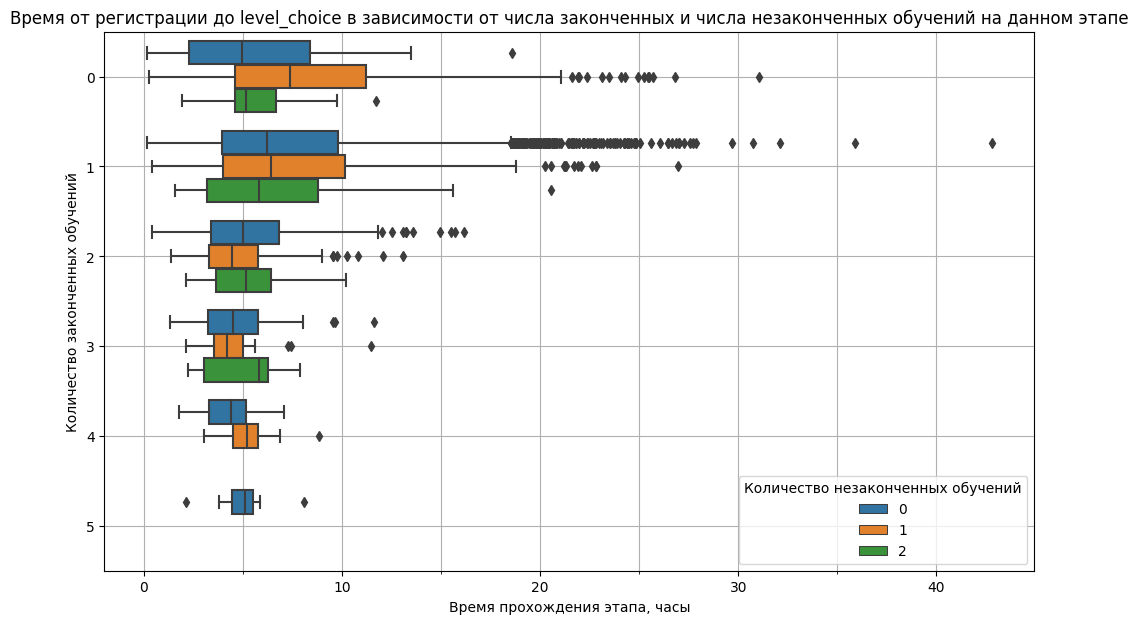

In [113]:
fig_tut_finished_after_reg = plt.figure(figsize=(12, 7))
boxplot = sns.boxplot(
    data=events_time_plus_tutorial_matrix_for_level_l1[~events_time_plus_tutorial_matrix_for_level_l1['level_isna']],
    y='tutfinish_after_reg',
    x='level-reg_diff',
    orient='h',
    width=0.8
)
boxplot.set_title('Время от регистрации до level_choice в зависимости от числа законченных обучений на данном этапе');
boxplot.set_xlabel('Время прохождения этапа, часы');
boxplot.set_ylabel('Количество законченных обучений');
boxplot.grid(which='major');
boxplot.grid(which='minor');
boxplot.set_xticks([0,10,20,30,40], minor=False);
boxplot.set_xticks([5,15,25,35], minor=True);
#plt.savefig('plot.png', dpi=300, bbox_inches='tight');
boxplot.set_axisbelow(True);

fig_tut_notfinished_after_reg = plt.figure(figsize=(12, 7))
boxplot = sns.boxplot(
    data=events_time_plus_tutorial_matrix_for_level_l2[~events_time_plus_tutorial_matrix_for_level_l2['level_isna']],
    y='tutfinish_after_reg',
    x='level-reg_diff',
    hue='tut_notfinish_after_reg' ,
    orient='h',
    width=0.8   
)
boxplot.set_title('Время от регистрации до level_choice в зависимости от числа законченных и числа незаконченных обучений на данном этапе');
boxplot.set_xlabel('Время прохождения этапа, часы');
boxplot.set_ylabel('Количество законченных обучений');
boxplot.grid(which='major');
boxplot.grid(which='minor');
boxplot.legend (title='Количество незаконченных обучений');
boxplot.set_xticks([0,10,20,30,40], minor=False);
boxplot.set_xticks([5,15,25,35], minor=True);
boxplot.set_axisbelow(True);


**Влияние обучения на время прохождения этапа level_choice**
1. **Пользователи вообще без обучения проходят этап со средней скоростью**, однако помним что у таких пользователей очень мало шансов пройти этап в принципе.
2. **Небольшое количество обучений увеличивает время прохождения этапа** (однако многократно повышает шансы пройти этап в принципе):
    - дольше всего этап проходят пользователи с одним незавершенным обучением (8,3 часа), а также с одним завершенным (и 0-2 незавершенных).
3. **Начиная с 2 любых обучений, каждое дополнительное (3-ее) обучение любого  типа уменьшают время, 4-ое еще больше уменьшает время**:
   - быстрее всех этап проходят пользователи с 3 завершенными и 1 незавершенным обучениями (4,2 часа), а также с 4 завершенными.
4. **Слишком большое количество обучений увеличивает время прохождения этапа**:
   - 5-ое обучение (любого типа) увеличивает время прохождения этапа.

- Также может оказаться важным какие обучения шли у пользователя раньше - завершенные или незавершенные, однако для исследования этого вопроса количества пользователей в подгруппах определенно недостаточно.  
Но в любом случае очевидно, что **количество незавершенных обучений очень сильно влияет на время прохождения этапа** для пользователей с одинаковым количеством завершенных обучений.

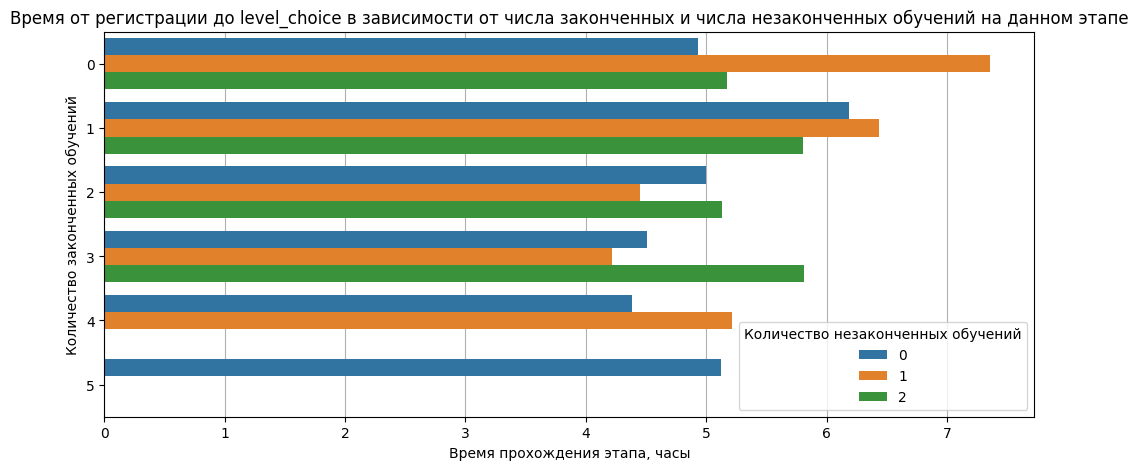

In [114]:
fig_tut_notfinished_after_reg = plt.figure(figsize=(12, 5))
barplot = sns.barplot(
    data=events_time_plus_tutorial_matrix_for_level_l2[~events_time_plus_tutorial_matrix_for_level_l2['level_isna']],
    y='tutfinish_after_reg',
    x='level-reg_diff',
    hue='tut_notfinish_after_reg' ,
    orient='h',
    width=0.8,
    estimator = 'median',
    errorbar=None   
)
barplot.set_title('Время от регистрации до level_choice в зависимости от числа законченных и числа незаконченных обучений на данном этапе');
barplot.set_xlabel('Время прохождения этапа, часы');
barplot.set_ylabel('Количество законченных обучений');
barplot.grid(axis='x');
barplot.legend (title='Количество незаконченных обучений',loc='lower right');
barplot.set_axisbelow(True);

##### Этап pack_choice.

Влияние обучения на время прохождения этапа pack_choice и всей игры до момента pack_choice:

**Время прохождения этапа pack_choice**
1. Время прохождения этапа pack_choice завист от количества завершенных обучений. При отсутсвии незавершенных:
   - В диапазоне **от 0 до 3 завершенных обучений** значимой разницы во времени прохождения этапа не наблюдается; максимум - 5 минут при 2 обучениях.
   - При количестве **завершенных обучений 4 и 5** время прохождения этапа существенно меньше, минимум - 3 минуты при 4 обучениях.
2. Однозначного влияния количества незавершенных на этапе pack_choice обучений на время прохождения этапа нет. Незавершенные обучения могут как увеличивать, так и уменьшать это время, как правило, незначительно, хотя при 4 завершенных обучениях одно незавершенное увеличивает время прохождения этапа болле чем в 2 раза.
3. Быстрее всего этап проходят пользователи с 4 завершенными обучениями (и без незавершенных) - медианно за 3 минуты. Самая медленная группа проходит этап медианно более чем за 6 минут.

- **Следует иметь ввиду, что этап pack_choice всего занимает несколько минут**. 

**Время прохождения игры от регистрации до события pack_choice**
1. Время прохождения игры завист от количества завершенных на этом этапе обучений:
   - **Одно (1) завершенное обучение** существенно **увеличивает** время игры;
   - При любом другом количестве завершенных обучений (0, 2 и более), существенной разницы во времени не наблюдается.
2. Количество незавершенных на этапе pack_choice обучений тоже влияет на время прохождения этого этапа. Однако это влияние зависит от наличия завершенных обучений:
   - При отсутсвии **завершенных обучений (0)**:
     - **незавершенное обучение** существенно **увеличивает время прохождения этапа** (видимо не даёт достаточных дополнительных знаний, а время при этом тратится);
   - При наличии **завершенных обучений (1 и более)**:
      - **Значимого и определенного влияния** дополнительных **незавершенных обучений не просматривается** - они могут как немного увеличивать, так и немного уменьшать время прохождения этапа (видимо в зависимости от общего числа обучений). 

- **Картина связи количества обучений и времени прохождения игры от регистрации до момента pack_choice, в целом повторяет аналогичную картину для этапа level_choice**, поскольку этот этап занимает на порядок больше времени чем этап pack_choice и влияние времени прохождения этапа pack_choice на общую картину несущественно.
Небольшие, иногда кажущиеся нелогичными, расхождения между картинами (например медианное время прохождения обоих этапов для пользователей без обучения - 4,8 часа, а время прохождения только этапа level_choice - 4,9 часа) обусловлены, в частности, тем, что часть пользователей, присутсвовавших на этапе level_choice, отсеялись на этапе pack_choice (вероятно самые медлительные в приведенном примере).

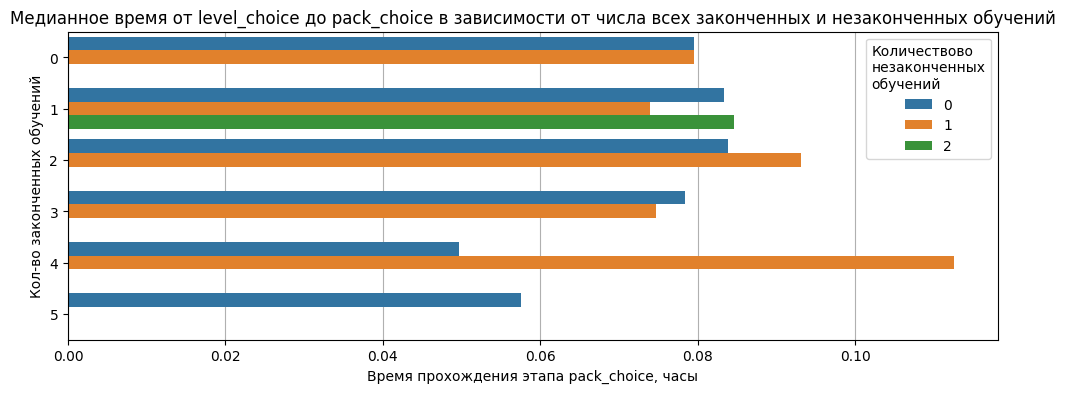

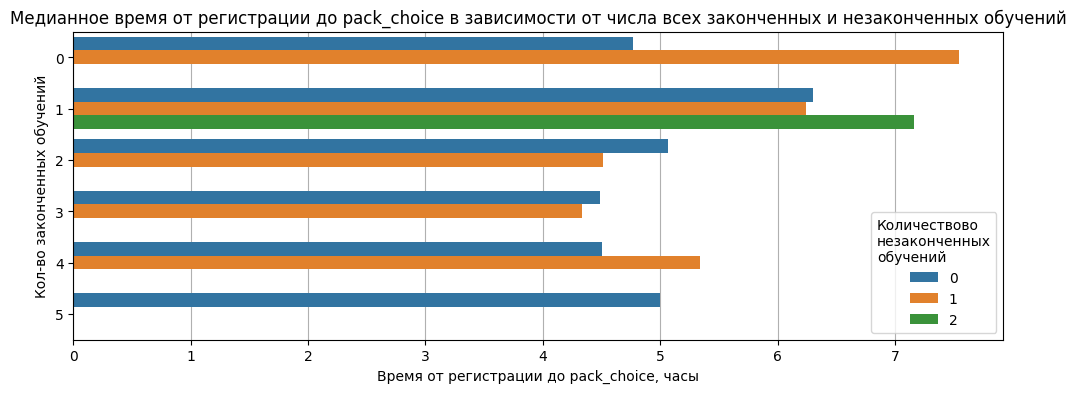

In [115]:
fig_tut_for_level_pack_median = plt.figure(figsize=(12, 4))
barplot = sns.barplot(
    data=reg_to_pack_matrix_l2_valid[reg_to_pack_matrix_l2_valid['valid'] & ~reg_to_pack_matrix_l2_valid['pack_isna']],
    x='level-pack_time_median',
    y='tutfinish_before_pack',
    hue='tut_notfinish_before_pack',
    orient='h',
    width=0.8
)
barplot.set_title('Медианное время от level_choice до pack_choice в зависимости от числа всех законченных и незаконченных обучений');
barplot.set_xlabel('Время прохождения этапа pack_choice, часы');
barplot.set_ylabel('Кол-во законченных обучений');
barplot.legend (title='Количествово\nнезаконченных\nобучений', loc='upper right');
barplot.grid(axis='x');
barplot.set_axisbelow(True);

fig_tut_for_reg_pack_median = plt.figure(figsize=(12, 4))
barplot = sns.barplot(
    data=reg_to_pack_matrix_l2_valid[reg_to_pack_matrix_l2_valid['valid'] & ~reg_to_pack_matrix_l2_valid['pack_isna']],
    x='reg-pack_time_median',
    y='tutfinish_before_pack',
    hue='tut_notfinish_before_pack',
    orient='h',
    width=0.8
)
barplot.set_title('Медианное время от регистрации до pack_choice в зависимости от числа всех законченных и незаконченных обучений');
barplot.set_xlabel('Время от регистрации до pack_choice, часы');
barplot.set_ylabel('Кол-во законченных обучений');
barplot.legend (title='Количествово\nнезаконченных\nобучений', loc='lower right');
barplot.grid(axis='x');
barplot.set_axisbelow(True);

##### Этап purchase.

Влияние обучения на время прохождения этапа purchase и всей игры до момента purchase:

**Время прохождения этапа purchase**
1. Время прохождения этапа purchase завист от количества завершенных обучений. **При отсутсвии незавершенных (0)**:
   - **В пределах от 0 до 3 обучений**: Чем больше завершенных обучений, тем быстрее проходит этап; значимое сокращение длительности этапа происходит при наличии одного обучения и при наличии 3 обучений.
   - **4-ое звершенное обучение** существенно увеличивает время прохождения этапа и ставит его в один ряд с результатами 1-2 обучений.
2. **Незавершенное обучение**:
   - при отсутсвии завершенных (0) сокращает время прохождения этапа;
   - при наличии завершенных - наоборот увеличивает; чем больше завершенных обучений, тем сильнее назавершенное увеличивает время прохождения этапа.
3. Самая быстрая группа проходит этап медианно за 65,9 часа (менее 3 суток), самая медленная - за 112,6 часа (более 4,5 суток).

**Если посмотреть на общее время от регистрации до события purchase**, то картина будет практически такой же.

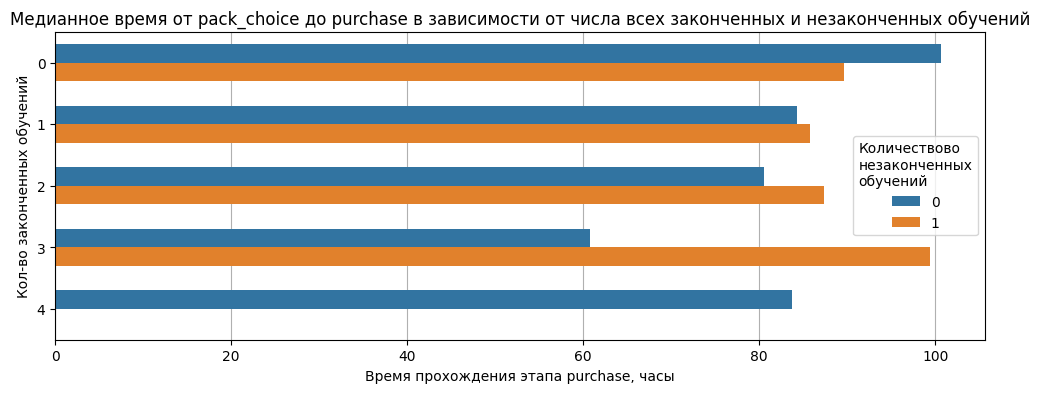

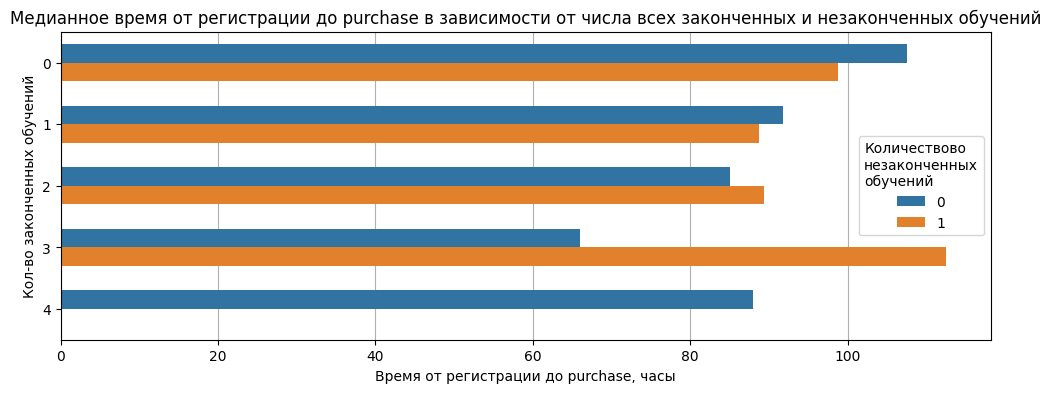

In [116]:
fig_tut_for_pack_purchase_median = plt.figure(figsize=(12, 4))
barplot = sns.barplot(
    data=reg_to_purchase_matrix_l2_valid[reg_to_purchase_matrix_l2_valid['valid'] & ~reg_to_purchase_matrix_l2_valid['purchase_isna']],
    x='pack-purchase_time_median',
    y='tutfinish_before_purchase',
    hue='tut_notfinish_before_purchase',
    orient='h',
    width=0.6
)
barplot.set_title('Медианное время от pack_choice до purchase в зависимости от числа всех законченных и незаконченных обучений');
barplot.set_xlabel('Время прохождения этапа purchase, часы');
barplot.set_ylabel('Кол-во законченных обучений');
barplot.legend (title='Количествово\nнезаконченных\nобучений', loc='center right');
barplot.set_axisbelow(True);
barplot.grid(axis='x');

fig_tut_for_reg_purchase_median = plt.figure(figsize=(12, 4))
barplot = sns.barplot(
    data=reg_to_purchase_matrix_l2_valid[reg_to_purchase_matrix_l2_valid['valid'] & ~reg_to_purchase_matrix_l2_valid['purchase_isna']],
    x='reg-purchase_time_median',
    y='tutfinish_before_purchase',
    hue='tut_notfinish_before_purchase',
    orient='h',
    width=0.6
)
barplot.set_title('Медианное время от регистрации до purchase в зависимости от числа всех законченных и незаконченных обучений');
barplot.set_xlabel('Время от регистрации до purchase, часы');
barplot.set_ylabel('Кол-во законченных обучений');
barplot.legend (title='Количествово\nнезаконченных\nобучений', loc='center right');
barplot.set_axisbelow(True);
barplot.grid(axis='x');

Влияние этапа, на котором было завершено обучение, на время прохождения этапа purchase и всей игры до момента purchase:
1. **Время прохождения этапа purchase:**
   - Завершение обучения **на этапе purchase** (в дополнение к обучениям, завершенным ранее) не оказывает существенного и определенного влияния на скорость прохождения этапа.
2. **Если посмотреть на общее время от регистрации до события pack_choice**, то картина будет такой же.

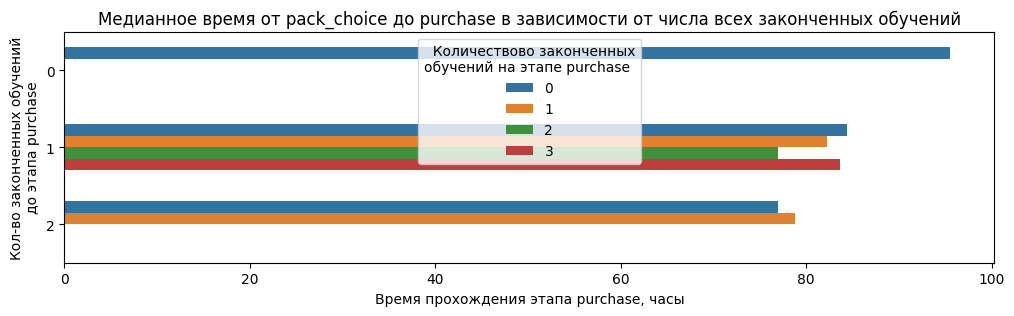

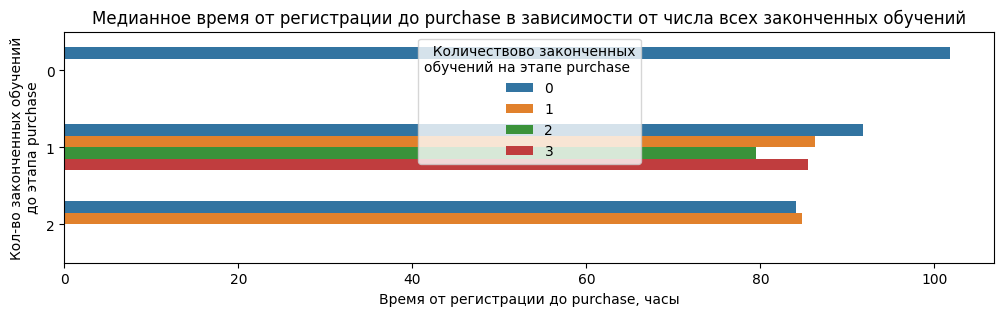

In [117]:
fig_tut_for_purch_median = plt.figure(figsize=(12, 3))
barplot = sns.barplot(
    data=reg_to_purchase_l1_details_matrix_l1_valid[ \
        reg_to_purchase_l1_details_matrix_l1_valid['valid'] \
            & ~reg_to_purchase_l1_details_matrix_l1_valid['purchase_isna']],
    x='pack-purchase_time_median',
    y='tutfinish_before_pack',
    hue='tutfinish_after_pack',
    orient='h',
    width=0.6
)
barplot.set_title( \
    'Медианное время от pack_choice до purchase в зависимости от числа всех законченных обучений');
barplot.set_xlabel('Время прохождения этапа purchase, часы');
barplot.set_ylabel('Кол-во законченных обучений\nдо этапа purchase');
barplot.legend (title='  Количествово законченных\nобучений на этапе purchase', loc='upper center');

fig_tut_for_reg_pucrh_median = plt.figure(figsize=(12, 3))
barplot = sns.barplot(
    data=reg_to_purchase_l1_details_matrix_l1_valid[ \
        reg_to_purchase_l1_details_matrix_l1_valid['valid'] \
            & ~reg_to_purchase_l1_details_matrix_l1_valid['purchase_isna']],
    x='reg-purchase_time_median',
    y='tutfinish_before_pack',
    hue='tutfinish_after_pack',
    orient='h',
    width=0.6
)
barplot.set_title( \
    'Медианное время от регистрации до purchase в зависимости от числа всех законченных обучений');
barplot.set_xlabel('Время от регистрации до purchase, часы');
barplot.set_ylabel('Кол-во законченных обучений\nдо этапа purchase');
barplot.legend (title='  Количествово законченных\nобучений на этапе purchase', loc='upper center');

#### Общий коментарий о влиянии количества и типов обучений на время прохождения игрыя.
С ростом числа обучений время прохождения игры сначала уменьшается, но начиная примерно с 4-го обучения увеличивается.- 

#### Общий коментарий о важности обучения.
Отметим что обучение становится все более важным фактором на каждом следующем этапе игры. Значение обучения с каждым этапом всё больше определяет как время прохождения этапа, так и шансы пройти этап.

#### Начинают ли пользователи первое обучение после level_choice?
Было установлено, что если пользователь не начинал обучения на этапе level_choice, то он не начнет его и на других этапах игры.
